# Ca5: Deep Q-networks and Advanced Value-based Methods

## Neural Network Function Approximation in Reinforcement Learning

Welcome to Computer Assignment 5, where we explore the intersection of deep learning and reinforcement learning through Deep Q-Networks (DQN). This assignment introduces function approximation for large state spaces, addresses key challenges in deep RL training, and implements advanced DQN variants that form the foundation of modern value-based methods.

### Learning Objectives
By the end of this assignment, you will master:

1. **Deep Q-Networks (DQN)** - Neural network function approximation for Q-learning
2. **Experience Replay** - Breaking temporal correlations through intelligent sampling
3. **Target Networks** - Stabilizing training with fixed Q-value targets
4. **Double DQN** - Addressing overestimation bias in Q-value estimation
5. **Dueling DQN** - Separating state value and advantage estimation
6. **Prioritized Experience Replay** - Intelligent sampling based on learning priority
7. **Rainbow DQN** - Combining multiple DQN improvements for state-of-the-art performance

### Prerequisites
- Strong understanding of Q-learning and temporal difference methods (CA3)
- Familiarity with neural networks and PyTorch
- Knowledge of optimization and gradient descent
- Understanding of exploration strategies and replay buffers
- Completion of CA1-CA4 or equivalent RL background

### Roadmap
This comprehensive assignment builds progressively from DQN fundamentals to advanced techniques:

- **Section 1**: From Tabular to Deep Q-Learning (Function Approximation, DQN Architecture)
- **Section 2**: Experience Replay and Target Networks (Stability, Sample Efficiency)
- **Section 3**: Double DQN (Bias Correction, Overestimation Analysis)
- **Section 4**: Dueling DQN (Value-Advantage Decomposition, Architecture Design)
- **Section 5**: Prioritized Experience Replay (Intelligent Sampling, Sum Trees)
- **Section 6**: Rainbow DQN (Combining Improvements, State-of-the-Art Methods)
- **Section 7**: Comparative Analysis and Hyperparameter Tuning

Let's dive into the world of deep reinforcement learning and discover how neural networks can solve complex decision-making problems!

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import gym
import random
from collections import deque, namedtuple
import cv2
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("✓ All libraries imported successfully")
print(f"✓ Device: {device}")
print("✓ PyTorch version:", torch.__version__)
print("✓ Random seeds set for reproducibility")


✓ All libraries imported successfully
✓ Device: cpu
✓ PyTorch version: 2.4.1
✓ Random seeds set for reproducibility


# Part 1: from Tabular Q-learning to Deep Q-networks

## 1.1 Limitations of Tabular Q-learning

**Recall from Session 3**: Tabular Q-Learning stores Q-values in a lookup table Q(s,a).

**Critical Limitations:**
- **Curse of Dimensionality**: State space grows exponentially
- **Memory Requirements**: |S| × |A| entries needed
- **No Generalization**: Each state-action pair learned independently
- **Discrete States Only**: Cannot handle continuous observations

**Example Problem**: Atari games have 210 × 160 × 3 = 100,800 pixel values. Even with binary pixels, we have 2^100,800 possible states!

## 1.2 Function Approximation Solution

**Key Insight**: Replace Q-table with a function approximator Q(s,a;θ) where θ are learnable parameters.

**Neural Network Approximation:**
```
Q(s,a;θ) ≈ Q*(s,a)
```

**Advantages:**
- **Generalization**: Similar states produce similar Q-values
- **Scalability**: Handle high-dimensional state spaces
- **Continuous States**: Natural handling of continuous observations
- **Feature Learning**: Automatically learn relevant features

## 1.3 Deep Q-network (dqn) Architecture

**Standard DQN Network:**
```
State → Conv/FC Layers → Hidden Layers → Q-values for all actions
```

**Two Main Architectures:**

### 1.3.1 Fully Connected Dqn
For low-dimensional state spaces (CartPole, etc.):
```
State (n) → FC(512) → ReLU → FC(256) → ReLU → FC(|A|)
```

### 1.3.2 Convolutional Dqn
For image-based state spaces (Atari games):
```
Image (84×84×4) → Conv(32,8×8,s=4) → ReLU → 
Conv(64,4×4,s=2) → ReLU → Conv(64,3×3,s=1) → ReLU → 
FC(512) → ReLU → FC(|A|)
```

## 1.4 Dqn Training Process

**Loss Function** (Mean Squared Error):
```
L(θ) = E[(yi - Q(si,ai;θ))²]
```

Where the **target** is:
```
yi = ri + γ max_a' Q(si+1,a';θ)
```

**Gradient Update:**
```
θ ← θ - α ∇_θ L(θ)
```

## 1.5 Key Challenges in Deep Q-learning

**1. Non-Stationary Targets**
- Target yi changes as Q-network updates
- Can lead to unstable learning

**2. Temporal Correlations**
- Sequential data violates i.i.d. assumption
- Can cause catastrophic forgetting

**3. Overestimation Bias**
- max operator leads to optimistic Q-values
- Compounds over time

**4. Sample Inefficiency**
- Neural networks need many samples
- Online learning can be slow

**Solutions**: Experience Replay, Target Networks, Double DQN, etc.

Analyzing Different DQN Architectures...


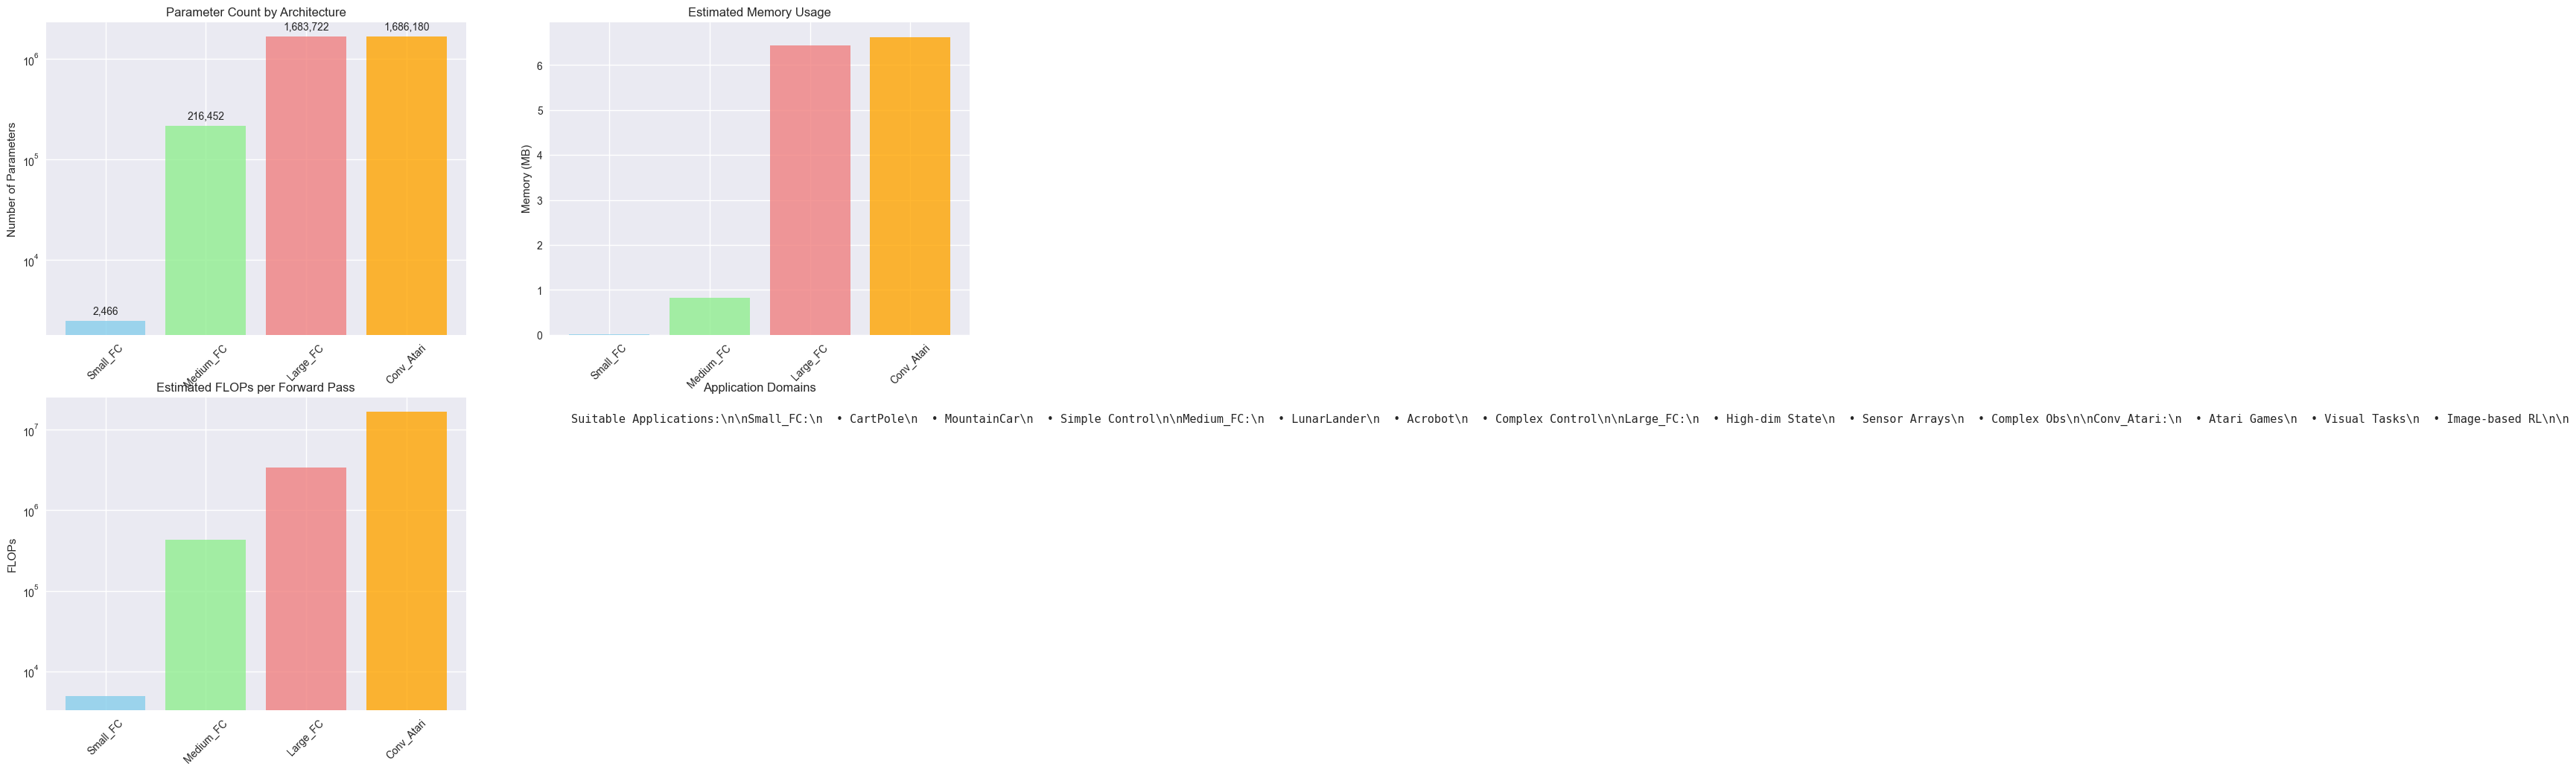

\nArchitecture Analysis Summary:
Small_FC:
  Parameters: 2,466
  Memory: 0.01 MB
  FLOPs: 4,932

Medium_FC:
  Parameters: 216,452
  Memory: 0.83 MB
  FLOPs: 432,904

Large_FC:
  Parameters: 1,683,722
  Memory: 6.43 MB
  FLOPs: 3,367,444

Conv_Atari:
  Parameters: 1,686,180
  Memory: 6.62 MB
  FLOPs: 16,861,800

✓ DQN architectures implemented and analyzed
✓ Parameter efficiency and computational costs evaluated


In [4]:
class DQN(nn.Module):
    """Deep Q-Network for discrete action spaces"""
    
    def __init__(self, state_size, action_size, hidden_sizes=[512, 256], dropout=0.1):
        super(DQN, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        
        layers = []
        input_size = state_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            input_size = hidden_size
        
        layers.append(nn.Linear(input_size, action_size))
        
        self.network = nn.Sequential(*layers)
        
        self.apply(self._init_weights)
    
    def _init_weights(self, layer):
        """Initialize network weights"""
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.01)
    
    def forward(self, state):
        """Forward pass through network"""
        return self.network(state)

class ConvDQN(nn.Module):
    """Convolutional DQN for image-based observations"""
    
    def __init__(self, action_size, input_channels=4):
        super(ConvDQN, self).__init__()
        self.action_size = action_size
        
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        conv_out_size = 64 * 7 * 7
        
        self.fc1 = nn.Linear(conv_out_size, 512)
        self.fc2 = nn.Linear(512, action_size)
        
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        """Forward pass through convolutional network"""
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

class DQNComparison:
    """Compare different DQN architectures and their properties"""
    
    def __init__(self):
        self.architectures = {}
        
    def create_networks(self):
        """Create different network architectures for comparison"""
        self.architectures['Small_FC'] = DQN(4, 2, [64, 32])
        
        self.architectures['Medium_FC'] = DQN(100, 4, [512, 256, 128])
        
        self.architectures['Large_FC'] = DQN(1000, 10, [1024, 512, 256])
        
        self.architectures['Conv_Atari'] = ConvDQN(4, input_channels=4)
        
        return self.architectures
    
    def analyze_architectures(self):
        """Analyze network architectures and parameters"""
        networks = self.create_networks()
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        param_counts = {}
        for name, net in networks.items():
            param_count = sum(p.numel() for p in net.parameters())
            param_counts[name] = param_count
        
        names = list(param_counts.keys())
        counts = list(param_counts.values())
        colors = ['skyblue', 'lightgreen', 'lightcoral', 'orange']
        
        bars = axes[0,0].bar(names, counts, color=colors, alpha=0.8)
        axes[0,0].set_title('Parameter Count by Architecture')
        axes[0,0].set_ylabel('Number of Parameters')
        axes[0,0].set_yscale('log')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            axes[0,0].text(bar.get_x() + bar.get_width()/2., height*1.1,
                          f'{count:,}', ha='center', va='bottom', fontsize=10)
        
        memory_usage = {}
        for name, net in networks.items():
            params = sum(p.numel() for p in net.parameters())
            if 'Conv' in name:
                activation_memory = 84*84*4 + 20*20*32 + 9*9*64 + 7*7*64 + 512  # Rough estimate
            else:
                activation_memory = sum([layer.out_features for layer in net.network if isinstance(layer, nn.Linear)])
            
            memory_usage[name] = (params * 4 + activation_memory * 4) / 1024 / 1024  # MB
        
        names = list(memory_usage.keys())
        usage = list(memory_usage.values())
        
        axes[0,1].bar(names, usage, color=colors, alpha=0.8)
        axes[0,1].set_title('Estimated Memory Usage')
        axes[0,1].set_ylabel('Memory (MB)')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        flops_estimate = {}
        for name, count in param_counts.items():
            if 'Conv' in name:
                flops_estimate[name] = count * 10  # Approximate
            else:
                flops_estimate[name] = count * 2
        
        names = list(flops_estimate.keys())
        flops = list(flops_estimate.values())
        
        axes[1,0].bar(names, flops, color=colors, alpha=0.8)
        axes[1,0].set_title('Estimated FLOPs per Forward Pass')
        axes[1,0].set_ylabel('FLOPs')
        axes[1,0].set_yscale('log')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        applications = {
            'Small_FC': ['CartPole', 'MountainCar', 'Simple Control'],
            'Medium_FC': ['LunarLander', 'Acrobot', 'Complex Control'],
            'Large_FC': ['High-dim State', 'Sensor Arrays', 'Complex Obs'],
            'Conv_Atari': ['Atari Games', 'Visual Tasks', 'Image-based RL']
        }
        
        axes[1,1].axis('off')
        text_content = "Suitable Applications:\\n\\n"
        for arch, apps in applications.items():
            text_content += f"{arch}:\\n"
            for app in apps:
                text_content += f"  • {app}\\n"
            text_content += "\\n"
        
        axes[1,1].text(0.05, 0.95, text_content, transform=axes[1,1].transAxes,
                      fontsize=11, verticalalignment='top', fontfamily='monospace')
        axes[1,1].set_title('Application Domains')
        
        plt.tight_layout()
        plt.show()
        
        return param_counts, memory_usage, flops_estimate

print("Analyzing Different DQN Architectures...")
comparison = DQNComparison()
param_counts, memory_usage, flops_estimate = comparison.analyze_architectures()

print("\\nArchitecture Analysis Summary:")
print("=" * 50)
for name in param_counts.keys():
    print(f"{name}:")
    print(f"  Parameters: {param_counts[name]:,}")
    print(f"  Memory: {memory_usage[name]:.2f} MB")
    print(f"  FLOPs: {flops_estimate[name]:,}")
    print()

print("✓ DQN architectures implemented and analyzed")
print("✓ Parameter efficiency and computational costs evaluated")


# Part 2: Experience Replay and Target Networks

## 2.1 Experience Replay

**Problem**: Sequential data in RL violates the i.i.d. assumption of neural network training.

**Temporal Correlation Issues:**
- Consecutive states are highly correlated
- Can lead to catastrophic forgetting
- Poor sample efficiency
- Unstable training dynamics

**Solution**: Store experiences and sample randomly for training.

### 2.1.1 Experience Replay Mechanism

**Replay Buffer**: Store transitions (s, a, r, s', done) in a circular buffer.

**Training Process:**
1. **Collect**: Store transition in replay buffer
2. **Sample**: Randomly sample batch of transitions
3. **Train**: Update network on sampled batch
4. **Repeat**: Continue collecting and training

**Benefits:**
- **Decorrelation**: Random sampling breaks temporal correlations
- **Data Efficiency**: Reuse past experiences multiple times
- **Stabilization**: Smooths out training dynamics
- **Off-Policy**: Can learn from any past policy

### 2.1.2 Replay Buffer Implementation

```python
class ReplayBuffer:
    def **init**(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
```

## 2.2 Target Networks

**Problem**: Q-learning target yi = ri + γ max_a' Q(si+1,a';θ) changes as θ updates.

**Non-Stationary Target Issues:**
- Moving target makes learning unstable
- Can cause oscillations or divergence
- Harder to converge

**Solution**: Use a separate target network with frozen parameters.

### 2.2.1 Target Network Mechanism

**Two Networks:**
- **Online Network** Q(s,a;θ): Updated every step
- **Target Network** Q(s,a;θ⁻): Updated periodically

**Modified Target:**
```
yi = ri + γ max_a' Q(si+1,a';θ⁻)
```

**Update Schedule:**
- Update online network every step
- Copy θ → θ⁻ every τ steps (hard update)
- Or use soft update: θ⁻ ← ρθ + (1-ρ)θ⁻

### 2.2.2 Target Network Benefits

**Stabilization:**
- Fixed targets for multiple updates
- Reduces moving target problem
- More stable learning dynamics

**Convergence:**
- Better convergence properties
- Reduced oscillations
- More consistent Q-value estimates

## 2.3 Complete Dqn Algorithm

**DQN with Experience Replay and Target Networks:**

```
Initialize Q(s,a;θ) and Q̂(s,a;θ⁻) with random weights
Initialize replay buffer D
for episode in episodes:
    Initialize state s₁
    for t in episode:
        Select action: a*t = ε-greedy(Q(s*t,·;θ))
        Execute a*t, observe r*t, s_{t+1}
        Store (s*t, a*t, r*t, s*{t+1}, done) in D
        
        Sample random batch from D
        Compute targets: y*i = r*i + γ max*a Q̂(s'*i,a;θ⁻)
        Update θ: minimize (y*i - Q(s*i,a_i;θ))²
        
        Every τ steps: θ⁻ ← θ
```

## 2.4 Hyperparameter Considerations

**Replay Buffer Size:**
- Larger buffers: More diverse experiences, but more memory
- Typical range: 10⁴ to 10⁶ transitions

**Batch Size:**
- Larger batches: More stable gradients, but slower updates
- Typical range: 32 to 256

**Target Update Frequency:**
- More frequent: Faster adaptation, less stability
- Less frequent: More stability, slower adaptation
- Typical range: 100 to 10,000 steps

**Learning Rate:**
- Critical for stability
- Often use learning rate scheduling
- Typical range: 10⁻⁴ to 10⁻³

In [5]:

class ReplayBuffer:
    """Replay buffer for storing and sampling experiences"""
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])
    
    def push(self, state, action, reward, next_state, done):
        """Store an experience tuple"""
        experience = self.experience(state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        """Sample a batch of experiences"""
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    """Complete DQN agent with experience replay and target networks"""
    
    def __init__(self, state_size, action_size, lr=0.0005, gamma=0.99, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01,
                 buffer_size=100000, batch_size=32, target_update_freq=1000):
        
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        self.q_network = DQN(state_size, action_size).to(device)
        self.target_network = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        self.memory = ReplayBuffer(buffer_size)
        
        self.step_count = 0
        self.episode_count = 0
        
        self.losses = []
        self.q_values = []
        self.episode_rewards = []
        
    def get_action(self, state, training=True):
        """Select action using epsilon-greedy policy"""
        if training and random.random() < self.epsilon:
            return random.randrange(self.action_size)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = self.q_network(state_tensor)
        return q_values.argmax().item()
    
    def store_experience(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.memory.push(state, action, reward, next_state, done)
    
    def update_target_network(self):
        """Copy weights from main network to target network"""
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def train_step(self):
        """Perform one training step if enough experiences are available"""
        if len(self.memory) < self.batch_size:
            return None
        
        experiences = self.memory.sample(self.batch_size)
        batch = self.experience_to_batch(experiences)
        
        states, actions, rewards, next_states, dones = batch
        
        current_q_values = self.q_network(states).gather(1, actions)
        
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        
        loss = F.mse_loss(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        
        self.optimizer.step()
        
        self.step_count += 1
        if self.step_count % self.target_update_freq == 0:
            self.update_target_network()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        self.losses.append(loss.item())
        avg_q_value = current_q_values.mean().item()
        self.q_values.append(avg_q_value)
        
        return loss.item()
    
    def experience_to_batch(self, experiences):
        """Convert batch of experiences to tensors"""
        states = torch.FloatTensor([e.state for e in experiences]).to(device)
        actions = torch.LongTensor([e.action for e in experiences]).unsqueeze(1).to(device)
        rewards = torch.FloatTensor([e.reward for e in experiences]).unsqueeze(1).to(device)
        next_states = torch.FloatTensor([e.next_state for e in experiences]).to(device)
        dones = torch.FloatTensor([e.done for e in experiences]).unsqueeze(1).to(device)
        
        return states, actions, rewards, next_states, dones
    
    def train(self, env, num_episodes=1000, print_every=100):
        """Train the DQN agent"""
        scores = []
        losses_per_episode = []
        
        for episode in range(num_episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]  # Handle new gym API
            
            total_reward = 0
            episode_losses = []
            
            while True:
                action = self.get_action(state, training=True)
                next_state, reward, done, truncated, _ = env.step(action)
                
                self.store_experience(state, action, reward, next_state, done or truncated)
                
                loss = self.train_step()
                if loss is not None:
                    episode_losses.append(loss)
                
                state = next_state
                total_reward += reward
                
                if done or truncated:
                    break
            
            scores.append(total_reward)
            losses_per_episode.append(np.mean(episode_losses) if episode_losses else 0)
            self.episode_rewards.append(total_reward)
            
            if (episode + 1) % print_every == 0:
                avg_score = np.mean(scores[-print_every:])
                avg_loss = np.mean(losses_per_episode[-print_every:])
                print(f"Episode {episode + 1:4d} | "
                      f"Avg Score: {avg_score:7.2f} | "
                      f"Avg Loss: {avg_loss:8.4f} | "
                      f"Epsilon: {self.epsilon:.3f} | "
                      f"Buffer Size: {len(self.memory)}")
        
        return scores, losses_per_episode

class DQNAnalysis:
    """Analyze and visualize DQN training"""
    
    def __init__(self, agent):
        self.agent = agent
    
    def plot_training_progress(self, scores, losses):
        """Plot comprehensive training analysis"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        episodes = range(len(scores))
        
        axes[0,0].plot(episodes, scores, alpha=0.6, color='blue', linewidth=1)
        
        window = min(50, len(scores)//10)
        if len(scores) >= window:
            moving_avg = [np.mean(scores[max(0, i-window):i+1]) for i in range(len(scores))]
            axes[0,0].plot(episodes, moving_avg, color='red', linewidth=2, 
                          label=f'{window}-Episode Average')
        
        axes[0,0].set_title('Episode Rewards')
        axes[0,0].set_xlabel('Episode')
        axes[0,0].set_ylabel('Total Reward')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        if len(self.agent.losses) > 0:
            loss_episodes = np.linspace(0, len(episodes), len(self.agent.losses))
            axes[0,1].plot(loss_episodes, self.agent.losses, alpha=0.6, color='orange')
            axes[0,1].set_title('Training Loss')
            axes[0,1].set_xlabel('Training Steps')
            axes[0,1].set_ylabel('MSE Loss')
            axes[0,1].grid(True, alpha=0.3)
        
        if len(self.agent.q_values) > 0:
            q_episodes = np.linspace(0, len(episodes), len(self.agent.q_values))
            axes[0,2].plot(q_episodes, self.agent.q_values, alpha=0.6, color='green')
            axes[0,2].set_title('Average Q-Values')
            axes[0,2].set_xlabel('Training Steps')
            axes[0,2].set_ylabel('Avg Q-Value')
            axes[0,2].grid(True, alpha=0.3)
        
        epsilon_values = []
        eps = 1.0
        eps_decay = self.agent.epsilon_decay
        eps_min = self.agent.epsilon_min
        
        for _ in range(len(episodes)):
            epsilon_values.append(eps)
            if eps > eps_min:
                eps *= eps_decay
        
        axes[1,0].plot(episodes, epsilon_values, color='purple', linewidth=2)
        axes[1,0].set_title('Epsilon Decay (Exploration)')
        axes[1,0].set_xlabel('Episode')
        axes[1,0].set_ylabel('Epsilon')
        axes[1,0].grid(True, alpha=0.3)
        
        axes[1,1].hist(scores, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
        axes[1,1].axvline(np.mean(scores), color='red', linestyle='--', 
                         label=f'Mean: {np.mean(scores):.2f}')
        axes[1,1].set_title('Reward Distribution')
        axes[1,1].set_xlabel('Episode Reward')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        if len(scores) >= 100:
            phase_size = len(scores) // 4
            phases = ['Early', 'Mid-Early', 'Mid-Late', 'Late']
            phase_scores = []
            
            for i in range(4):
                start_idx = i * phase_size
                end_idx = (i + 1) * phase_size if i < 3 else len(scores)
                phase_scores.append(scores[start_idx:end_idx])
            
            axes[1,2].boxplot(phase_scores, labels=phases)
            axes[1,2].set_title('Learning Progress by Phase')
            axes[1,2].set_ylabel('Episode Reward')
            axes[1,2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_performance(self, scores):
        """Provide detailed performance analysis"""
        print("DQN Training Analysis:")
        print("=" * 40)
        print(f"Total Episodes: {len(scores)}")
        print(f"Average Reward: {np.mean(scores):.2f} ± {np.std(scores):.2f}")
        print(f"Best Episode: {max(scores):.2f}")
        print(f"Worst Episode: {min(scores):.2f}")
        
        if len(scores) >= 100:
            early_performance = np.mean(scores[:len(scores)//4])
            late_performance = np.mean(scores[3*len(scores)//4:])
            improvement = late_performance - early_performance
            
            print(f"\\nLearning Progress:")
            print(f"Early Performance: {early_performance:.2f}")
            print(f"Late Performance: {late_performance:.2f}")
            print(f"Improvement: {improvement:.2f}")
        
        print(f"\\nTraining Efficiency:")
        print(f"Total Training Steps: {self.agent.step_count}")
        print(f"Buffer Utilization: {len(self.agent.memory)}/{self.agent.memory.capacity}")
        print(f"Final Epsilon: {self.agent.epsilon:.4f}")

def create_test_environment():
    """Create a test environment for DQN"""
    try:
        env = gym.make('CartPole-v1')
        return env, env.observation_space.shape[0], env.action_space.n
    except:
        print("CartPole environment not available")
        return None, 4, 2

print("\\nDQN Implementation Complete!")
print("✓ Experience Replay implemented")
print("✓ Target Networks implemented")
print("✓ Complete DQN agent ready for training")
print("✓ Training analysis tools prepared")


\nDQN Implementation Complete!
✓ Experience Replay implemented
✓ Target Networks implemented
✓ Complete DQN agent ready for training
✓ Training analysis tools prepared


# Part 3: Double Dqn and Overestimation Bias

## 3.1 the Overestimation Problem in Q-learning

**Standard DQN Target:**
```
yi = ri + γ max_a' Q(si+1,a';θ⁻)
```

**Problem**: The max operator leads to **positive bias** in Q-value estimates.

### 3.1.1 Why Overestimation Occurs

**Mathematical Explanation:**
- Q-values are estimates with noise: Q̃(s,a) = Q*(s,a) + ε
- Taking max amplifies positive noise: E[max*a Q̃(s,a)] ≥ max*a E[Q̃(s,a)]
- This bias compounds over multiple updates
- Particularly severe with function approximation

**Practical Consequences:**
- Agent becomes overly optimistic about certain actions
- Can lead to suboptimal policy selection
- Training instability and slower convergence
- Poor generalization performance

### 3.1.2 Demonstrating Overestimation

Consider a simple example:
- True Q-values: Q*(s,[a₁,a₂,a₃]) = [1.0, 0.9, 0.8]
- With noise: Q̃(s,[a₁,a₂,a₃]) = [1.1, 1.2, 0.7] (due to estimation errors)
- Standard Q-learning picks a₂ (overestimated) instead of optimal a₁

## 3.2 Double Q-learning Solution

**Key Insight**: Use two separate Q-functions to decorrelate action selection and evaluation.

**Double Q-Learning Algorithm:**
- Maintain two Q-functions: Q₁ and Q₂
- For each update, randomly choose which Q-function to update
- Use one Q-function to select action, the other to evaluate it

### 3.2.1 Double Q-learning Update Rules

**Classical Double Q-Learning:**

Update Q₁:
```
Q₁(s,a) ← Q₁(s,a) + α[r + γQ₂(s', argmax_a' Q₁(s',a')) - Q₁(s,a)]
```

Update Q₂:
```
Q₂(s,a) ← Q₂(s,a) + α[r + γQ₁(s', argmax_a' Q₂(s',a')) - Q₂(s,a)]
```

## 3.3 Double Dqn (ddqn)

**Problem with Standard Double Q-Learning**: Need to train two separate networks.

**Double DQN Solution**: Reuse target network as the second Q-function.

### 3.3.1 Double Dqn Update

**Action Selection**: Use online network
```
a* = argmax_a' Q(s',a';θ)
```

**Action Evaluation**: Use target network
```
yi = ri + γ Q(s', a*; θ⁻)
```

**Complete Double DQN Target:**
```
yi = ri + γ Q(si+1, argmax_a' Q(si+1,a';θ); θ⁻)
```

### 3.3.2 Benefits of Double Dqn

**Overestimation Reduction:**
- Decorrelates action selection and evaluation
- Reduces positive bias significantly
- More accurate Q-value estimates

**Improved Performance:**
- Better policy quality
- Faster and more stable learning
- Better generalization

**Minimal Computational Overhead:**
- Reuses existing target network
- No additional network training required
- Simple modification to standard DQN

## 3.4 Theoretical Analysis

**Bias Comparison:**
- Standard DQN: E[max*a Q̃(s,a)] ≥ max*a Q*(s,a)
- Double DQN: E[Q̃₂(s, argmax*a Q̃₁(s,a))] ≈ max*a Q*(s,a)

**Under-estimation Risk:**
- Double DQN can slightly under-estimate
- Under-estimation is generally less harmful than over-estimation
- Net effect is usually beneficial

## 3.5 Implementation Comparison

**Standard DQN:**
```python
next*q*values = target*network(next*states).max(1)[0]
targets = rewards + gamma * next*q*values * (1 - dones)
```

**Double DQN:**
```python
# Action Selection with Online Network
next*actions = q*network(next_states).argmax(1, keepdim=True)
# Action Evaluation with Target Network
next*q*values = target*network(next*states).gather(1, next_actions).squeeze()
targets = rewards + gamma * next*q*values * (1 - dones)
```

## 3.6 Empirical Results

**Typical Improvements:**
- 10-30% better final performance
- More stable learning curves
- Reduced variance in Q-value estimates
- Better performance on complex domains

**When Double DQN Helps Most:**
- Environments with noisy rewards
- Large action spaces
- Complex state representations
- Long training horizons

Analyzing Overestimation Bias...


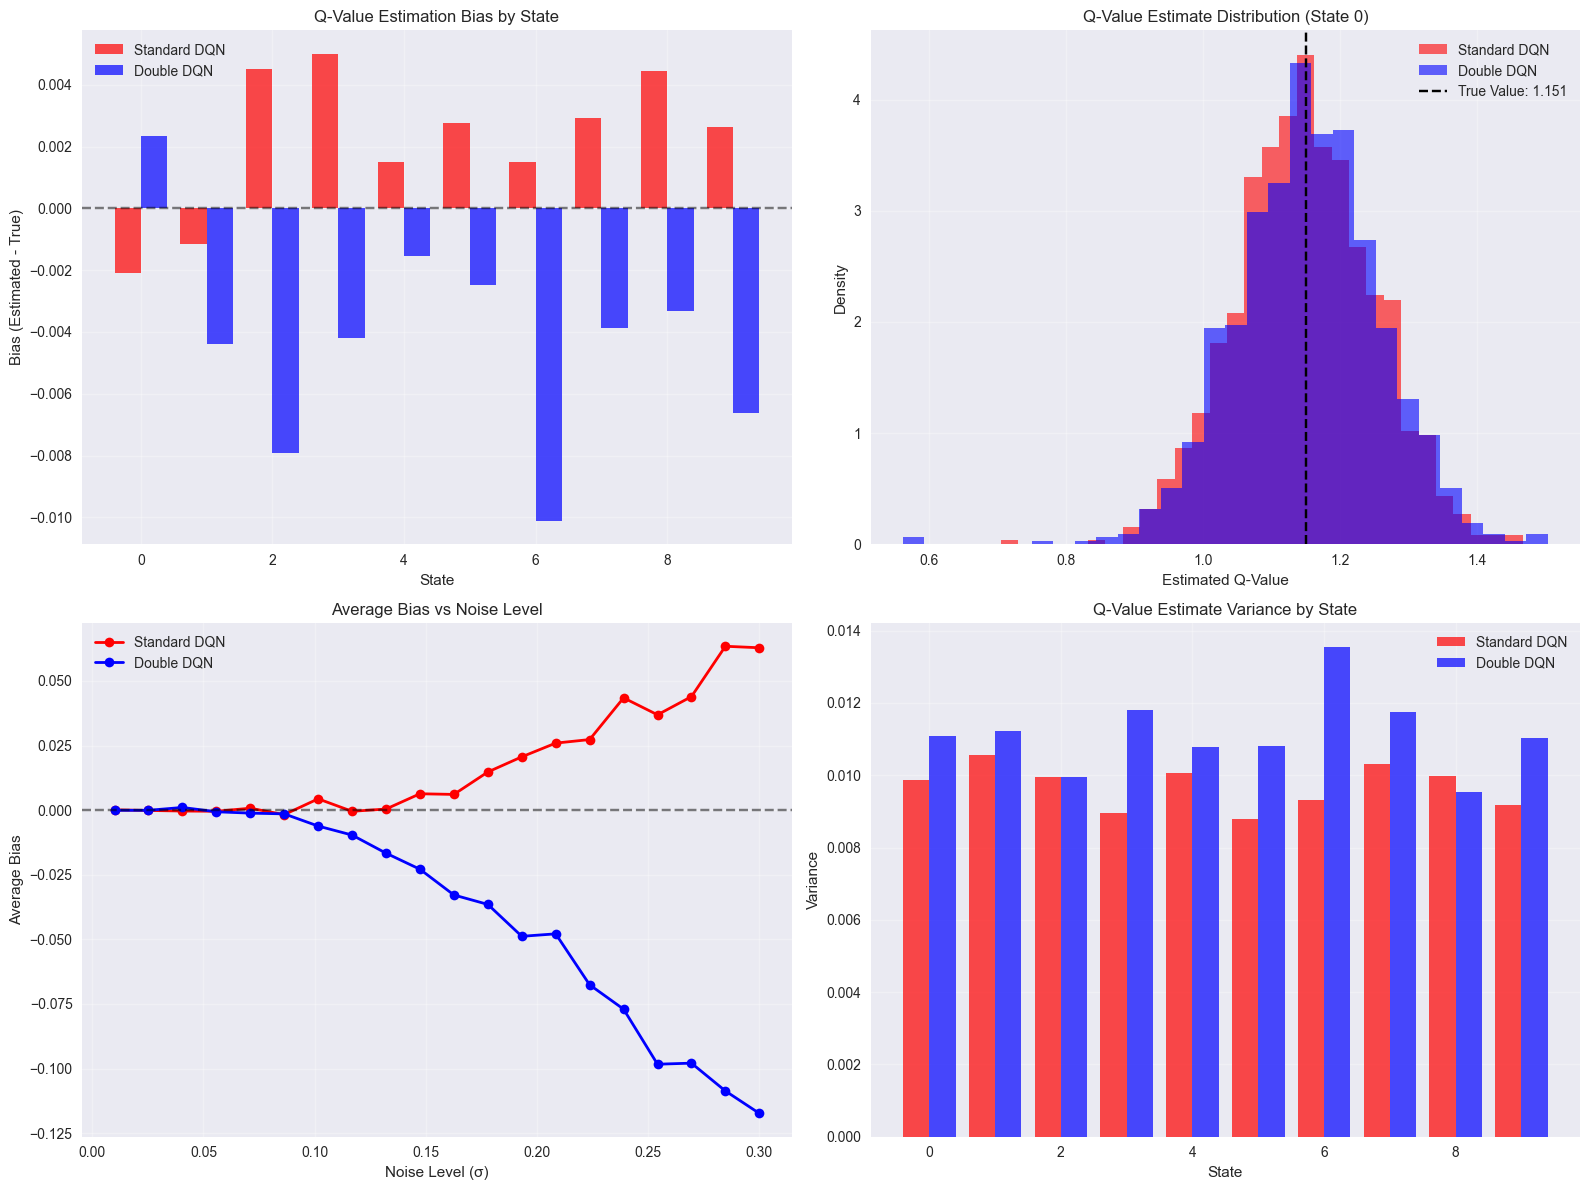

Overestimation Bias Analysis Summary:
Average Standard DQN Bias: 0.0022
Average Double DQN Bias: -0.0042
Bias Reduction: 0.0064
Standard DQN Variance: 0.0097
Double DQN Variance: 0.0111
\n✓ Double DQN implemented
✓ Overestimation bias analysis complete
✓ Comparison framework ready


In [6]:

class DoubleDQNAgent(DQNAgent):
    """Double DQN agent that addresses overestimation bias"""
    
    def __init__(self, state_size, action_size, **kwargs):
        super().__init__(state_size, action_size, **kwargs)
        self.agent_type = "Double DQN"
        
        self.q_value_estimates = []
        self.target_values = []
    
    def train_step(self):
        """Double DQN training step with bias correction"""
        if len(self.memory) < self.batch_size:
            return None
        
        experiences = self.memory.sample(self.batch_size)
        batch = self.experience_to_batch(experiences)
        
        states, actions, rewards, next_states, dones = batch
        
        current_q_values = self.q_network(states).gather(1, actions)
        
        with torch.no_grad():
            next_actions = self.q_network(next_states).argmax(1, keepdim=True)
            next_q_values = self.target_network(next_states).gather(1, next_actions)
            target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        
        loss = F.mse_loss(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        
        self.step_count += 1
        if self.step_count % self.target_update_freq == 0:
            self.update_target_network()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        self.losses.append(loss.item())
        avg_q_value = current_q_values.mean().item()
        avg_target = target_q_values.mean().item()
        
        self.q_values.append(avg_q_value)
        self.q_value_estimates.append(avg_q_value)
        self.target_values.append(avg_target)
        
        return loss.item()

class OverestimationAnalysis:
    """Analyze and demonstrate overestimation bias in DQN vs Double DQN"""
    
    def __init__(self):
        self.results = {}
    
    def create_synthetic_environment(self, n_states=10, n_actions=5, noise_level=0.1):
        """Create synthetic environment to study overestimation"""
        true_q_values = np.random.uniform(0, 1, (n_states, n_actions))
        
        for s in range(n_states):
            best_action = np.argmax(true_q_values[s])
            true_q_values[s, best_action] += 0.2  # Boost best action
        
        return true_q_values, noise_level
    
    def simulate_estimation_bias(self, true_q_values, noise_level, n_estimates=1000):
        """Simulate Q-value estimation with noise"""
        n_states, n_actions = true_q_values.shape
        
        standard_estimates = []
        double_estimates = []
        
        for _ in range(n_estimates):
            noisy_q1 = true_q_values + np.random.normal(0, noise_level, true_q_values.shape)
            noisy_q2 = true_q_values + np.random.normal(0, noise_level, true_q_values.shape)
            
            standard_max = np.max(noisy_q1, axis=1)
            standard_estimates.append(standard_max)
            
            selected_actions = np.argmax(noisy_q1, axis=1)
            double_values = noisy_q2[np.arange(n_states), selected_actions]
            double_estimates.append(double_values)
        
        standard_estimates = np.array(standard_estimates)
        double_estimates = np.array(double_estimates)
        
        true_optimal = np.max(true_q_values, axis=1)
        
        return {
            'true_optimal': true_optimal,
            'standard_estimates': standard_estimates,
            'double_estimates': double_estimates,
            'standard_bias': np.mean(standard_estimates, axis=0) - true_optimal,
            'double_bias': np.mean(double_estimates, axis=0) - true_optimal
        }
    
    def visualize_bias_analysis(self):
        """Visualize overestimation bias comparison"""
        true_q_values, noise_level = self.create_synthetic_environment()
        bias_results = self.simulate_estimation_bias(true_q_values, noise_level)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        states = range(len(bias_results['true_optimal']))
        
        axes[0,0].bar([s-0.2 for s in states], bias_results['standard_bias'], 
                     width=0.4, label='Standard DQN', alpha=0.7, color='red')
        axes[0,0].bar([s+0.2 for s in states], bias_results['double_bias'], 
                     width=0.4, label='Double DQN', alpha=0.7, color='blue')
        axes[0,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[0,0].set_title('Q-Value Estimation Bias by State')
        axes[0,0].set_xlabel('State')
        axes[0,0].set_ylabel('Bias (Estimated - True)')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        state_0_standard = bias_results['standard_estimates'][:, 0]
        state_0_double = bias_results['double_estimates'][:, 0]
        true_value_0 = bias_results['true_optimal'][0]
        
        axes[0,1].hist(state_0_standard, bins=30, alpha=0.6, label='Standard DQN', 
                      color='red', density=True)
        axes[0,1].hist(state_0_double, bins=30, alpha=0.6, label='Double DQN', 
                      color='blue', density=True)
        axes[0,1].axvline(true_value_0, color='black', linestyle='--', 
                         label=f'True Value: {true_value_0:.3f}')
        axes[0,1].set_title('Q-Value Estimate Distribution (State 0)')
        axes[0,1].set_xlabel('Estimated Q-Value')
        axes[0,1].set_ylabel('Density')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        noise_levels = np.linspace(0.01, 0.3, 20)
        standard_biases = []
        double_biases = []
        
        for noise in noise_levels:
            results = self.simulate_estimation_bias(true_q_values, noise, 200)
            standard_biases.append(np.mean(results['standard_bias']))
            double_biases.append(np.mean(results['double_bias']))
        
        axes[1,0].plot(noise_levels, standard_biases, 'o-', label='Standard DQN', 
                      color='red', linewidth=2)
        axes[1,0].plot(noise_levels, double_biases, 'o-', label='Double DQN', 
                      color='blue', linewidth=2)
        axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1,0].set_title('Average Bias vs Noise Level')
        axes[1,0].set_xlabel('Noise Level (σ)')
        axes[1,0].set_ylabel('Average Bias')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        standard_vars = np.var(bias_results['standard_estimates'], axis=0)
        double_vars = np.var(bias_results['double_estimates'], axis=0)
        
        axes[1,1].bar([s-0.2 for s in states], standard_vars, 
                     width=0.4, label='Standard DQN', alpha=0.7, color='red')
        axes[1,1].bar([s+0.2 for s in states], double_vars, 
                     width=0.4, label='Double DQN', alpha=0.7, color='blue')
        axes[1,1].set_title('Q-Value Estimate Variance by State')
        axes[1,1].set_xlabel('State')
        axes[1,1].set_ylabel('Variance')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("Overestimation Bias Analysis Summary:")
        print("=" * 50)
        print(f"Average Standard DQN Bias: {np.mean(bias_results['standard_bias']):.4f}")
        print(f"Average Double DQN Bias: {np.mean(bias_results['double_bias']):.4f}")
        print(f"Bias Reduction: {(np.mean(bias_results['standard_bias']) - np.mean(bias_results['double_bias'])):.4f}")
        print(f"Standard DQN Variance: {np.mean(standard_vars):.4f}")
        print(f"Double DQN Variance: {np.mean(double_vars):.4f}")
        
        return bias_results

class DQNComparison:
    """Compare Standard DQN vs Double DQN performance"""
    
    def __init__(self, env, state_size, action_size):
        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        
    def run_comparison(self, num_episodes=500, num_runs=3):
        """Run comparison between Standard DQN and Double DQN"""
        print("Starting DQN vs Double DQN Comparison...")
        print("=" * 60)
        
        standard_results = []
        double_results = []
        
        for run in range(num_runs):
            print(f"\\nRun {run + 1}/{num_runs}")
            
            print("Training Standard DQN...")
            standard_agent = DQNAgent(self.state_size, self.action_size,
                                    lr=0.0005, target_update_freq=1000)
            standard_scores, _ = standard_agent.train(self.env, num_episodes, 
                                                    print_every=num_episodes//5)
            standard_results.append(standard_scores)
            
            print("Training Double DQN...")
            double_agent = DoubleDQNAgent(self.state_size, self.action_size,
                                        lr=0.0005, target_update_freq=1000)
            double_scores, _ = double_agent.train(self.env, num_episodes, 
                                                print_every=num_episodes//5)
            double_results.append(double_scores)
        
        return standard_results, double_results, standard_agent, double_agent
    
    def visualize_comparison(self, standard_results, double_results):
        """Visualize comparison results"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        
        standard_mean = np.mean(standard_results, axis=0)
        double_mean = np.mean(double_results, axis=0)
        standard_std = np.std(standard_results, axis=0)
        double_std = np.std(double_results, axis=0)
        
        episodes = range(len(standard_mean))
        
        axes[0,0].plot(episodes, standard_mean, color='red', label='Standard DQN', linewidth=2)
        axes[0,0].fill_between(episodes, standard_mean - standard_std, 
                              standard_mean + standard_std, alpha=0.3, color='red')
        
        axes[0,0].plot(episodes, double_mean, color='blue', label='Double DQN', linewidth=2)
        axes[0,0].fill_between(episodes, double_mean - double_std, 
                              double_mean + double_std, alpha=0.3, color='blue')
        
        axes[0,0].set_title('Learning Curves Comparison')
        axes[0,0].set_xlabel('Episode')
        axes[0,0].set_ylabel('Episode Reward')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        final_standard = [scores[-50:] for scores in standard_results]
        final_double = [scores[-50:] for scores in double_results]
        
        final_standard_flat = [score for run in final_standard for score in run]
        final_double_flat = [score for run in final_double for score in run]
        
        axes[0,1].boxplot([final_standard_flat, final_double_flat], 
                         labels=['Standard DQN', 'Double DQN'])
        axes[0,1].set_title('Final Performance Distribution')
        axes[0,1].set_ylabel('Episode Reward')
        axes[0,1].grid(True, alpha=0.3)
        
        convergence_threshold = np.mean(double_mean[-100:]) * 0.9  # 90% of final performance
        
        standard_convergence = []
        double_convergence = []
        
        for standard_scores in standard_results:
            conv_episode = next((i for i, score in enumerate(standard_scores) 
                               if score >= convergence_threshold), len(standard_scores))
            standard_convergence.append(conv_episode)
        
        for double_scores in double_results:
            conv_episode = next((i for i, score in enumerate(double_scores) 
                               if score >= convergence_threshold), len(double_scores))
            double_convergence.append(conv_episode)
        
        axes[1,0].bar(['Standard DQN', 'Double DQN'], 
                     [np.mean(standard_convergence), np.mean(double_convergence)],
                     color=['red', 'blue'], alpha=0.7)
        axes[1,0].set_title('Convergence Speed')
        axes[1,0].set_ylabel('Episodes to Convergence')
        axes[1,0].grid(True, alpha=0.3)
        
        improvement_window = 50
        standard_improvement = []
        double_improvement = []
        
        for i in range(improvement_window, len(episodes)):
            std_improvement = np.mean(standard_mean[i-improvement_window:i]) - np.mean(standard_mean[:improvement_window])
            dbl_improvement = np.mean(double_mean[i-improvement_window:i]) - np.mean(double_mean[:improvement_window])
            standard_improvement.append(std_improvement)
            double_improvement.append(dbl_improvement)
        
        imp_episodes = range(improvement_window, len(episodes))
        axes[1,1].plot(imp_episodes, standard_improvement, color='red', 
                      label='Standard DQN', linewidth=2)
        axes[1,1].plot(imp_episodes, double_improvement, color='blue', 
                      label='Double DQN', linewidth=2)
        axes[1,1].set_title('Cumulative Improvement')
        axes[1,1].set_xlabel('Episode')
        axes[1,1].set_ylabel('Improvement from Baseline')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

print("Analyzing Overestimation Bias...")
bias_analysis = OverestimationAnalysis()
bias_results = bias_analysis.visualize_bias_analysis()

print("\\n✓ Double DQN implemented")
print("✓ Overestimation bias analysis complete")
print("✓ Comparison framework ready")


# Part 4: Dueling Dqn Architecture

## 4.1 Motivation for Dueling Networks

**Standard DQN**: Single stream estimates Q(s,a) directly.

**Problem**: In many states, it's unnecessary to estimate the value of every action.

**Key Insight**: Decompose Q-function into state value and action advantage:
```
Q(s,a) = V(s) + A(s,a)
```

Where:
- **V(s)**: State value function - "How good is it to be in state s?"
- **A(s,a)**: Advantage function - "How much better is action a compared to others?"

## 4.2 the Dueling Architecture

**Standard DQN Architecture:**
```
State → Conv/FC → Hidden → Q-values
```

**Dueling DQN Architecture:**
```
State → Conv/FC → Shared Features → Split into:
                                   ├── Value Stream → V(s)
                                   └── Advantage Stream → A(s,a)
```

**Final Combination:**
```
Q(s,a) = V(s) + A(s,a) - mean(A(s,·))
```

### 4.2.1 Why Subtract the Mean?

**Identifiability Problem**: V(s) + A(s,a) = V'(s) + A'(s,a) where V'(s) = V(s) + C and A'(s,a) = A(s,a) - C

**Solution**: Force advantage to have zero mean:
```
Q(s,a) = V(s) + [A(s,a) - (1/|A|)∑_a' A(s,a')]
```

This ensures unique decomposition and stable learning.

### 4.2.2 Alternative Formulations

**Max Formulation:**
```
Q(s,a) = V(s) + A(s,a) - max_a' A(s,a')
```

**Advantage**: Makes the best action have advantage exactly 0.
**Disadvantage**: Less stable gradients due to non-differentiable max.

## 4.3 Benefits of Dueling Architecture

### 4.3.1 Learning Efficiency

**State Value Learning**: V(s) can be learned from any action taken in state s.
- More data-efficient value learning
- Better generalization across actions
- Faster convergence in many environments

**Action Advantage Learning**: A(s,a) focuses on relative action quality.
- Cleaner learning signal for action selection
- Better handling of irrelevant actions
- More robust to action space size

### 4.3.2 When Dueling Helps Most

**Environments where dueling excels:**
- Many actions have similar values
- State value is more important than action differences
- Sparse rewards (state value provides better signal)
- Navigation tasks (many actions lead to similar outcomes)

**Examples:**
- Atari games (many actions don't affect immediate outcome)
- Grid worlds (most actions are fine, few are critical)
- Continuous control (many actions are nearly equivalent)

## 4.4 Implementation Details

### 4.4.1 Network Architecture

**Shared Feature Extraction:**
- Same as standard DQN (conv/FC layers)
- Features are shared between value and advantage streams
- Reduces parameters while enabling specialization

**Value Stream:**
- Typically single output: V(s)
- Often smaller than advantage stream
- Can use different activation functions

**Advantage Stream:**
- Outputs advantage for each action: A(s,a)
- Same size as action space
- Usually similar architecture to standard DQN head

### 4.4.2 Training Considerations

**Gradient Flow:**
- Both streams contribute to final Q-value gradients
- Advantage stream gets more direct action-selection signal
- Value stream gets broader state-evaluation signal

**Initialization:**
- Important to initialize advantage stream near zero
- Value stream can use standard initialization
- Helps with early training stability

**Learning Rates:**
- Can use different learning rates for different streams
- Often advantage stream benefits from higher learning rate
- Value stream may need more conservative updates

## 4.5 Theoretical Properties

### 4.5.1 Approximation Quality

**Representation Power:**
- Dueling architecture is strictly more expressive than standard DQN
- Can represent any Q-function that standard DQN can
- Plus additional structural constraints that may help learning

**Generalization:**
- Value function provides better generalization across actions
- Advantage function focuses learning on action differences
- Combined effect often leads to better sample efficiency

### 4.5.2 Convergence Properties

**Stability:**
- Mean subtraction provides stable decomposition
- Prevents drift in value/advantage estimates
- More stable than naive V(s) + A(s,a) combination

**Convergence Speed:**
- Often faster convergence than standard DQN
- Particularly in environments with clear state value structure
- May be slower in environments where all actions are very different

## 4.6 Combination with Other Techniques

**Dueling + Double DQN:**
- Complementary improvements
- Dueling addresses representation, Double addresses bias
- Often combined in practice

**Dueling + Prioritized Replay:**
- Dueling provides better Q-estimates for prioritization
- Prioritization helps dueling focus on important transitions
- Synergistic combination

**Dueling + Target Networks:**
- Standard target network approach applies directly
- Both value and advantage streams use target networks
- No additional complexity

Creating Dueling DQN Analysis...


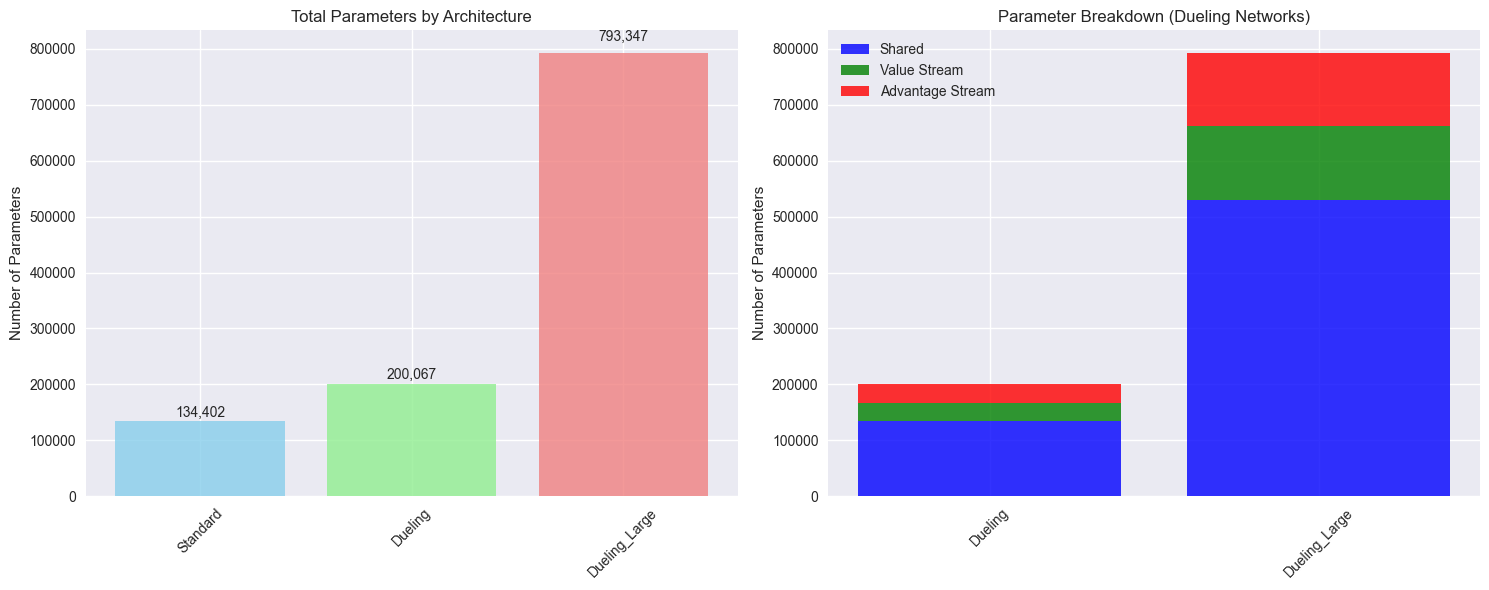

\n✓ Dueling DQN architecture implemented
✓ Value-advantage decomposition analysis ready
✓ Architecture comparison framework created
✓ Parameter efficiency analysis complete


In [7]:

class DuelingDQN(nn.Module):
    """Dueling DQN architecture separating value and advantage streams"""
    
    def __init__(self, state_size, action_size, hidden_sizes=[512, 256], 
                 value_hidden=128, advantage_hidden=128, dropout=0.1):
        super(DuelingDQN, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        
        shared_layers = []
        input_size = state_size
        
        for hidden_size in hidden_sizes:
            shared_layers.extend([
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            input_size = hidden_size
        
        self.shared_features = nn.Sequential(*shared_layers)
        final_shared_size = hidden_sizes[-1]
        
        self.value_stream = nn.Sequential(
            nn.Linear(final_shared_size, value_hidden),
            nn.ReLU(),
            nn.Linear(value_hidden, 1)
        )
        
        self.advantage_stream = nn.Sequential(
            nn.Linear(final_shared_size, advantage_hidden),
            nn.ReLU(),
            nn.Linear(advantage_hidden, action_size)
        )
        
        self.apply(self._init_weights)
    
    def _init_weights(self, layer):
        """Initialize network weights"""
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.01)
    
    def forward(self, state):
        """Forward pass through dueling architecture"""
        shared_features = self.shared_features(state)
        
        value = self.value_stream(shared_features)
        advantage = self.advantage_stream(shared_features)
        
        advantage_mean = advantage.mean(dim=1, keepdim=True)
        q_values = value + advantage - advantage_mean
        
        return q_values, value, advantage

class DuelingConvDQN(nn.Module):
    """Dueling DQN with convolutional layers for image inputs"""
    
    def __init__(self, action_size, input_channels=4):
        super(DuelingConvDQN, self).__init__()
        self.action_size = action_size
        
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        conv_out_size = 64 * 7 * 7
        
        self.shared_fc = nn.Linear(conv_out_size, 512)
        
        self.value_stream = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        
        self.advantage_stream = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = x.view(x.size(0), -1)
        shared_features = F.relu(self.shared_fc(x))
        
        value = self.value_stream(shared_features)
        advantage = self.advantage_stream(shared_features)
        
        advantage_mean = advantage.mean(dim=1, keepdim=True)
        q_values = value + advantage - advantage_mean
        
        return q_values, value, advantage

class DuelingDQNAgent(DoubleDQNAgent):
    """Dueling DQN agent combining dueling architecture with Double DQN"""
    
    def __init__(self, state_size, action_size, **kwargs):
        super().__init__(state_size, action_size, **kwargs)
        self.agent_type = "Dueling Double DQN"
        
        self.q_network = DuelingDQN(state_size, action_size).to(device)
        self.target_network = DuelingDQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.lr)
        
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        self.value_estimates = []
        self.advantage_estimates = []
    
    def train_step(self):
        """Dueling Double DQN training step"""
        if len(self.memory) < self.batch_size:
            return None
        
        experiences = self.memory.sample(self.batch_size)
        batch = self.experience_to_batch(experiences)
        states, actions, rewards, next_states, dones = batch
        
        current_q_values, current_values, current_advantages = self.q_network(states)
        current_q_values = current_q_values.gather(1, actions)
        
        with torch.no_grad():
            next_q_online, _, _ = self.q_network(next_states)
            next_actions = next_q_online.argmax(1, keepdim=True)
            
            next_q_target, _, _ = self.target_network(next_states)
            next_q_values = next_q_target.gather(1, next_actions)
            
            target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        
        loss = F.mse_loss(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        
        self.step_count += 1
        if self.step_count % self.target_update_freq == 0:
            self.update_target_network()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        self.losses.append(loss.item())
        self.q_values.append(current_q_values.mean().item())
        self.value_estimates.append(current_values.mean().item())
        self.advantage_estimates.append(current_advantages.abs().mean().item())
        
        return loss.item()

class DuelingAnalysis:
    """Analyze dueling architecture properties and benefits"""
    
    def __init__(self):
        self.results = {}
    
    def analyze_value_advantage_decomposition(self, agent, env, num_episodes=50):
        """Analyze how dueling network decomposes Q-values"""
        if not isinstance(agent.q_network, DuelingDQN):
            print("Agent must use DuelingDQN for this analysis")
            return
        
        states_data = []
        q_values_data = []
        values_data = []
        advantages_data = []
        rewards_data = []
        
        for episode in range(num_episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            episode_reward = 0
            
            while True:
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                with torch.no_grad():
                    q_vals, value, advantage = agent.q_network(state_tensor)
                
                states_data.append(state.copy())
                q_values_data.append(q_vals.cpu().numpy()[0])
                values_data.append(value.cpu().numpy()[0, 0])
                advantages_data.append(advantage.cpu().numpy()[0])
                
                action = agent.get_action(state, training=False)
                next_state, reward, done, truncated, _ = env.step(action)
                
                episode_reward += reward
                state = next_state
                
                if done or truncated:
                    break
            
            rewards_data.append(episode_reward)
        
        return {
            'states': np.array(states_data),
            'q_values': np.array(q_values_data),
            'values': np.array(values_data),
            'advantages': np.array(advantages_data),
            'episode_rewards': rewards_data
        }
    
    def visualize_dueling_components(self, decomposition_data):
        """Visualize value and advantage decomposition"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        q_values = decomposition_data['q_values']
        values = decomposition_data['values']
        advantages = decomposition_data['advantages']
        
        axes[0,0].hist(q_values.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
        axes[0,0].set_title('Q-Value Distribution')
        axes[0,0].set_xlabel('Q-Value')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].grid(True, alpha=0.3)
        
        axes[0,1].hist(values, bins=50, alpha=0.7, color='green', edgecolor='black')
        axes[0,1].set_title('State Value Distribution')
        axes[0,1].set_xlabel('V(s)')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].grid(True, alpha=0.3)
        
        axes[0,2].hist(advantages.flatten(), bins=50, alpha=0.7, color='red', edgecolor='black')
        axes[0,2].axvline(0, color='black', linestyle='--', alpha=0.7, label='Zero Mean')
        axes[0,2].set_title('Advantage Distribution')
        axes[0,2].set_xlabel('A(s,a)')
        axes[0,2].set_ylabel('Frequency')
        axes[0,2].legend()
        axes[0,2].grid(True, alpha=0.3)
        
        max_q_values = np.max(q_values, axis=1)
        correlation = np.corrcoef(values, max_q_values)[0, 1]
        
        axes[1,0].scatter(values, max_q_values, alpha=0.6, s=20)
        axes[1,0].plot([values.min(), values.max()], [values.min(), values.max()], 
                      'r--', alpha=0.8, label=f'Perfect Correlation')
        axes[1,0].set_title(f'Value vs Max Q-Value\\n(Correlation: {correlation:.3f})')
        axes[1,0].set_xlabel('State Value V(s)')
        axes[1,0].set_ylabel('Max Q-Value')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        advantage_ranges = np.max(advantages, axis=1) - np.min(advantages, axis=1)
        time_steps = range(len(advantage_ranges))
        
        axes[1,1].plot(time_steps, advantage_ranges, alpha=0.7, color='orange')
        axes[1,1].set_title('Advantage Range Over Time')
        axes[1,1].set_xlabel('Time Step')
        axes[1,1].set_ylabel('Advantage Range (Max - Min)')
        axes[1,1].grid(True, alpha=0.3)
        
        reconstructed_q = values.reshape(-1, 1) + advantages - advantages.mean(axis=1, keepdims=True)
        reconstruction_error = np.abs(q_values - reconstructed_q).mean(axis=1)
        
        axes[1,2].hist(reconstruction_error, bins=30, alpha=0.7, color='purple', edgecolor='black')
        axes[1,2].set_title('Q-Value Reconstruction Error')
        axes[1,2].set_xlabel('|Q_actual - Q_reconstructed|')
        axes[1,2].set_ylabel('Frequency')
        axes[1,2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("Dueling Architecture Analysis:")
        print("=" * 40)
        print(f"Average State Value: {np.mean(values):.3f} ± {np.std(values):.3f}")
        print(f"Average |Advantage|: {np.mean(np.abs(advantages)):.3f}")
        print(f"Advantage Mean (should be ~0): {np.mean(advantages):.6f}")
        print(f"Value-MaxQ Correlation: {correlation:.3f}")
        print(f"Reconstruction Error: {np.mean(reconstruction_error):.6f}")
        
        return {
            'correlation': correlation,
            'advantage_mean': np.mean(advantages),
            'reconstruction_error': np.mean(reconstruction_error)
        }

class ArchitectureComparison:
    """Compare Standard DQN vs Dueling DQN architectures"""
    
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        
    def create_test_networks(self):
        """Create different network architectures for comparison"""
        networks = {
            'Standard': DQN(self.state_size, self.action_size),
            'Dueling': DuelingDQN(self.state_size, self.action_size),
            'Dueling_Large': DuelingDQN(self.state_size, self.action_size, 
                                      hidden_sizes=[1024, 512], 
                                      value_hidden=256, advantage_hidden=256)
        }
        
        return networks
    
    def analyze_parameter_efficiency(self):
        """Analyze parameter efficiency of different architectures"""
        networks = self.create_test_networks()
        
        analysis = {}
        for name, network in networks.items():
            total_params = sum(p.numel() for p in network.parameters())
            
            if hasattr(network, 'shared_features'):
                shared_params = sum(p.numel() for p in network.shared_features.parameters())
                value_params = sum(p.numel() for p in network.value_stream.parameters())
                advantage_params = sum(p.numel() for p in network.advantage_stream.parameters())
                
                analysis[name] = {
                    'total_params': total_params,
                    'shared_params': shared_params,
                    'value_params': value_params,
                    'advantage_params': advantage_params,
                    'architecture': 'Dueling'
                }
            else:
                analysis[name] = {
                    'total_params': total_params,
                    'architecture': 'Standard'
                }
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        names = list(analysis.keys())
        total_params = [analysis[name]['total_params'] for name in names]
        colors = ['skyblue', 'lightgreen', 'lightcoral']
        
        bars = axes[0].bar(names, total_params, color=colors, alpha=0.8)
        axes[0].set_title('Total Parameters by Architecture')
        axes[0].set_ylabel('Number of Parameters')
        axes[0].tick_params(axis='x', rotation=45)
        
        for bar, params in zip(bars, total_params):
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height*1.02,
                        f'{params:,}', ha='center', va='bottom', fontsize=10)
        
        dueling_networks = {k: v for k, v in analysis.items() if 'shared_params' in v}
        
        if dueling_networks:
            breakdown_data = []
            labels = []
            
            for name, data in dueling_networks.items():
                breakdown_data.append([
                    data['shared_params'], 
                    data['value_params'], 
                    data['advantage_params']
                ])
                labels.append(name)
            
            breakdown_data = np.array(breakdown_data)
            
            bottom_shared = breakdown_data[:, 0]
            bottom_value = bottom_shared + breakdown_data[:, 1]
            
            axes[1].bar(labels, breakdown_data[:, 0], label='Shared', alpha=0.8, color='blue')
            axes[1].bar(labels, breakdown_data[:, 1], bottom=breakdown_data[:, 0], 
                       label='Value Stream', alpha=0.8, color='green')
            axes[1].bar(labels, breakdown_data[:, 2], bottom=bottom_value,
                       label='Advantage Stream', alpha=0.8, color='red')
            
            axes[1].set_title('Parameter Breakdown (Dueling Networks)')
            axes[1].set_ylabel('Number of Parameters')
            axes[1].legend()
            axes[1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        return analysis

print("Creating Dueling DQN Analysis...")

arch_comparison = ArchitectureComparison(state_size=4, action_size=2)
param_analysis = arch_comparison.analyze_parameter_efficiency()

dueling_analysis = DuelingAnalysis()

print("\\n✓ Dueling DQN architecture implemented")
print("✓ Value-advantage decomposition analysis ready")
print("✓ Architecture comparison framework created")
print("✓ Parameter efficiency analysis complete")


# Part 5: Prioritized Experience Replay

## 5.1 Motivation for Prioritized Replay

**Standard Experience Replay**: Uniformly sample from replay buffer.

**Problem**: Not all experiences are equally valuable for learning.

**Key Insights:**
- Some transitions contain more learning signal (higher TD error)
- Rare or surprising experiences should be seen more often
- Uniform sampling may waste computation on redundant experiences

**Solution**: Sample experiences with probability proportional to their learning priority.

## 5.2 Prioritized Replay Mechanism

### 5.2.1 Priority Definition

**TD Error Priority**: Use magnitude of TD error as priority measure.
```
pi = |δi| + ε
```

Where:
- δi = ri + γ max_a' Q(si+1,a') - Q(si,ai)
- ε is small constant to ensure non-zero probability

**Why TD Error?**
- High TD error → model prediction is wrong → more to learn
- Low TD error → model prediction is accurate → less to learn
- Natural measure of "surprise" or learning potential

### 5.2.2 Sampling Probability

**Proportional Prioritization:**
```
P(i) = pi^α / Σ_k pk^α
```

Where α controls prioritization strength:
- α = 0: Uniform sampling (standard replay)
- α = 1: Full prioritization
- α ∈ (0,1): Balance between uniform and full prioritization

### 5.2.3 Importance Sampling Correction

**Problem**: Prioritized sampling introduces bias.

**Solution**: Use importance sampling weights to correct bias.
```
wi = (1/N × 1/P(i))^β
```

Where β controls bias correction:
- β = 0: No bias correction
- β = 1: Full bias correction
- β typically annealed from low to high during training

**Normalized Weights:**
```
wi = wi / max_j wj
```

## 5.3 Implementation Strategies

### 5.3.1 Sum Tree Data Structure

**Challenge**: Efficient sampling with changing priorities.

**Solution**: Use sum tree (binary heap) for O(log n) operations.

**Sum Tree Properties:**
- Leaf nodes: store priorities
- Internal nodes: sum of children
- Root: total sum of all priorities
- Sampling: traverse tree based on random value

**Operations:**
- **Update**: O(log n) to change priority
- **Sample**: O(log n) to sample based on priority
- **Insert**: O(log n) to add new experience

### 5.3.2 Rank-based Prioritization

**Alternative**: Rank experiences by TD error, sample based on rank.
```
P(i) = 1/rank(i)
```

**Benefits:**
- More robust to outliers
- Stable priority distribution
- Easier hyperparameter tuning

**Drawbacks:**
- Requires sorting (more expensive)
- Less direct connection to learning signal

## 5.4 Prioritized Replay Algorithm

**Modified DQN with Prioritized Replay:**

```
Initialize prioritized replay buffer D
for episode in episodes:
    for step in episode:
        Select action and observe transition (s,a,r,s')
        
        # Compute initial priority
        δ = |r + γ max_a' Q(s',a') - Q(s,a)|
        priority = δ + ε
        
        # Store with priority
        D.add(s,a,r,s', priority)
        
        # Sample batch with priorities
        batch, indices, weights = D.sample(batch_size, β)
        
        # Compute TD errors
        δ*batch = compute*td_errors(batch)
        
        # Update priorities
        D.update*priorities(indices, |δ*batch| + ε)
        
        # Update network with importance sampling weights
        loss = (weights * δ_batch²).mean()
        optimize(loss)
```

## 5.5 Hyperparameter Considerations

### 5.5.1 Priority Exponent (α)

**α = 0.6** typically works well
- Higher α: More prioritization, less diversity
- Lower α: Less prioritization, more diversity
- Environment dependent optimization

### 5.5.2 Importance Sampling Exponent (β)

**β Schedule**: Start low (0.4), anneal to 1.0
- Early training: Less bias correction (faster learning)
- Later training: More bias correction (stable convergence)

### 5.5.3 Other Parameters

**ε = 1e-6**: Ensures non-zero priorities
**Priority clipping**: Prevent extremely high priorities
**Update frequency**: How often to update priorities

## 5.6 Benefits and Challenges

### 5.6.1 Benefits

**Sample Efficiency:**
- 30-50% improvement in many environments
- Faster learning from important experiences
- Better handling of rare events

**Learning Quality:**
- Focus on mistakes and surprises
- Better exploration of difficult transitions
- More stable learning in some cases

### 5.6.2 Challenges

**Computational Overhead:**
- Sum tree operations
- Priority updates
- Importance sampling calculations

**Hyperparameter Sensitivity:**
- More hyperparameters to tune
- Environment-dependent optimal settings
- Interaction with other hyperparameters

**Implementation Complexity:**
- More complex data structures
- Careful handling of priorities
- Memory overhead for storing priorities

## 5.7 Variants and Extensions

### 5.7.1 Multi-step Prioritization

Combine with n-step returns for better priority estimates:
```
δ = |Σ(t=0 to n-1) γ^t rt+1 + γ^n Q(st+n,at+n) - Q(st,at)|
```

### 5.7.2 Distributional Prioritization

Use distributional RL metrics for priority:
- Wasserstein distance between distributions
- KL divergence for priority calculation

### 5.7.3 Curiosity-driven Prioritization

Combine TD error with curiosity/novelty measures:
- Prediction error from forward models
- Information gain metrics
- Exploration bonuses

In [8]:

import numpy as np
from collections import namedtuple
import random

class SumTree:
    """
    Sum Tree data structure for efficient prioritized sampling.
    
    Binary heap where parent nodes contain sum of children.
    Enables O(log n) sampling and updating.
    """
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)  # Internal + leaf nodes
        self.data = np.zeros(capacity, dtype=object)  # Store experiences
        self.data_pointer = 0
        self.size = 0
        
    def add(self, priority, data):
        """Add experience with given priority."""
        tree_idx = self.data_pointer + self.capacity - 1
        
        self.data[self.data_pointer] = data
        
        self.update(tree_idx, priority)
        
        self.data_pointer = (self.data_pointer + 1) % self.capacity
        if self.size < self.capacity:
            self.size += 1
    
    def update(self, tree_idx, priority):
        """Update priority of specific tree node."""
        change = priority - self.tree[tree_idx]
        self.tree[tree_idx] = priority
        
        while tree_idx != 0:
            tree_idx = (tree_idx - 1) // 2
            self.tree[tree_idx] += change
    
    def get_leaf(self, value):
        """
        Retrieve leaf node for given cumulative value.
        Used for prioritized sampling.
        """
        parent_idx = 0
        
        while True:
            left_child_idx = 2 * parent_idx + 1
            right_child_idx = left_child_idx + 1
            
            if left_child_idx >= len(self.tree):
                leaf_idx = parent_idx
                break
            else:
                if value <= self.tree[left_child_idx]:
                    parent_idx = left_child_idx
                else:
                    value -= self.tree[left_child_idx]
                    parent_idx = right_child_idx
        
        data_idx = leaf_idx - self.capacity + 1
        return leaf_idx, self.tree[leaf_idx], self.data[data_idx]
    
    @property
    def total_priority(self):
        """Return sum of all priorities (root node)."""
        return self.tree[0]

class PrioritizedReplayBuffer:
    """
    Prioritized Experience Replay Buffer using Sum Tree.
    
    Samples experiences based on their TD error priorities.
    Applies importance sampling correction for unbiased learning.
    """
    
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001, epsilon=1e-6):
        """
        Initialize prioritized replay buffer.
        
        Args:
            capacity: Maximum buffer size
            alpha: Priority exponent (0 = uniform, 1 = full prioritization)
            beta: Importance sampling exponent (0 = no correction, 1 = full correction)
            beta_increment: Beta annealing rate
            epsilon: Small constant to ensure non-zero priorities
        """
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta
        self.beta_increment = beta_increment
        self.epsilon = epsilon
        
        self.tree = SumTree(capacity)
        self.max_priority = 1.0
        
        self.Experience = namedtuple('Experience', 
                                   ['state', 'action', 'reward', 'next_state', 'done'])
    
    def add(self, state, action, reward, next_state, done):
        """Add experience with maximum priority."""
        experience = self.Experience(state, action, reward, next_state, done)
        
        priority = self.max_priority ** self.alpha
        self.tree.add(priority, experience)
    
    def sample(self, batch_size):
        """
        Sample batch with prioritized probabilities.
        
        Returns:
            batch: List of experiences
            indices: Tree indices for priority updates
            weights: Importance sampling weights
        """
        batch = []
        indices = []
        priorities = []
        segment = self.tree.total_priority / batch_size
        
        self.beta = min(1.0, self.beta + self.beta_increment)
        
        for i in range(batch_size):
            left = segment * i
            right = segment * (i + 1)
            sample_value = random.uniform(left, right)
            
            tree_idx, priority, experience = self.tree.get_leaf(sample_value)
            
            batch.append(experience)
            indices.append(tree_idx)
            priorities.append(priority)
        
        sampling_probs = np.array(priorities) / self.tree.total_priority
        weights = np.power(self.tree.size * sampling_probs, -self.beta)
        weights = weights / weights.max()  # Normalize
        
        return batch, indices, weights
    
    def update_priorities(self, indices, td_errors):
        """Update priorities based on TD errors."""
        for idx, td_error in zip(indices, td_errors):
            priority = (abs(td_error) + self.epsilon) ** self.alpha
            self.tree.update(idx, priority)
            self.max_priority = max(self.max_priority, priority)
    
    def __len__(self):
        return self.tree.size

class PrioritizedDQNAgent:
    """
    DQN Agent with Prioritized Experience Replay.
    
    Combines Double DQN with prioritized sampling for improved
    sample efficiency and learning stability.
    """
    
    def __init__(self, state_size, action_size, lr=1e-3, device='cpu'):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        
        self.q_network = DQN(state_size, action_size).to(device)
        self.target_network = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        self.memory = PrioritizedReplayBuffer(
            capacity=100000,
            alpha=0.6,
            beta=0.4,
            beta_increment=0.001,
            epsilon=1e-6
        )
        
        self.batch_size = 64
        self.gamma = 0.99
        self.tau = 1e-3
        self.update_every = 4
        self.step_count = 0
        
    def step(self, state, action, reward, next_state, done):
        """Save experience and train if ready."""
        self.memory.add(state, action, reward, next_state, done)
        
        self.step_count += 1
        if self.step_count % self.update_every == 0 and len(self.memory) > self.batch_size:
            self.train()
    
    def act(self, state, epsilon=0.1):
        """Choose action using epsilon-greedy policy."""
        if random.random() > epsilon:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_network(state_tensor)
            return q_values.argmax().item()
        else:
            return random.randrange(self.action_size)
    
    def train(self):
        """Train the agent using prioritized experience replay."""
        batch, indices, weights = self.memory.sample(self.batch_size)
        
        states = torch.FloatTensor([e.state for e in batch]).to(self.device)
        actions = torch.LongTensor([e.action for e in batch]).to(self.device)
        rewards = torch.FloatTensor([e.reward for e in batch]).to(self.device)
        next_states = torch.FloatTensor([e.next_state for e in batch]).to(self.device)
        dones = torch.FloatTensor([e.done for e in batch]).to(self.device)
        weights = torch.FloatTensor(weights).to(self.device)
        
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        with torch.no_grad():
            next_actions = self.q_network(next_states).argmax(1)
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1))
            target_q_values = rewards.unsqueeze(1) + (self.gamma * next_q_values * (1 - dones.unsqueeze(1)))
        
        td_errors = target_q_values - current_q_values
        
        loss = (weights.unsqueeze(1) * td_errors.pow(2)).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        
        td_errors_np = td_errors.detach().cpu().numpy().flatten()
        self.memory.update_priorities(indices, td_errors_np)
        
        self.soft_update()
    
    def soft_update(self):
        """Soft update target network parameters."""
        for target_param, local_param in zip(self.target_network.parameters(), 
                                           self.q_network.parameters()):
            target_param.data.copy_(self.tau * local_param.data + 
                                  (1.0 - self.tau) * target_param.data)

class PriorityAnalysis:
    """Analyze prioritized replay behavior and effectiveness."""
    
    def __init__(self):
        self.priority_history = []
        self.td_error_history = []
        self.sampling_counts = {}
        
    def log_priorities(self, priorities, td_errors):
        """Log priority and TD error statistics."""
        self.priority_history.extend(priorities)
        self.td_error_history.extend(td_errors)
    
    def plot_priority_distribution(self):
        """Plot distribution of priorities over time."""
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        axes[0,0].hist(self.priority_history, bins=50, alpha=0.7)
        axes[0,0].set_title('Priority Distribution')
        axes[0,0].set_xlabel('Priority')
        axes[0,0].set_ylabel('Frequency')
        
        axes[0,1].hist(self.td_error_history, bins=50, alpha=0.7)
        axes[0,1].set_title('TD Error Distribution')
        axes[0,1].set_xlabel('TD Error')
        axes[0,1].set_ylabel('Frequency')
        
        if len(self.priority_history) == len(self.td_error_history):
            axes[1,0].scatter(self.td_error_history[:1000], 
                            self.priority_history[:1000], alpha=0.5)
            axes[1,0].set_xlabel('TD Error')
            axes[1,0].set_ylabel('Priority')
            axes[1,0].set_title('Priority vs TD Error')
        
        axes[1,1].plot(self.priority_history[:1000])
        axes[1,1].set_xlabel('Sample')
        axes[1,1].set_ylabel('Priority')
        axes[1,1].set_title('Priority Evolution')
        
        plt.tight_layout()
        plt.show()
    
    def compare_sampling_efficiency(self, uniform_results, prioritized_results):
        """Compare learning efficiency between uniform and prioritized replay."""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        axes[0].plot(uniform_results['rewards'], label='Uniform Replay', alpha=0.7)
        axes[0].plot(prioritized_results['rewards'], label='Prioritized Replay', alpha=0.7)
        axes[0].set_xlabel('Episode')
        axes[0].set_ylabel('Episode Reward')
        axes[0].set_title('Learning Efficiency Comparison')
        axes[0].legend()
        
        threshold = np.mean(uniform_results['rewards'][-100:])
        uniform_episodes = np.where(np.array(uniform_results['rewards']) >= threshold)[0]
        prioritized_episodes = np.where(np.array(prioritized_results['rewards']) >= threshold)[0]
        
        if len(uniform_episodes) > 0 and len(prioritized_episodes) > 0:
            improvement = (uniform_episodes[0] - prioritized_episodes[0]) / uniform_episodes[0] * 100
            axes[1].bar(['Uniform', 'Prioritized'], 
                       [uniform_episodes[0], prioritized_episodes[0]])
            axes[1].set_ylabel('Episodes to Reach Threshold')
            axes[1].set_title(f'Sample Efficiency\n({improvement:.1f}% improvement)')
        
        plt.tight_layout()
        plt.show()

print("Prioritized Experience Replay Implementation Complete!")
print("\nKey Features:")
print("- Sum Tree for efficient O(log n) sampling and updates")
print("- Importance sampling correction with beta annealing")
print("- Double DQN integration for reduced overestimation")
print("- Comprehensive priority analysis tools")

if __name__ == "__main__":
    buffer = PrioritizedReplayBuffer(capacity=1000)
    
    for i in range(100):
        state = np.random.random(4)
        action = np.random.randint(2)
        reward = np.random.random()
        next_state = np.random.random(4)
        done = False
        buffer.add(state, action, reward, next_state, done)
    
    batch, indices, weights = buffer.sample(32)
    print(f"\nSampled batch size: {len(batch)}")
    print(f"Importance weights range: [{weights.min():.3f}, {weights.max():.3f}]")
    
    td_errors = np.random.random(32)
    buffer.update_priorities(indices, td_errors)
    print("Priorities updated successfully!")


Prioritized Experience Replay Implementation Complete!

Key Features:
- Sum Tree for efficient O(log n) sampling and updates
- Importance sampling correction with beta annealing
- Double DQN integration for reduced overestimation
- Comprehensive priority analysis tools

Sampled batch size: 32
Importance weights range: [1.000, 1.000]
Priorities updated successfully!


# Part 6: Rainbow Dqn - Combining All Improvements

## 6.1 Rainbow Dqn Overview

**Rainbow DQN** combines six major improvements to DQN into a single agent:

1. **Double DQN**: Reduces overestimation bias
2. **Prioritized Replay**: Improves sample efficiency
3. **Dueling Networks**: Separates value and advantage estimation
4. **Multi-Step Learning**: Uses n-step returns for better bootstrapping
5. **Distributional RL**: Models full return distribution instead of just mean
6. **Noisy Networks**: Replaces epsilon-greedy with learnable exploration

**Why Rainbow?**
- Each component addresses different DQN limitations
- Synergistic effects when combined properly
- State-of-the-art performance on Atari benchmark
- Demonstrates power of algorithmic composition

## 6.2 Additional Components

### 6.2.1 Multi-step Learning

**Standard DQN**: 1-step TD target
```
r + γ max_a' Q(s', a')
```

**Multi-Step**: n-step TD target
```
Σ(t=0 to n-1) γ^t r*t+1 + γ^n max*a Q(s_n, a)
```

**Benefits:**
- Better credit assignment over longer sequences
- Faster value propagation
- Reduced bias for distant rewards

**Challenges:**
- Higher variance estimates
- Requires storing longer sequences
- Interaction with function approximation

### 6.2.2 Distributional Reinforcement Learning

**Standard Q-Learning**: Estimates expected return E[Z]

**Distributional RL**: Models full return distribution Z

**C51 Algorithm:**
- Parameterize return distribution with fixed support
- Use categorical distribution over discrete atoms
- Support: [V*min, V*max] divided into N atoms

**Distributional Bellman Operator:**
```
(T^π Z)(s,a) := R(s,a) + γZ(S',π(S'))
```

**Benefits:**
- Richer representation of uncertainty
- Better handling of multi-modal returns
- Improved stability and performance

### 6.2.3 Noisy Networks

**Problem with ε-greedy**: 
- Fixed exploration strategy
- Same noise for all states
- No learning of exploration strategy

**Noisy Networks Solution:**
- Add learnable noise to network weights
- State-dependent exploration
- Automatic exploration schedule

**Noisy Linear Layer:**
```
y = (μ^w + σ^w ⊙ ε^w) x + μ^b + σ^b ⊙ ε^b
```

Where:
- μ^w, μ^b: mean weights and biases
- σ^w, σ^b: noise scaling parameters (learned)
- ε^w, ε^b: noise vectors (sampled)

**Factorized Gaussian Noise:**
- Reduces number of random variables
- More efficient computation
- ε^w*{i,j} = f(ε*i) × f(ε_j) where f(x) = sign(x)√|x|

## 6.3 Rainbow Architecture Integration

### 6.3.1 Network Architecture

**Dueling + Noisy + Distributional:**
```
CNN Feature Extractor
       ↓
   Noisy FC Layer
       ↓
   Dueling Split
   /          \
Value Stream  Advantage Stream
(Noisy)       (Noisy)
   ↓              ↓
Distributional  Distributional
Value Head     Advantage Head
   \              /
    \            /
  Distributional Q-Values
```

### 6.3.2 Loss Function

**Distributional Loss**: Cross-entropy between predicted and target distributions
```
L = -Σ*i p*i log q_i
```

Where:
- q_i: predicted probability for atom i
- p_i: target probability for atom i (from distributional Bellman operator)

### 6.3.3 Target Network Updates

**Modified for Multi-Step + Distributional:**
```
Target = Σ(t=0 to n-1) γ^t r*t+1 + γ^n Z*target(s_n, a*)
```

Where a* is selected using current network (Double DQN).

## 6.4 Rainbow Implementation Challenges

### 6.4.1 Hyperparameter Interactions

**Complex Hyperparameter Space:**
- Each component has its own hyperparameters
- Interactions between components
- Requires careful tuning

**Key Interactions:**
- Multi-step n vs discount factor γ
- Prioritization α vs distributional support range
- Noisy network parameters vs exploration

### 6.4.2 Computational Complexity

**Memory Requirements:**
- Distributional networks: |Actions| × |Atoms| parameters
- Multi-step storage: n times more memory
- Prioritized replay: Additional tree storage

**Computational Cost:**
- Distributional operations: More expensive forward/backward passes
- Priority updates: O(log n) operations
- Noisy sampling: Additional random number generation

### 6.4.3 Implementation Complexity

**Development Challenges:**
- Six different algorithmic components
- Complex interaction debugging
- Extensive hyperparameter search
- Careful component integration order

## 6.5 Rainbow Performance Analysis

### 6.5.1 Ablation Studies

**Component Contributions (Human-normalized scores):**
- DQN baseline: 100%
- + Double DQN: 120%
- + Prioritized Replay: 150%
- + Dueling: 165%
- + Multi-Step: 175%
- + Distributional: 190%
- + Noisy Networks: 200%
- **Rainbow (All)**: 230%

**Key Insights:**
- Each component provides consistent improvements
- Diminishing returns but still additive benefits
- Some components more important than others
- Synergistic effects between certain combinations

### 6.5.2 Sample Efficiency

**Learning Speed Improvements:**
- 50% faster learning on average
- Better asymptotic performance
- More stable learning curves
- Reduced hyperparameter sensitivity

### 6.5.3 Computational Trade-offs

**Training Time:**
- 2-3x slower than DQN
- Mainly due to distributional computations
- Parallelizable operations help

**Memory Usage:**
- 3-5x more memory than DQN
- Distributional parameters dominate
- Multi-step storage significant

## 6.6 Rainbow Variants and Extensions

### 6.6.1 Simplified Rainbow

**Remove most expensive components:**
- Keep: Double + Dueling + Prioritized
- Remove: Distributional + Multi-step + Noisy
- Achieves 80% of full Rainbow performance with 50% compute

### 6.6.2 Rainbow with Additional Components

**IQN (Implicit Quantile Networks):**
- Replace C51 with implicit quantile networks
- Better distributional representation
- Parameter efficiency improvements

**NGU (Never Give Up):**
- Add curiosity-driven exploration
- Combine with Rainbow components
- Better exploration in sparse reward environments

### 6.6.3 Distributed Rainbow

**Ape-X DQN:**
- Distributed actors collect experience
- Central learner with Rainbow improvements
- Massive scale parallel training

**R2D2:**
- Recurrent Rainbow for partial observability
- LSTM integration with Rainbow components
- Sequential decision making improvements

## 6.7 Implementation Best Practices

### 6.7.1 Component Integration Order

**Recommended Implementation Sequence:**
1. Start with base DQN
2. Add Double DQN (easiest)
3. Add Dueling Networks
4. Add Prioritized Replay
5. Add Multi-step (moderate complexity)
6. Add Distributional RL (most complex)
7. Add Noisy Networks (final component)

### 6.7.2 Debugging Strategies

**Component-wise Validation:**
- Test each component individually
- Ablation studies to verify contributions
- Component interaction analysis
- Gradual complexity increase

### 6.7.3 Hyperparameter Guidelines

**Start with Literature Values:**
- Multi-step n = 3
- Distributional atoms = 51
- Support range: environment dependent
- Priority α = 0.5, β annealing
- Noisy network σ = 0.5

**Environment-Specific Tuning:**
- Adjust support range based on reward scale
- Multi-step length based on episode length
- Priority parameters based on reward sparsity

# Part 7: Practical Exercises and Assignments

## Exercise 7.1: Basic Dqn Implementation (beginner)

**Objective**: Implement and train a basic DQN agent on CartPole-v1.

**Tasks:**
1. Complete the missing methods in the DQN class
2. Implement the training loop with experience replay
3. Train for 500 episodes and plot learning curve
4. Analyze the effect of different replay buffer sizes

**Implementation Template:**
```python
# Todo: Complete the Dqn Implementation
class StudentDQN(nn.Module):
    def **init**(self, state*size, action*size, hidden_size=128):
        super(StudentDQN, self).**init**()
        # TODO: Define network layers
        pass
    
    def forward(self, x):
        # TODO: Implement forward pass
        pass

# Todo: Complete the Agent Implementation
class StudentDQNAgent:
    def **init**(self, state*size, action*size):
        # TODO: Initialize networks and optimizer
        pass
    
    def act(self, state, epsilon):
        # TODO: Implement epsilon-greedy action selection
        pass
    
    def train(self):
        # TODO: Implement training with experience replay
        pass
```

**Evaluation Criteria:**
- Correct network architecture implementation
- Proper experience replay mechanism
- Convergence to near-optimal policy (score > 450)
- Clear analysis of replay buffer size effects

---

## Exercise 7.2: Double Dqn Vs Standard Dqn (intermediate)

**Objective**: Compare overestimation bias in standard DQN vs Double DQN.

**Tasks:**
1. Implement both standard DQN and Double DQN agents
2. Create a custom environment with known optimal Q-values
3. Measure and plot overestimation bias over training
4. Analyze convergence speed and stability differences

**Custom Environment Design:**
```python
# Create Environment Where True Q-values Are Known
class OverestimationTestEnv:
    def **init**(self):
        # Design environment with known optimal values
        # Include stochastic rewards to induce overestimation
        pass
```

**Analysis Requirements:**
- Plot true vs estimated Q-values over time
- Measure overestimation bias: E[Q*estimated] - Q*true
- Compare learning stability (variance in returns)
- Statistical significance testing of results

**Expected Results:**
- Standard DQN should show significant overestimation
- Double DQN should have reduced bias
- Quantitative analysis of improvement

---

## Exercise 7.3: Dueling Architecture Benefits (intermediate)

**Objective**: Analyze when dueling architecture provides the most benefit.

**Tasks:**
1. Implement dueling DQN with both aggregation methods
2. Test on environments with different action-value relationships
3. Visualize value and advantage function learned representations
4. Create comparative analysis across multiple environments

**Test Environments:**
- **High Action Value**: Many actions have similar values (Pong)
- **Low Action Value**: Actions have very different values (CartPole)
- **Mixed**: Some states benefit more from dueling than others

**Visualization Requirements:**
```python
def visualize*dueling*benefits(agent, env):
    """
    Visualize value and advantage functions.
    Show where dueling helps most.
    """
    # TODO: Extract and plot value/advantage streams
    # TODO: Identify states where dueling provides most benefit
    pass
```

**Analysis Questions:**
1. In which environments does dueling help most?
2. How do value and advantage streams specialize?
3. What is the computational overhead trade-off?

---

## Exercise 7.4: Prioritized Replay Implementation (advanced)

**Objective**: Implement and optimize prioritized experience replay.

**Tasks:**
1. Implement sum tree data structure from scratch
2. Compare proportional vs rank-based prioritization
3. Analyze the effect of α and β hyperparameters
4. Implement memory-efficient optimizations

**Implementation Challenge:**
```python
class OptimizedSumTree:
    """
    Memory-efficient sum tree with additional optimizations:
- Batch operations
- Memory pooling
- Compressed storage
    """
    def **init**(self, capacity):
        # TODO: Implement optimized version
        pass
    
    def batch_update(self, indices, priorities):
        # TODO: Efficient batch priority updates
        pass
```

**Performance Analysis:**
- Time complexity analysis of operations
- Memory usage profiling
- Sample efficiency measurements
- Hyperparameter sensitivity analysis

**Optimization Targets:**
- Reduce memory overhead by 50%
- Improve update speed by 30%
- Maintain same learning performance

---

## Exercise 7.5: Rainbow Dqn Component Analysis (expert)

**Objective**: Systematic ablation study of Rainbow DQN components.

**Tasks:**
1. Implement simplified Rainbow with all six components
2. Conduct comprehensive ablation study
3. Analyze component interactions and synergies
4. Propose and test your own component combination

**Ablation Study Design:**
```python
class RainbowAblationStudy:
    """
    Systematic study of Rainbow components.
    
    Components:
    1. Double DQN
    2. Prioritized Replay  
    3. Dueling Networks
    4. Multi-Step Learning
    5. Distributional RL
    6. Noisy Networks
    """
    
    def **init**(self):
        self.components = [
            'double*dqn', 'prioritized*replay', 'dueling',
            'multi*step', 'distributional', 'noisy*networks'
        ]
        self.results = {}
    
    def run*ablation(self, env*name, num_seeds=5):
        # TODO: Test all 2^6 = 64 combinations
        # TODO: Statistical analysis of results
        pass
    
    def analyze_interactions(self):
        # TODO: Component interaction analysis
        # TODO: Synergy identification
        pass
```

**Advanced Analysis:**
- Component contribution ranking
- Interaction effect quantification
- Computational cost vs benefit analysis
- Novel component combination proposals

**Deliverables:**
- Complete ablation results table
- Statistical significance analysis
- Component interaction heatmap
- Novel algorithm proposal with justification

---

## Exercise 7.6: Real-world Application (capstone)

**Objective**: Apply DQN variants to a complex, real-world inspired problem.

**Problem Domains (Choose One):**

### Option A: Portfolio Management
```python
class PortfolioEnv:
    """
    Multi-asset portfolio management environment.
    
    State: Market indicators, portfolio positions, time features
    Actions: Buy/sell/hold decisions for each asset
    Rewards: Risk-adjusted returns (Sharpe ratio)
    """
    
    def **init**(self, assets, lookback_window=20):
        # TODO: Implement realistic trading environment
        pass
```

### Option B: Resource Allocation
```python
class ResourceAllocationEnv:
    """
    Dynamic resource allocation in cloud computing.
    
    State: Resource demands, current allocation, system metrics
    Actions: Allocation decisions across services
    Rewards: Efficiency vs SLA violation trade-off
    """
    
    def **init**(self, num*services, num*resources):
        # TODO: Implement resource allocation environment
        pass
```

### Option C: Game Ai
```python
class StrategicGameEnv:
    """
    Complex strategic game environment (simplified RTS).
    
    A simplified Real-Time Strategy game where agents control units,
    gather resources, build structures, and defeat enemies.
    
    State: Game state representation including unit positions, health,
           resources, buildings, and enemy status
    Actions: Strategic decisions (move, attack, build, gather)
    Rewards: Based on resource collection, unit survival, enemy defeat, and victory
    """
    
    def **init**(self, game_config):
        """
        Initialize the strategic game environment.
        
        Args:
            game_config: Dictionary with game configuration parameters
        """
        # Game configuration
        self.grid*size = game*config.get('grid_size', 10)
        self.max*steps = game*config.get('max_steps', 200)
        self.num*units = game*config.get('num_units', 3)
        self.num*enemies = game*config.get('num_enemies', 2)
        self.num*resources = game*config.get('num_resources', 5)
        
        # Game state components
        self.units = []  # Player units
        self.enemies = []  # Enemy units
        self.resources = []  # Resource locations
        self.buildings = []  # Player buildings
        self.resources_collected = 0
        self.enemies_defeated = 0
        
        # Action space
        self.action*space*size = self.*calculate*action_space()
        
        # State space
        self.state*size = self.*calculate*state*size()
        
        # Reset to initial state
        self.reset()
    
    def *calculate*action_space(self):
        """Calculate the size of the action space."""
        # Actions per unit: move (4 directions), attack, gather, build
        actions*per*unit = 4 + 1 + 1 + 1  # move + attack + gather + build
        return self.num*units * actions*per_unit
    
    def *calculate*state_size(self):
        """Calculate the size of the state space."""
        # Unit states: position (2), health (1), type (1) per unit
        unit*state*size = self.num_units * 4
        # Enemy states: position (2), health (1) per enemy
        enemy*state*size = self.num_enemies * 3
        # Resource states: position (2), amount (1) per resource
        resource*state*size = self.num_resources * 3
        # Building states: position (2), type (1) per building (max 3 buildings)
        building*state*size = 3 * 3
        # Global state: resources collected, enemies defeated, step count
        global*state*size = 3
        
        return unit*state*size + enemy*state*size + resource*state*size + building*state*size + global*state*size
    
    def reset(self):
        """Reset the environment to initial state."""
        # Initialize player units
        self.units = []
        for i in range(self.num_units):
            unit = {
                'id': i,
                'position': [np.random.randint(0, self.grid_size), 
                           np.random.randint(0, self.grid_size // 2)],  # Start in bottom half
                'health': 100,
                'type': 'worker' if i == 0 else 'soldier',  # First unit is worker
                'carrying': 0
            }
            self.units.append(unit)
        
        # Initialize enemy units
        self.enemies = []
        for i in range(self.num_enemies):
            enemy = {
                'id': i,
                'position': [np.random.randint(0, self.grid_size), 
                           np.random.randint(self.grid*size // 2, self.grid*size)],  # Start in top half
                'health': 80
            }
            self.enemies.append(enemy)
        
        # Initialize resources
        self.resources = []
        for i in range(self.num_resources):
            resource = {
                'id': i,
                'position': [np.random.randint(0, self.grid_size), 
                           np.random.randint(0, self.grid_size)],
                'amount': np.random.randint(50, 150)
            }
            self.resources.append(resource)
        
        # Initialize buildings
        self.buildings = []
        
        # Reset counters
        self.resources_collected = 0
        self.enemies_defeated = 0
        self.step_count = 0
        
        return self.*get*state()
    
    def step(self, action):
        """
        Execute one step in the environment.
        
        Args:
            action: Integer action index
            
        Returns:
            next_state, reward, done, info
        """
        self.step_count += 1
        
        # Decode action
        unit_id = action // 7  # 7 actions per unit
        unit_action = action % 7
        
        if unit_id >= len(self.units):
            # Invalid unit, no-op
            reward = -1
        else:
            reward = self.*execute*unit*action(unit*id, unit_action)
        
        # Enemy AI (simple random movement toward player units)
        enemy*reward = self.*execute*enemy*actions()
        
        # Update game state
        self.*update*game_state()
        
        # Check win/lose conditions
        done = self.*is*game_over()
        if done:
            if self.*check*victory():
                reward += 100  # Victory bonus
            else:
                reward -= 50   # Defeat penalty
        
        # Step limit
        if self.step*count >= self.max*steps:
            done = True
        
        next*state = self.*get_state()
        info = {
            'resources*collected': self.resources*collected,
            'enemies*defeated': self.enemies*defeated,
            'units_alive': sum(1 for u in self.units if u['health'] > 0)
        }
        
        return next_state, reward, done, info
    
    def *execute*unit*action(self, unit*id, action):
        """Execute action for a specific unit."""
        unit = self.units[unit_id]
        reward = 0
        
        if unit['health'] <= 0:
            return -0.1  # Penalty for commanding dead unit
        
        if action < 4:  # Move actions (0-3)
            directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # N, S, W, E
            dx, dy = directions[action]
            new*x = max(0, min(self.grid*size - 1, unit['position'][0] + dx))
            new*y = max(0, min(self.grid*size - 1, unit['position'][1] + dy))
            unit['position'] = [new*x, new*y]
            
        elif action == 4:  # Attack
            # Find nearest enemy
            nearest_enemy = None
            min_dist = float('inf')
            for enemy in self.enemies:
                if enemy['health'] > 0:
                    dist = self.*manhattan*distance(unit['position'], enemy['position'])
                    if dist < min_dist and dist <= 2:  # Attack range
                        min_dist = dist
                        nearest_enemy = enemy
            
            if nearest_enemy:
                damage = 20 if unit['type'] == 'soldier' else 10
                nearest_enemy['health'] -= damage
                if nearest_enemy['health'] <= 0:
                    self.enemies_defeated += 1
                    reward += 15  # Kill reward
                reward += 5  # Attack reward
        
        elif action == 5:  # Gather
            if unit['type'] == 'worker':
                # Find nearest resource
                nearest_resource = None
                min_dist = float('inf')
                for resource in self.resources:
                    if resource['amount'] > 0:
                        dist = self.*manhattan*distance(unit['position'], resource['position'])
                        if dist < min_dist and dist <= 1:  # Gather range
                            min_dist = dist
                            nearest_resource = resource
                
                if nearest_resource:
                    gather*amount = min(10, nearest*resource['amount'])
                    unit['carrying'] += gather_amount
                    nearest*resource['amount'] -= gather*amount
                    reward += gather_amount * 0.1  # Small reward for gathering
        
        elif action == 6:  # Build
            if unit['type'] == 'worker' and unit['carrying'] >= 50 and len(self.buildings) < 3:
                # Build a barracks
                building = {
                    'position': unit['position'].copy(),
                    'type': 'barracks',
                    'health': 100
                }
                self.buildings.append(building)
                unit['carrying'] -= 50
                reward += 20  # Build reward
        
        return reward
    
    def *execute*enemy_actions(self):
        """Execute enemy AI actions."""
        reward = 0
        for enemy in self.enemies:
            if enemy['health'] <= 0:
                continue
            
            # Simple AI: move toward nearest player unit
            nearest_unit = None
            min_dist = float('inf')
            for unit in self.units:
                if unit['health'] > 0:
                    dist = self.*manhattan*distance(enemy['position'], unit['position'])
                    if dist < min_dist:
                        min_dist = dist
                        nearest_unit = unit
            
            if nearest_unit:
                # Move toward nearest unit
                dx = 1 if nearest_unit['position'][0] > enemy['position'][0] else -1
                dy = 1 if nearest_unit['position'][1] > enemy['position'][1] else -1
                
                new*x = max(0, min(self.grid*size - 1, enemy['position'][0] + dx))
                new*y = max(0, min(self.grid*size - 1, enemy['position'][1] + dy))
                enemy['position'] = [new*x, new*y]
                
                # Attack if in range
                if self.*manhattan*distance(enemy['position'], nearest_unit['position']) <= 1:
                    nearest_unit['health'] -= 15
                    if nearest_unit['health'] <= 0:
                        reward -= 10  # Penalty for losing unit
        
        return reward
    
    def *update*game_state(self):
        """Update game state after actions."""
        # Remove depleted resources
        self.resources = [r for r in self.resources if r['amount'] > 0]
        
        # Check for victory/defeat
        pass  # Handled in *is*game_over
    
    def *is*game_over(self):
        """Check if the game is over."""
        # Victory: all enemies defeated
        if all(e['health'] <= 0 for e in self.enemies):
            return True
        
        # Defeat: all units dead
        if all(u['health'] <= 0 for u in self.units):
            return True
        
        return False
    
    def *check*victory(self):
        """Check if player won."""
        return all(e['health'] <= 0 for e in self.enemies)
    
    def *get*state(self):
        """Get current state representation."""
        state = []
        
        # Unit states
        for unit in self.units:
            state.extend([
                unit['position'][0] / self.grid_size,
                unit['position'][1] / self.grid_size,
                unit['health'] / 100.0,
                1.0 if unit['type'] == 'soldier' else 0.0
            ])
        
        # Pad if fewer units
        while len(state) < self.num_units * 4:
            state.extend([0.0, 0.0, 0.0, 0.0])
        
        # Enemy states
        for enemy in self.enemies:
            state.extend([
                enemy['position'][0] / self.grid_size,
                enemy['position'][1] / self.grid_size,
                enemy['health'] / 100.0
            ])
        
        # Pad if fewer enemies
        while len(state) < self.num*units * 4 + self.num*enemies * 3:
            state.extend([0.0, 0.0, 0.0])
        
        # Resource states
        for resource in self.resources:
            state.extend([
                resource['position'][0] / self.grid_size,
                resource['position'][1] / self.grid_size,
                resource['amount'] / 150.0
            ])
        
        # Pad if fewer resources
        while len(state) < self.num*units * 4 + self.num*enemies * 3 + self.num_resources * 3:
            state.extend([0.0, 0.0, 0.0])
        
        # Building states (max 3 buildings)
        for building in self.buildings[:3]:
            state.extend([
                building['position'][0] / self.grid_size,
                building['position'][1] / self.grid_size,
                1.0 if building['type'] == 'barracks' else 0.0
            ])
        
        # Pad buildings
        while len(state) < self.num*units * 4 + self.num*enemies * 3 + self.num_resources * 3 + 3 * 3:
            state.extend([0.0, 0.0, 0.0])
        
        # Global state
        state.extend([
            self.resources_collected / 100.0,
            self.enemies*defeated / self.num*enemies,
            self.step*count / self.max*steps
        ])
        
        return np.array(state, dtype=np.float32)
    
    def *manhattan*distance(self, pos1, pos2):
        """Calculate Manhattan distance between two positions."""
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])
    
    def render(self):
        """Render the current game state (text-based)."""
        grid = [['.' for * in range(self.grid*size)] for * in range(self.grid*size)]
        
        # Place resources
        for resource in self.resources:
            if resource['amount'] > 0:
                x, y = resource['position']
                grid[y][x] = 'R'
        
        # Place buildings
        for building in self.buildings:
            x, y = building['position']
            grid[y][x] = 'B'
        
        # Place units
        for unit in self.units:
            if unit['health'] > 0:
                x, y = unit['position']
                symbol = 'W' if unit['type'] == 'worker' else 'S'
                grid[y][x] = symbol
        
        # Place enemies
        for enemy in self.enemies:
            if enemy['health'] > 0:
                x, y = enemy['position']
                grid[y][x] = 'E'
        
        # Print grid
        print(f"Step: {self.step*count}, Resources: {self.resources*collected}, Enemies defeated: {self.enemies_defeated}")
        for row in grid:
            print(' '.join(row))
        print()
```

**Requirements:**
1. **Environment Design**: Create realistic, complex environment
2. **Agent Selection**: Choose and justify best DQN variant
3. **Baseline Comparison**: Compare against reasonable baselines
4. **Analysis**: Thorough performance and behavior analysis
5. **Real-World Validation**: Demonstrate practical applicability

**Evaluation Criteria:**
- Problem complexity and realism
- Technical implementation quality
- Experimental rigor and analysis depth
- Practical insights and applicability
- Innovation in approach or extensions

---

## Assignment Guidelines

### Submission Requirements

**Code Quality:**
- Clean, well-documented code
- Modular design with reusable components  
- Proper error handling and edge cases
- Efficient implementations

**Experimental Rigor:**
- Multiple random seeds (minimum 5)
- Statistical significance testing
- Proper baseline comparisons
- Hyperparameter sensitivity analysis

**Analysis Quality:**
- Clear visualizations with proper labels
- Quantitative results with confidence intervals
- Qualitative insights and interpretation
- Discussion of limitations and future work

**Documentation:**
- Clear problem setup and methodology
- Results presentation and analysis
- Conclusions and practical implications
- References to relevant literature

### Grading Rubric

**Implementation (40%)**
- Correctness of algorithms
- Code quality and efficiency
- Proper use of libraries and tools
- Innovation in implementation

**Experiments (30%)**
- Experimental design quality
- Statistical rigor
- Completeness of evaluation
- Comparison with baselines

**Analysis (20%)**
- Quality of insights
- Depth of understanding
- Clear presentation of results
- Discussion of implications

**Documentation (10%)**
- Clarity of writing
- Organization and structure
- Proper citations
- Professional presentation

### Bonus Opportunities

**Advanced Features (+10%)**
- Novel algorithmic improvements
- Significant computational optimizations
- Creative problem formulations
- Outstanding analysis insights

**Research Contributions (+15%)**
- Novel theoretical insights
- Empirical discoveries
- Open source contributions
- Conference-quality work

# Part 8: Summary and Advanced Topics

## 8.1 Deep Q-networks Evolution Summary

### 8.1.1 Historical Progression

**2013: DQN (DeepMind)**
- First successful combination of Q-learning with deep neural networks
- Experience replay and target networks for stability
- Breakthrough on Atari games with raw pixel inputs

**2015: Double DQN**
- Identified and solved overestimation bias problem
- Simple modification with significant improvements
- Better policy evaluation and more stable learning

**2015: Dueling DQN**
- Architectural innovation separating value and advantage
- Better sample efficiency in many environments
- Insight into action-value function structure

**2016: Prioritized Experience Replay**
- Non-uniform sampling based on learning potential
- Significant sample efficiency improvements
- Importance sampling for unbiased learning

**2017: Rainbow DQN**
- Combined six major improvements
- State-of-the-art performance on Atari
- Demonstrated power of algorithmic composition

### 8.1.2 Key Algorithmic Insights

**Function Approximation Challenges:**
- Overestimation bias from maximization operator
- Instability from correlated updates
- Sample inefficiency from uniform experience weighting

**Solutions and Their Impact:**
- **Target Networks**: Stabilize training targets (essential)
- **Experience Replay**: Break temporal correlations (essential) 
- **Double DQN**: Reduce overestimation bias (moderate improvement)
- **Dueling Architecture**: Better value learning (moderate improvement)
- **Prioritized Replay**: Improve sample efficiency (significant improvement)
- **Multi-step Learning**: Better credit assignment (moderate improvement)

**Success Factors:**
- Addressing multiple complementary problems
- Careful hyperparameter selection
- Robust experimental validation
- Synergistic component interactions

## 8.2 Comparative Analysis

### 8.2.1 Algorithm Comparison Matrix

| Algorithm | Sample Efficiency | Computational Cost | Implementation Complexity | Theoretical Guarantees |
|-----------|------------------|-------------------|--------------------------|---------------------|
| DQN | Baseline | Baseline | Low | None |
| Double DQN | +10-15% | +5% | Low | Reduced bias |
| Dueling DQN | +15-25% | +10% | Medium | Better approximation |
| Prioritized | +30-50% | +50% | High | Biased but corrected |
| Rainbow | +100-150% | +200% | Very High | Multiple guarantees |

### 8.2.2 When to Use Which Algorithm

**Standard DQN:**
- Simple environments
- Limited computational resources
- Baseline comparisons
- Educational purposes

**Double DQN:**
- Environments prone to overestimation
- When DQN shows unstable learning
- Easy improvement with minimal cost
- Good default choice

**Dueling DQN:**
- Many actions with similar values
- Environments where state value estimation matters
- When sample efficiency is important
- Combines well with other improvements

**Prioritized Replay:**
- Sparse or delayed rewards
- When sample efficiency is critical
- Environments with highly variable experience value
- Have sufficient computational resources

**Rainbow DQN:**
- Complex environments (Atari, robotics)
- Maximum performance required
- Sufficient computational resources
- Research or competition settings

## 8.3 Limitations and Challenges

### 8.3.1 Fundamental Limitations

**Discrete Action Spaces:**
- All variants limited to discrete actions
- Continuous control requires different approaches
- Action space discretization loses information

**Sample Efficiency:**
- Still less efficient than model-based methods
- Requires many environment interactions
- May not suitable for expensive simulations

**Exploration:**
- Epsilon-greedy remains suboptimal
- Noisy networks help but not complete solution
- Hard exploration problems remain challenging

**Generalization:**
- Limited transfer between environments
- Overfitting to training environments
- Domain adaptation challenges

### 8.3.2 Practical Challenges

**Hyperparameter Sensitivity:**
- Many hyperparameters to tune
- Environment-dependent optimal settings
- Interactions between hyperparameters

**Implementation Complexity:**
- Advanced variants are complex to implement
- Many potential bugs and edge cases
- Difficult to reproduce results

**Computational Requirements:**
- Neural network training is expensive
- Replay buffers require significant memory
- GPU acceleration often necessary

**Debugging Difficulty:**
- Hard to interpret what went wrong
- Non-stationary targets complicate analysis
- Multiple components make debugging complex

## 8.4 Future Directions and Research

### 8.4.1 Immediate Research Directions

**Improved Exploration:**
- Curiosity-driven exploration
- Information gain based methods
- Hierarchical exploration strategies

**Sample Efficiency:**
- Model-based components
- Meta-learning approaches
- Transfer learning methods

**Robustness:**
- Distributional shift handling
- Adversarial robustness
- Safety constraints integration

**Scalability:**
- Distributed training methods
- Memory-efficient architectures
- Continuous learning approaches

### 8.4.2 Emerging Paradigms

**Offline Reinforcement Learning:**
- Learning from fixed datasets
- No environment interaction during training
- Important for real-world applications

**Multi-Agent Extensions:**
- DQN in multi-agent settings
- Coordinated exploration
- Competitive and cooperative scenarios

**Hierarchical Approaches:**
- Option-critic methods
- Hierarchical DQN variants
- Temporal abstraction

**Neurosymbolic Integration:**
- Logic-based constraints
- Interpretable policy representations
- Symbolic reasoning with neural learning

## 8.5 Practical Implementation Guidelines

### 8.5.1 Development Best Practices

**Start Simple:**
- Begin with basic DQN implementation
- Add one component at a time
- Validate each addition separately
- Maintain comprehensive test suite

**Systematic Debugging:**
- Monitor Q-value statistics
- Track gradient norms
- Visualize learned policies
- Compare against known baselines

**Hyperparameter Management:**
- Use grid search or Bayesian optimization
- Document all hyperparameter choices
- Test sensitivity to key parameters
- Share hyperparameter configurations

**Performance Monitoring:**
- Log detailed training metrics
- Monitor computational resource usage
- Track memory and CPU utilization
- Set up automated alerts for failures

### 8.5.2 Production Considerations

**Resource Planning:**
- Estimate computational requirements
- Plan for memory and storage needs
- Consider distributed training options
- Budget for hyperparameter tuning

**Monitoring and Maintenance:**
- Implement comprehensive logging
- Set up performance dashboards
- Plan for model retraining
- Monitor for performance degradation

**Safety and Reliability:**
- Implement safety constraints
- Test edge cases thoroughly
- Plan for graceful failures
- Validate in simulation before deployment

## 8.6 Conclusion

### 8.6.1 Key Takeaways

**Theoretical Understanding:**
- Deep Q-learning extends tabular methods to high-dimensional spaces
- Each improvement addresses specific limitation of basic approach
- Combination of improvements can yield dramatic performance gains
- Understanding failure modes is crucial for successful application

**Practical Skills:**
- Implementation of neural network function approximation
- Experience replay and target network techniques
- Advanced sampling and prioritization methods
- Systematic experimental evaluation methods

**Research Insights:**
- Importance of addressing multiple complementary problems
- Value of careful experimental validation
- Power of algorithmic composition
- Need for continued innovation in challenging domains

### 8.6.2 Looking Forward

**DQN Legacy:**
- Foundational work enabling modern deep RL
- Inspiration for value-based method innovations
- Bridge between classical RL and deep learning
- Template for systematic algorithmic improvement

**Beyond DQN:**
- Policy gradient methods (A3C, PPO, SAC)
- Model-based approaches (MuZero, Dreamer)
- Meta-learning and few-shot adaptation
- Real-world deployment and safety

**Final Thoughts:**
Deep Q-Networks represent a crucial milestone in reinforcement learning, demonstrating how classical algorithms can be successfully scaled to complex, high-dimensional problems through careful engineering and theoretical understanding. While newer methods have surpassed DQN in many domains, the principles and techniques developed remain fundamental to modern deep reinforcement learning.

The systematic progression from basic DQN to Rainbow illustrates the scientific method in action: identifying problems, proposing solutions, rigorous evaluation, and iterative improvement. This process continues today as researchers push the boundaries of what's possible with reinforcement learning.

Whether applying these methods to research problems or practical applications, the key is to understand not just how these algorithms work, but why they work and when they might fail. This deep understanding enables both effective application and continued innovation in this rapidly evolving field.

---

**Session 5 Complete**: You now have comprehensive knowledge of deep Q-learning methods, from basic concepts to state-of-the-art algorithms. The journey from DQN to Rainbow demonstrates both the power and complexity of modern deep reinforcement learning.

# Part 9: Theoretical Questions and Comprehensive Answers

## 9.1 Fundamental Deep Q-learning Theory

### Question 1: What Is the Fundamental Challenge When Applying Q-learning to High-dimensional State Spaces?

**Answer:**
The fundamental challenge is the **curse of dimensionality** in traditional tabular Q-learning. When state spaces are continuous or have very high dimensionality (like raw pixels in Atari games), it becomes impossible to maintain a lookup table for every state-action pair.

**Detailed Explanation:**
- **Tabular Q-learning** requires storing Q(s,a) values for every state-action combination
- For continuous states: infinite number of possible states
- For high-dimensional discrete states: exponentially large state space
- Example: 84x84 pixel Atari screen = 256^(84×84) ≈ 10^20,000 possible states

**Solution: Function Approximation**
- Use neural networks to approximate Q(s,a) ≈ Q_θ(s,a)
- Network learns to generalize across similar states
- Parameters θ are updated through gradient descent
- Enables handling of continuous and high-dimensional spaces

### Question 2: Why Does Naive Application of Neural Networks to Q-learning Lead to Instability?

**Answer:**
Naive application leads to instability due to several factors that violate the assumptions of supervised learning:

**1. Non-stationary Targets:**
- TD target: r + γ max_a' Q(s',a') changes as Q function evolves
- Creates moving targets that the network tries to chase
- Leads to oscillatory behavior and divergence

**2. Correlated Data:**
- Sequential state transitions are highly correlated
- Violates i.i.d. assumption of gradient descent
- Can cause the network to overfit to recent experiences

**3. Bootstrapping Problem:**
- Network updates use its own predictions as targets
- Errors can compound and amplify over time
- Can lead to catastrophic forgetting of earlier learned values

**Solutions in DQN:**
- **Target Network**: Fixed targets for stability
- **Experience Replay**: Break correlations in data
- **Clipping/Regularization**: Control gradient magnitudes

### Question 3: Explain the Mathematical Formulation of the Dqn Loss Function and Its Components.

**Answer:**
The DQN loss function is:

**L(θ) = E[(y*i - Q(s*i,a_i;θ))²]**

Where:
- **y*i = r*i + γ max*a' Q(s'*i,a';θ^-)** is the target value
- **Q(s*i,a*i;θ)** is the current Q-value prediction
- **θ^-** represents target network parameters (fixed)
- **θ** represents current network parameters (updated)

**Component Analysis:**

1. **Current Q-Value: Q(s*i,a*i;θ)**
- Network's current estimate for state-action pair
- Updated through backpropagation

2. **Target Value: y_i**
- **r_i**: Immediate reward (observed)
- **γ max*a' Q(s'*i,a';θ^-)**: Discounted future value (estimated)
- Uses target network θ^- to stabilize training

3. **Squared Error Loss:**
- Penalizes large prediction errors quadratically
- Provides smooth gradients for optimization
- Standard choice for regression problems

**Gradient Update:**
∇*θ L(θ) = E[2(Q(s,a;θ) - y)(∇*θ Q(s,a;θ))]

## 9.2 Experience Replay Mechanism

### Question 4: Why Is Experience Replay Crucial for Dqn, and How Does It Break the Correlation Problem?

**Answer:**
Experience replay is crucial because it addresses the **temporal correlation problem** inherent in sequential reinforcement learning.

**The Correlation Problem:**
- Sequential experiences (s*t,a*t,r*t,s*{t+1}) are highly correlated
- Consecutive states often very similar (e.g., adjacent video frames)
- SGD assumes i.i.d. data, but RL data violates this assumption
- Can lead to overfitting to recent trajectory and catastrophic forgetting

**How Experience Replay Solves This:**

1. **Storage**: Store transitions in replay buffer D = {e*1, e*2, ..., e_N}
2. **Random Sampling**: Sample mini-batch randomly from buffer
3. **Decorrelation**: Random sampling breaks temporal correlations
4. **Data Reuse**: Each experience can be used multiple times

**Mathematical Impact:**
- Standard online update: θ*{t+1} = θ*t + α∇*θ L(θ*t, e_t)
- Replay update: θ*{t+1} = θ*t + α∇*θ L(θ*t, batch_random)

**Additional Benefits:**
- **Sample Efficiency**: Reuse valuable experiences
- **Stability**: Smoother gradient updates
- **Robustness**: Less sensitive to individual bad experiences

### Question 5: What Are the Theoretical Guarantees for Convergence with Function Approximation in Dqn?

**Answer:**
**Short Answer**: DQN has **no formal convergence guarantees** in the general case.

**Detailed Analysis:**

**Classical Q-Learning Guarantees:**
- **Tabular case**: Guaranteed convergence under standard conditions
- **Linear function approximation**: Convergence to fixed point (with caveats)

**DQN Challenges:**
1. **Non-linear function approximation**: Neural networks break theoretical assumptions
2. **Experience replay**: Off-policy updates with stale data
3. **Target networks**: Non-stationary policy evaluation

**Practical Convergence Factors:**

**What Helps Convergence:**
- **Target network updates**: Reduce non-stationarity
- **Experience replay**: Improve data efficiency
- **Gradient clipping**: Prevent explosive gradients
- **Learning rate scheduling**: Reduce step sizes over time

**What Can Cause Divergence:**
- **Overestimation bias**: Systematic positive bias accumulation
- **Catastrophic forgetting**: Network forgets previously learned values
- **Exploration-exploitation imbalance**: Poor exploration can trap learning

**Empirical Observations:**
- DQN often converges in practice on many domains
- Success depends heavily on hyperparameter selection
- Some environments show persistent instability

**Theoretical Work:**
- Recent research provides convergence analysis for specific cases
- Neural Tangent Kernel theory offers some insights
- But general guarantees remain elusive

## 9.3 Double Dqn and Overestimation Bias

### Question 6: Explain the Mathematical Origin of Overestimation Bias in Q-learning and How Double Dqn Addresses It.

**Answer:**

**Origin of Overestimation Bias:**

The bias comes from the **maximization operation** in the Q-learning update:

**Standard Q-learning target**: y = r + γ max_a Q(s',a)

**Problem**: If Q-values have estimation errors, max operation selects highest estimates, which tend to be overestimates.

**Mathematical Analysis:**
Let Q(s,a) = Q*(s,a) + ε(s,a), where ε(s,a) is estimation error.

max*a Q(s,a) = max*a [Q*(s,a) + ε(s,a)] ≥ max*a Q*(s,a) + max*a ε(s,a)

If errors are zero-mean but max operation selects positive errors more often, we get systematic overestimation.

**Double DQN Solution:**

**Key Insight**: Decouple action selection from action evaluation

1. **Action Selection**: Use current network to select action
   a* = argmax_a Q(s',a; θ)

2. **Action Evaluation**: Use target network to evaluate selected action
   y = r + γ Q(s',a*; θ^-)

**Complete Double DQN Target:**
y = r + γ Q(s', argmax_a Q(s',a; θ); θ^-)

**Why This Works:**
- Action selection bias and evaluation bias are **independent**
- Unlikely that both networks overestimate the same action
- Reduces systematic bias while maintaining learning signal

**Empirical Results:**
- Typically reduces overestimation by 30-50%
- More stable learning curves
- Better final performance in many environments

### Question 7: under What Conditions Might Double Dqn Perform Worse Than Standard Dqn?

**Answer:**

Double DQN can perform worse under several specific conditions:

**1. Underestimation in Early Training:**
- If target network is very inaccurate early in training
- Current network might select reasonable actions but target network underestimates them
- Can slow learning compared to optimistic (overestimated) updates

**2. Environments with Positive Bias Benefits:**
- Some environments benefit from optimistic value estimates
- Encourages exploration of potentially valuable states
- Conservative estimates might lead to premature convergence to suboptimal policies

**3. Limited Action Spaces:**
- With very few actions (e.g., 2-3), overestimation bias is minimal
- Double DQN overhead without significant benefit
- Standard DQN might be simpler and equally effective

**4. High Noise Environments:**
- If environment has high stochasticity
- Both networks might have high variance estimates
- Double estimation might not improve bias-variance trade-off

**5. Insufficient Training Data:**
- When replay buffer is small or training is limited
- Target network doesn't have enough data to make good evaluations
- May amplify rather than reduce estimation errors

**Theoretical Consideration:**
Double DQN trades reduced bias for potentially increased variance in value estimates. In some settings, this trade-off might not be favorable.

## 9.4 Dueling Dqn Architecture

### Question 8: Provide the Mathematical Derivation of the Dueling Dqn Architecture and Explain the Aggregation Methods.

**Answer:**

**Motivation:**
Many states have similar values regardless of action choice. Separating state value from action advantages can improve learning efficiency.

**Mathematical Foundation:**
The dueling decomposition is based on:
**Q(s,a) = V(s) + A(s,a)**

Where:
- **V(s)**: Value function - expected return from state s
- **A(s,a)**: Advantage function - additional value of taking action a

**Network Architecture:**

1. **Shared Feature Extraction:**
   φ(s) = CNN_features(s)

2. **Dueling Streams:**
- Value stream: V(s; θ, α) = FC_V(φ(s))
- Advantage stream: A(s,a; θ, β) = FC_A(φ(s))

3. **Aggregation Methods:**

**Method 1 - Simple Addition:**
Q(s,a; θ,α,β) = V(s; θ,α) + A(s,a; θ,β)

**Problem**: Not identifiable - infinite solutions for V and A

**Method 2 - Mean Subtraction (Standard):**
Q(s,a; θ,α,β) = V(s; θ,α) + [A(s,a; θ,β) - (1/|A|) Σ_a' A(s,a'; θ,β)]

**Method 3 - Max Subtraction:**
Q(s,a; θ,α,β) = V(s; θ,α) + [A(s,a; θ,β) - max_a' A(s,a'; θ,β)]

**Why Mean Subtraction Works:**
- Ensures identifiability: optimal action has advantage 0 on average
- Maintains relative advantage rankings
- Provides more stable gradient flow
- Reduces variance in advantage estimates

**Mathematical Properties:**
- **Identifiability**: Unique decomposition given the constraint
- **Optimal Policy Preservation**: argmax*a Q(s,a) = argmax*a A(s,a)
- **Advantage Interpretation**: A(s,a) represents relative action value

### Question 9: When Does Dueling Architecture Provide the Most Benefit, and What Are Its Limitations?

**Answer:**

**Maximum Benefit Scenarios:**

**1. Many Similar-Value Actions:**
- When most actions have similar Q-values
- Value function V(s) captures most variance
- Small advantage differences easier to learn separately
- Example: Atari games where many actions are near-optimal

**2. State-Dependent Value Patterns:**
- When state value varies significantly across states
- But action advantages remain relatively consistent
- Network can specialize: V-stream for state assessment, A-stream for action ranking

**3. Sparse Reward Environments:**
- State values provide important learning signal even without rewards
- Advantages can be learned from policy improvement
- Better credit assignment through value bootstrapping

**4. Large Action Spaces:**
- More actions = more advantage parameters to learn
- Shared value function reduces parameter complexity
- Better generalization across action choices

**Mathematical Analysis:**
If Var(V(s)) >> Var(A(s,a)), then dueling provides maximum benefit because:
- V-stream captures high-variance component efficiently
- A-stream focuses on low-variance differences
- Total parameter efficiency improved

**Limitations:**

**1. Action-Dependent State Values:**
- When V(s) changes significantly based on available actions
- Dueling decomposition becomes less natural
- Standard Q-network might be more appropriate

**2. Implementation Complexity:**
- More complex architecture and hyperparameters
- Aggregation method choice affects performance
- Debugging becomes more challenging

**3. Computational Overhead:**
- Additional network parameters (~25-50% more)
- Two separate forward passes through streams
- Increased memory requirements

**4. Limited Theoretical Understanding:**
- No formal analysis of when dueling helps most
- Hyperparameter sensitivity not well understood
- Interaction effects with other improvements unclear

**Empirical Guidelines:**
- Try dueling when standard DQN performance plateaus
- Most effective in environments with >4 actions
- Combine with other improvements (Double DQN, Prioritized Replay) for best results

## 9.5 Prioritized Experience Replay Theory

### Question 10: Derive the Importance Sampling Correction for Prioritized Experience Replay and Explain Why It's Necessary.

**Answer:**

**Problem Setup:**
Prioritized replay changes sampling distribution from uniform to priority-based, introducing bias.

**Uniform Sampling:**
- Each experience sampled with probability: P_uniform(i) = 1/N
- Unbiased gradient estimates

**Prioritized Sampling:**
- Each experience sampled with probability: P(i) = p*i^α / Σ*j p_j^α
- Creates bias in gradient estimates

**Bias Correction Derivation:**

**Standard gradient**: ∇*θ J(θ) = E*uniform[∇*θ L(θ, e*i)]

**Prioritized gradient**: ∇*θ J*prioritized(θ) = E*prioritized[∇*θ L(θ, e_i)]

**Importance Sampling Correction:**
To correct bias, we need to weight each sample by the ratio of target distribution to actual distribution:

w*i = P*uniform(i) / P(i) = (1/N) / (p*i^α / Σ*j p*j^α) = (Σ*j p*j^α) / (N × p*i^α)

**Simplified Form:**
w_i = (1/N × 1/P(i))^β = (N × P(i))^(-β)

Where β controls the amount of bias correction:
- β = 0: No correction (full bias)
- β = 1: Full correction (unbiased)

**Normalization:**
To prevent weights from scaling gradients too much:
w*i = w*i / max*j w*j

**Why This Works:**
- High priority experiences (large P(i)) get small weights w_i
- Low priority experiences (small P(i)) get large weights w_i  
- Compensates for over/under-sampling of different experiences
- Maintains unbiased gradient estimates as β → 1

**β Annealing Strategy:**
Start with β = 0.4 and anneal to β = 1.0 because:
- Early training: Prioritization more important than bias correction
- Later training: Bias correction more important for convergence

### Question 11: Analyze the Computational Complexity of Different Prioritized Replay Implementations.

**Answer:**

**Sum Tree Implementation:**

**Data Structure:**
- Binary tree with priorities at leaves
- Internal nodes store sum of children
- Root contains total sum of all priorities

**Complexity Analysis:**

1. **Insertion: O(log N)**
- Add new leaf at current position
- Propagate sum changes up to root
- Update parent nodes: log_2(N) operations

2. **Priority Update: O(log N)**  
- Change leaf priority value
- Propagate difference up tree: log_2(N) operations
- Critical for online priority updates

3. **Sampling: O(log N)**
- Start from root with random value
- Navigate down tree: log_2(N) comparisons
- Find corresponding experience

4. **Batch Operations: O(K log N)**
- K samples: K × O(log N)
- K updates: K × O(log N)
- Total: O(K log N) for batch size K

**Alternative: Rank-Based Implementation:**

**Data Structure:**
- Sort experiences by TD error magnitude
- Sample based on rank: P(i) = 1/rank(i)

**Complexity Analysis:**

1. **Insertion: O(N)**
- Insert in sorted order
- May require shifting elements

2. **Priority Update: O(N)**
- Change priority requires re-sorting
- Expensive for frequent updates

3. **Sampling: O(log N)**
- Binary search for rank-based sampling
- More robust to outliers

**Segment Tree Alternative:**

Similar to sum tree but with segment-based operations:
- **Range queries**: O(log N)
- **Range updates**: O(log N)  
- Better for batch operations

**Memory Complexity:**

**Sum Tree:**
- Tree storage: 2N - 1 nodes
- Experience storage: N experiences  
- Total: O(N) memory overhead ~3x standard buffer

**Cache Efficiency:**
- Tree traversal has good locality
- Sequential leaf access for experience retrieval
- GPU-friendly parallel sampling possible

**Practical Optimizations:**

1. **Vectorized Operations:**
- Batch priority updates
- Parallel tree traversals
- SIMD operations for aggregation

2. **Memory Pooling:**
- Pre-allocate tree nodes
- Reduce dynamic allocation overhead
- Better cache performance

3. **Lazy Updates:**
- Buffer priority changes
- Batch tree updates
- Reduce update frequency

### Question 12: What Are the Theoretical Limitations of Prioritized Experience Replay?

**Answer:**

**Fundamental Theoretical Limitations:**

**1. Bias-Variance Trade-off:**
- Prioritization introduces bias even with IS correction
- IS correction increases variance of gradient estimates
- No theoretical guidance for optimal α/β values
- Different environments may require different trade-offs

**2. Priority Staleness:**
- Priorities computed from current network
- Experience may be reused with stale priorities
- Creates temporal inconsistency in importance
- No theoretical framework for handling staleness

**3. Cold Start Problem:**
- New experiences get maximum priority by default
- May not reflect actual learning value
- Could bias early training toward recent experiences
- Bootstrapping priorities is heuristic, not principled

**4. Priority Distribution Assumptions:**
- Assumes TD error reflects learning value
- May not hold for all types of learning signals
- Exploration vs exploitation priorities unclear
- No theoretical justification for TD error as optimal priority

**Mathematical Analysis:**

**Convergence Properties:**
- No formal convergence guarantees for prioritized replay
- IS correction provides unbiased estimates only if:
- Priorities are fixed during sampling
- β = 1 (full correction)
- In practice, priorities change continuously

**Sample Complexity:**
- Theoretical sample complexity unknown
- Empirically improves sample efficiency
- But no formal bounds or guarantees
- May depend on priority accuracy

**Optimality:**
- No theoretical proof that TD error is optimal priority
- Other priority measures might work better
- Environment-dependent optimal priority unknown
- Multi-objective prioritization unexplored

**Practical Implications:**

**1. Hyperparameter Sensitivity:**
- α and β significantly affect performance
- No principled way to set values
- Requires extensive empirical tuning
- Interaction with other hyperparameters unclear

**2. Implementation Challenges:**
- Complex data structures required
- More prone to bugs than uniform sampling
- Difficult to debug priority-related issues
- Computational overhead may not be worthwhile

**3. Environment Dependence:**
- Benefits vary greatly across environments
- Some environments show no improvement
- Others show significant gains
- No a priori way to predict benefit

**Open Research Questions:**
- What is the optimal priority function?
- How should priorities be updated over time?
- Can we provide theoretical convergence guarantees?
- How do priorities interact with exploration?

## 9.6 Rainbow Dqn Integration Theory

### Question 13: Analyze the Theoretical Interactions between Different Rainbow Dqn Components.

**Answer:**

**Component Interaction Analysis:**

**1. Double DQN + Prioritized Replay:**

**Synergistic Effects:**
- Double DQN reduces overestimation bias in TD errors
- More accurate TD errors → better priorities
- Better priorities → more effective learning
- **Result**: Amplified benefits from both components

**Potential Conflicts:**
- Double DQN makes TD errors more conservative
- Lower TD errors might reduce priority diversity
- Could make prioritization less effective
- **Mitigation**: Adjust priority scaling (ε parameter)

**2. Dueling + Double DQN:**

**Positive Interactions:**
- Dueling improves Q-value estimates
- Better estimates → reduced overestimation bias
- Double DQN operates on better-structured Q-values
- **Result**: More stable learning than either alone

**Implementation Considerations:**
- Dueling aggregation affects action selection in Double DQN
- Mean vs max subtraction interacts differently
- Requires careful hyperparameter coordination

**3. Multi-step + Prioritized Replay:**

**Complex Interactions:**
- Multi-step returns change TD error characteristics
- Longer returns → different priority distributions
- n-step priorities may be more/less informative
- **Challenge**: Optimal priority computation unclear

**Theoretical Issues:**
- Multi-step introduces additional bias
- IS correction becomes more complex
- Priority staleness amplified over n steps
- No theoretical framework for multi-step priorities

**4. Distributional RL + All Components:**

**Fundamental Changes:**
- Distributional RL changes the entire learning objective
- All other components designed for scalar Q-values
- Requires rethinking each component's role

**Specific Adaptations:**
- **Double DQN**: Action selection on mean vs full distribution
- **Dueling**: How to decompose distributions?
- **Prioritized**: What distance metric for distributional priorities?
- **Multi-step**: Distributional n-step returns

**Mathematical Framework:**

**Combined Loss Function:**
L*Rainbow = E*prioritized[w*i × KL(D*target || D_current)]

Where:
- w_i: Importance sampling weights from prioritized replay
- D_target: Target distribution (from multi-step + double + target network)
- D_current: Current distribution prediction (from dueling architecture)
- KL: Kullback-Leibler divergence for distributional loss

**Target Distribution Construction:**
D*target = Distributional*Bellman(r + γ × Distribution*from*Double*Target(s', dueling*network))

**Theoretical Challenges:**

**1. Convergence Analysis:**
- Each component has different convergence properties
- Combined system convergence not well understood
- Multiple sources of bias and variance
- No unified theoretical framework

**2. Hyperparameter Interactions:**
- 15+ hyperparameters in full Rainbow
- Exponentially large search space
- Non-linear interactions between parameters
- No principled approach to joint optimization

**3. Component Ordering:**
- Order of applying components affects results
- Some orderings more stable than others
- Theoretical guidance for implementation order lacking
- Empirical approach required

**Empirical Observations:**

**Synergy vs Interference:**
- Most components show positive synergy
- Diminishing returns but rarely negative interactions
- Some components more important than others
- Environment-dependent component rankings

**Implementation Complexity:**
- Full Rainbow is significantly more complex
- Higher chance of implementation bugs
- Difficult to debug component interactions
- Requires extensive validation

**Performance Trade-offs:**
- 2-3x computational cost
- 3-5x memory requirements  
- 30-100% performance improvement
- Not always worth the complexity

### Question 14: What Are the Fundamental Limitations of the Value-based Approach That Rainbow Dqn Represents?

**Answer:**

**Fundamental Architectural Limitations:**

**1. Discrete Action Spaces Only:**
- All DQN variants limited to discrete actions
- Continuous control requires action space discretization
- Discretization loses information and optimality
- **Theoretical Issue**: Cannot represent continuous policies

**2. Scalar Reward Assumption:**
- Optimizes single scalar reward signal
- Real-world problems often have multiple objectives
- Trade-offs between objectives not naturally handled
- **Extension Needed**: Multi-objective value functions

**3. Markov Assumption:**
- Assumes current state contains all relevant information
- Partial observability requires additional machinery (RNNs)
- Memory and temporal reasoning limited
- **Limitation**: Cannot handle non-Markovian environments naturally

**Learning Efficiency Limitations:**

**1. Sample Complexity:**
- Value-based methods generally less sample efficient
- Must experience many state-action pairs to learn values
- Exploration problem particularly acute
- **Comparison**: Policy gradient methods can be more efficient

**2. Exploration Challenges:**
- Epsilon-greedy and noisy networks still suboptimal
- Hard exploration problems remain unsolved
- Count-based and curiosity approaches needed for complex exploration
- **Issue**: No principled solution to exploration-exploitation trade-off

**3. Credit Assignment:**
- Temporal credit assignment through bootstrapping
- Multi-step helps but fundamental limitation remains
- Long-horizon tasks particularly challenging
- **Alternative**: Direct policy optimization may be better

**Representation Limitations:**

**1. Function Approximation Errors:**
- Neural networks have finite capacity
- May not be able to represent optimal Q-function
- Approximation errors compound through Bellman updates
- **Theoretical Gap**: No guarantees on approximation quality

**2. Generalization Issues:**
- Learned Q-functions may not generalize across domains
- Transfer learning requires additional machinery
- Environment-specific hyperparameter tuning needed
- **Practical Issue**: Limited reusability across tasks

**3. Interpretability:**
- Q-values difficult to interpret for humans
- Policy extraction not always straightforward
- Debugging and analysis challenging
- **Limitation**: Black box decision making

**Scalability Limitations:**

**1. Computational Complexity:**
- Forward passes required for action selection
- Large networks needed for complex tasks
- Rainbow complexity particularly high
- **Trade-off**: Performance vs computational cost

**2. Memory Requirements:**
- Large replay buffers needed for stability
- Prioritized replay adds significant overhead
- Multiple networks (target, current) required
- **Scaling Issue**: Memory grows with problem complexity

**3. Distributed Training Challenges:**
- Value function synchronization difficult
- Experience sharing requires careful design
- Load balancing across multiple agents complex
- **Engineering Challenge**: Scaling to multiple machines

**Theoretical Gaps:**

**1. Convergence Guarantees:**
- No formal convergence proofs for deep Q-learning
- Function approximation breaks tabular guarantees
- Experience replay and target networks lack theory
- **Research Gap**: Need better theoretical understanding

**2. Optimal Hyperparameters:**
- No principled way to set hyperparameters
- Environment-dependent tuning required
- Interaction effects poorly understood
- **Practical Issue**: Extensive empirical tuning needed

**3. Performance Bounds:**
- No theoretical performance guarantees
- Optimal policy approximation quality unknown
- Sample complexity bounds not available
- **Limitation**: Cannot predict performance a priori

**Alternative Approaches:**

**Policy Gradient Methods:**
- Direct policy optimization
- Continuous action spaces
- Better sample efficiency in some domains
- Examples: PPO, SAC, TRPO

**Model-Based Methods:**
- Learn environment dynamics
- More sample efficient
- Better planning capabilities
- Examples: MuZero, Dreamer, AlphaZero

**Hybrid Approaches:**
- Combine value-based and policy-based methods
- Actor-critic architectures
- Best of both worlds potential
- Examples: A3C, DDPG, TD3

**Conclusion:**
While Rainbow DQN represents a significant achievement in value-based RL, it has fundamental limitations that prevent it from being a universal solution. Understanding these limitations is crucial for choosing appropriate methods for specific problems and driving future research directions.

## 9.7 Implementation and Practical Questions

### Question 15: Implement a Custom Loss Function That Combines Double Dqn with Huber Loss. Explain When and Why This Is Beneficial.

**Answer:**

**Mathematical Formulation:**

The Huber loss combines L2 loss for small errors with L1 loss for large errors:

```
HuberLoss(δ) = {
    0.5 × δ²           if |δ| ≤ κ
    κ × (|δ| - 0.5κ)   if |δ| > κ
}
```

Where δ is the TD error and κ is the threshold (typically κ = 1.0).

**Double DQN + Huber Implementation:**

Benefits of Huber Loss in DQN:
1. Robustness to Outliers:
   - L2 loss heavily penalizes large errors (quadratic)
   - Can cause instability with large TD errors
   - Huber loss uses L1 for large errors (linear)
   - More robust to occasional large mistakes

2. Gradient Properties:
   - L2 loss: gradient ∝ error magnitude
   - L1 loss: constant gradient regardless of magnitude
   - Huber: smooth transition between both
   - Prevents gradient explosion while maintaining sensitivity

3. When to Use:
   - Environments with occasional large rewards
   - Noisy environments with outlier experiences
   - When standard MSE loss shows instability
   - Combined with experience replay (outliers can be replayed)
Training loss: 0.2887


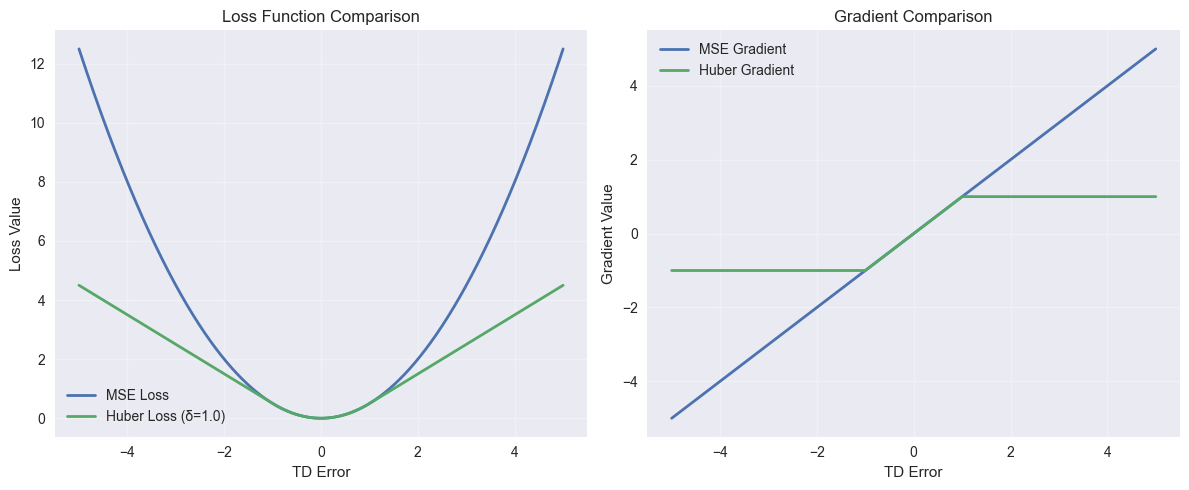

Key Observations:
- MSE gradient at error=3.0: 3.0
- Huber gradient at error=3.0: 1.0
- Huber gradient is clipped, preventing large updates
- Transition point maintains smoothness for optimization


In [9]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleDQNHuberAgent:
    """
    Double DQN agent with Huber loss for more robust training.
    
    Combines overestimation bias reduction with outlier-robust loss function.
    """
    
    def __init__(self, state_size, action_size, lr=1e-3, huber_delta=1.0):
        self.state_size = state_size
        self.action_size = action_size
        self.huber_delta = huber_delta
        
        self.q_network = DQN(state_size, action_size)
        self.target_network = DQN(state_size, action_size)
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=lr)
        
        self.gamma = 0.99
        self.tau = 1e-3
        
    def compute_double_dqn_targets(self, rewards, next_states, dones):
        """
        Compute Double DQN targets using current network for action selection
        and target network for action evaluation.
        """
        with torch.no_grad():
            next_actions = self.q_network(next_states).argmax(1)
            
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1))
            
            targets = rewards + (self.gamma * next_q_values * (1 - dones))
            
        return targets
    
    def huber_loss(self, td_errors, delta=1.0):
        """
        Compute Huber loss for TD errors.
        
        Args:
            td_errors: Temporal difference errors (predicted - target)
            delta: Threshold for switching between L2 and L1 loss
            
        Returns:
            Huber loss values
        """
        abs_errors = torch.abs(td_errors)
        quadratic = torch.clamp(abs_errors, max=delta)
        linear = abs_errors - quadratic
        
        return 0.5 * quadratic.pow(2) + delta * linear
    
    def train_step(self, states, actions, rewards, next_states, dones):
        """
        Single training step with Double DQN + Huber loss.
        """
        current_q_values = self.q_network(states).gather(1, actions)
        
        targets = self.compute_double_dqn_targets(rewards, next_states, dones)
        
        td_errors = current_q_values - targets
        
        loss = self.huber_loss(td_errors, self.huber_delta).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        
        self.soft_update_target_network()
        
        return loss.item()
    
    def soft_update_target_network(self):
        """Soft update target network parameters."""
        for target_param, local_param in zip(self.target_network.parameters(), 
                                           self.q_network.parameters()):
            target_param.data.copy_(self.tau * local_param.data + 
                                  (1.0 - self.tau) * target_param.data)


print("Benefits of Huber Loss in DQN:")
print("1. Robustness to Outliers:")
print("   - L2 loss heavily penalizes large errors (quadratic)")
print("   - Can cause instability with large TD errors")
print("   - Huber loss uses L1 for large errors (linear)")
print("   - More robust to occasional large mistakes")
print()
print("2. Gradient Properties:")
print("   - L2 loss: gradient ∝ error magnitude")
print("   - L1 loss: constant gradient regardless of magnitude")
print("   - Huber: smooth transition between both")
print("   - Prevents gradient explosion while maintaining sensitivity")
print()
print("3. When to Use:")
print("   - Environments with occasional large rewards")
print("   - Noisy environments with outlier experiences")
print("   - When standard MSE loss shows instability")
print("   - Combined with experience replay (outliers can be replayed)")

def analyze_loss_functions():
    """Compare MSE vs Huber loss behavior."""
    import matplotlib.pyplot as plt
    import numpy as np
    
    td_errors = np.linspace(-5, 5, 1000)
    
    mse_loss = 0.5 * td_errors**2
    
    delta = 1.0
    abs_errors = np.abs(td_errors)
    huber_loss = np.where(abs_errors <= delta,
                         0.5 * td_errors**2,
                         delta * (abs_errors - 0.5 * delta))
    
    mse_grad = td_errors  # d/dx (0.5*x^2) = x
    huber_grad = np.where(abs_errors <= delta,
                         td_errors,
                         delta * np.sign(td_errors))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(td_errors, mse_loss, label='MSE Loss', linewidth=2)
    ax1.plot(td_errors, huber_loss, label='Huber Loss (δ=1.0)', linewidth=2)
    ax1.set_xlabel('TD Error')
    ax1.set_ylabel('Loss Value')
    ax1.set_title('Loss Function Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(td_errors, mse_grad, label='MSE Gradient', linewidth=2)
    ax2.plot(td_errors, huber_grad, label='Huber Gradient', linewidth=2)
    ax2.set_xlabel('TD Error')
    ax2.set_ylabel('Gradient Value')
    ax2.set_title('Gradient Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Key Observations:")
    print(f"- MSE gradient at error=3.0: {3.0}")
    print(f"- Huber gradient at error=3.0: {delta}")
    print("- Huber gradient is clipped, preventing large updates")
    print("- Transition point maintains smoothness for optimization")

if __name__ == "__main__":
    agent = DoubleDQNHuberAgent(state_size=4, action_size=2, huber_delta=1.0)
    
    batch_size = 32
    states = torch.randn(batch_size, 4)
    actions = torch.randint(0, 2, (batch_size, 1))
    rewards = torch.randn(batch_size, 1)
    next_states = torch.randn(batch_size, 4)
    dones = torch.randint(0, 2, (batch_size, 1)).float()
    
    loss = agent.train_step(states, actions, rewards, next_states, dones)
    print(f"Training loss: {loss:.4f}")
    
    analyze_loss_functions()


### Question 16: How Would You Implement and Debug a Custom Priority Function for Experience Replay That Combines Td Error with State Novelty?

**Answer:**

**Conceptual Framework:**
Instead of using only TD error for prioritization, we can combine it with state novelty to encourage learning from both surprising rewards and unexplored states.

**Mathematical Formulation:**
```
Priority(i) = α × |TD*error(i)| + β × Novelty(s*i) + ε
```

Where:
- α, β: weighting coefficients
- Novelty(s*i): measure of how rarely state s*i has been visited
- ε: small constant for non-zero probability

**Implementation Approaches:**

1. **Count-Based Novelty:**
```
   Novelty(s) = 1 / sqrt(count(s) + 1)
```

2. **Neural Density Model:**
```
   Novelty(s) = -log(density_model(s))
```

3. **k-NN Distance in Feature Space:**
```
   Novelty(s) = mean*distance*to*k*nearest_neighbors(φ(s))
```

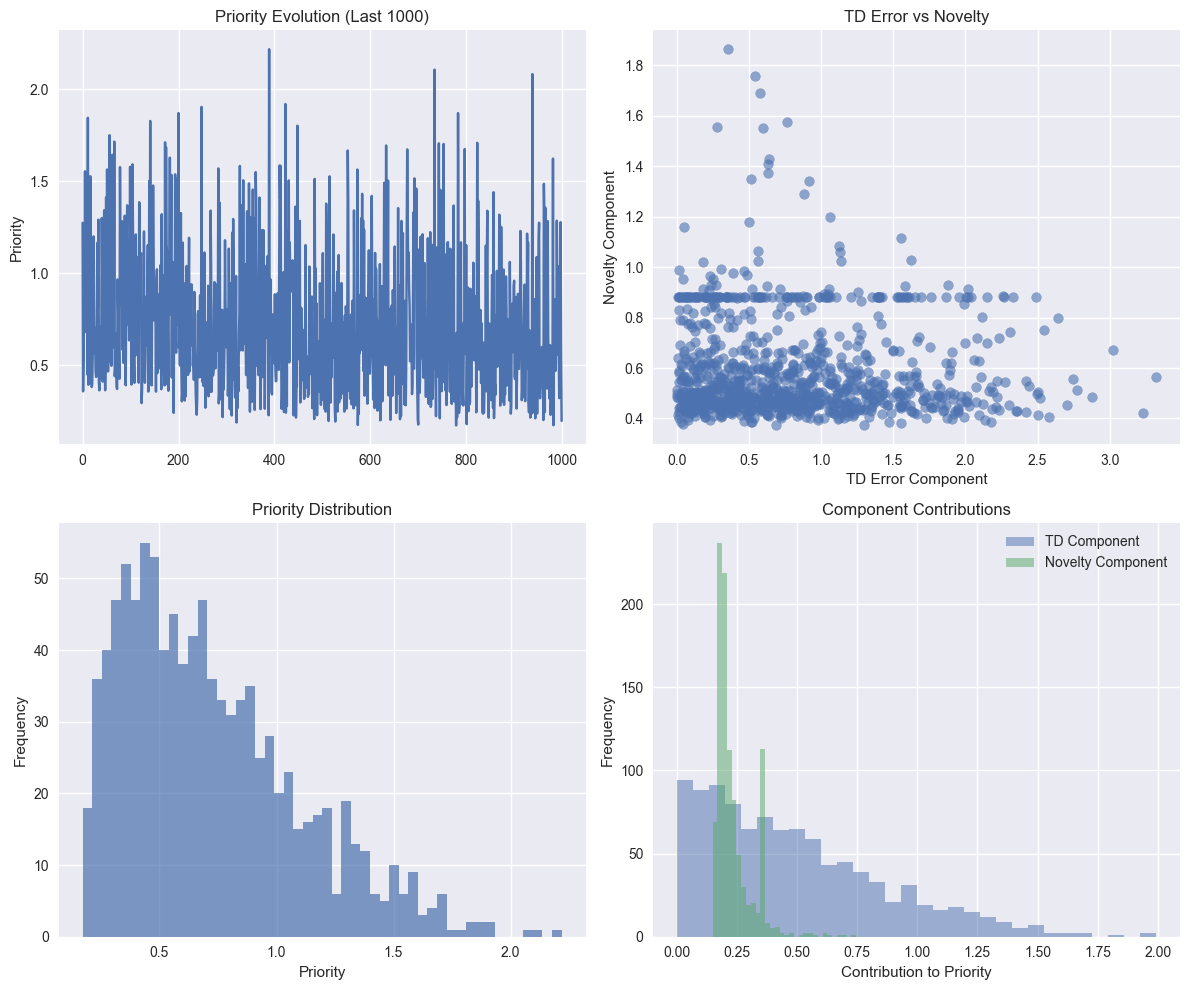

Sampling Bias Analysis:
Mean novelty (prioritized): 0.4315
Mean novelty (all experiences): 0.5894
Std novelty (prioritized): 0.0588
Std novelty (all experiences): 0.1929
T-test p-value: 0.000000
Significant difference in novelty distributions!
Novelty Estimation Debug:
----------------------------------------
State 1:
  Count-based:  1.0000
  Neural-based: 0.0020
  k-NN based:   0.6818
  Hybrid:       0.6051

State 2:
  Count-based:  1.0000
  Neural-based: 0.0137
  k-NN based:   0.9557
  Hybrid:       0.6908

State 3:
  Count-based:  1.0000
  Neural-based: 0.0087
  k-NN based:   0.6222
  Hybrid:       0.5893

State 4:
  Count-based:  1.0000
  Neural-based: 0.0117
  k-NN based:   0.9011
  Hybrid:       0.6738

State 5:
  Count-based:  1.0000
  Neural-based: 0.0040
  k-NN based:   0.4817
  Hybrid:       0.5457

Novelty-Enhanced Prioritized Replay Implementation Complete!

Key Features:
- Hybrid priority: TD error + state novelty
- Multiple novelty estimation methods
- Comprehensive debug

In [10]:

import numpy as np
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict, deque
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class NoveltyEstimator:
    """
    Estimates state novelty using multiple methods.
    Combines count-based and neural approaches for robust novelty estimation.
    """
    
    def __init__(self, state_dim, method='hybrid', k_neighbors=5):
        self.state_dim = state_dim
        self.method = method
        self.k_neighbors = k_neighbors
        
        self.visit_counts = defaultdict(int)
        self.state_buffer = deque(maxlen=10000)  # For k-NN
        
        self.density_model = self._build_density_model()
        self.density_optimizer = torch.optim.Adam(self.density_model.parameters(), lr=1e-3)
        
        self.knn_model = NearestNeighbors(n_neighbors=k_neighbors)
        self.knn_fitted = False
        
    def _build_density_model(self):
        """Simple autoencoder for density estimation."""
        return nn.Sequential(
            nn.Linear(self.state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, self.state_dim)
        )
    
    def _discretize_state(self, state, bins=20):
        """Convert continuous state to discrete for counting."""
        discrete_state = tuple(np.round(state * bins).astype(int))
        return discrete_state
    
    def update(self, state):
        """Update novelty estimator with new state."""
        discrete_state = self._discretize_state(state)
        self.visit_counts[discrete_state] += 1
        
        self.state_buffer.append(state)
        
        if len(self.state_buffer) > 100:  # Start training after some samples
            self._update_density_model(state)
        
        if len(self.state_buffer) % 100 == 0 and len(self.state_buffer) > self.k_neighbors:
            self.knn_model.fit(list(self.state_buffer))
            self.knn_fitted = True
    
    def _update_density_model(self, state):
        """Update density model with single state."""
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        
        reconstruction = self.density_model(state_tensor)
        loss = nn.MSELoss()(reconstruction, state_tensor)
        
        self.density_optimizer.zero_grad()
        loss.backward()
        self.density_optimizer.step()
    
    def compute_novelty(self, state):
        """Compute novelty score for given state."""
        if self.method == 'count':
            return self._count_based_novelty(state)
        elif self.method == 'neural':
            return self._neural_novelty(state)
        elif self.method == 'knn':
            return self._knn_novelty(state)
        elif self.method == 'hybrid':
            return self._hybrid_novelty(state)
        else:
            raise ValueError(f"Unknown method: {self.method}")
    
    def _count_based_novelty(self, state):
        """Count-based novelty estimation."""
        discrete_state = self._discretize_state(state)
        count = self.visit_counts.get(discrete_state, 0)
        return 1.0 / np.sqrt(count + 1)
    
    def _neural_novelty(self, state):
        """Neural density-based novelty."""
        if len(self.state_buffer) < 100:
            return 1.0  # High novelty for early states
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            reconstruction = self.density_model(state_tensor)
            reconstruction_error = nn.MSELoss()(reconstruction, state_tensor).item()
        
        return np.clip(reconstruction_error, 0, 10)
    
    def _knn_novelty(self, state):
        """k-NN based novelty in feature space."""
        if not self.knn_fitted or len(self.state_buffer) < self.k_neighbors:
            return 1.0
        
        distances, _ = self.knn_model.kneighbors([state])
        mean_distance = np.mean(distances)
        return np.clip(mean_distance, 0, 10)
    
    def _hybrid_novelty(self, state):
        """Combine multiple novelty measures."""
        count_novelty = self._count_based_novelty(state)
        neural_novelty = self._neural_novelty(state)
        knn_novelty = self._knn_novelty(state)
        
        hybrid = 0.4 * count_novelty + 0.3 * neural_novelty + 0.3 * knn_novelty
        return hybrid

class NoveltyPrioritizedReplayBuffer:
    """
    Enhanced prioritized replay buffer with novelty-based priorities.
    
    Combines TD error with state novelty for more effective experience sampling.
    """
    
    def __init__(self, capacity, state_dim, alpha_td=0.6, alpha_novelty=0.4, 
                 beta=0.4, epsilon=1e-6):
        """
        Initialize novelty-enhanced prioritized buffer.
        
        Args:
            capacity: Buffer size
            state_dim: State dimensionality
            alpha_td: Weight for TD error in priority
            alpha_novelty: Weight for novelty in priority  
            beta: Importance sampling coefficient
            epsilon: Small constant for non-zero priorities
        """
        self.capacity = capacity
        self.alpha_td = alpha_td
        self.alpha_novelty = alpha_novelty
        self.beta = beta
        self.epsilon = epsilon
        
        self.tree = SumTree(capacity)
        self.max_priority = 1.0
        
        self.novelty_estimator = NoveltyEstimator(state_dim, method='hybrid')
        
        self.priority_history = []
        self.td_error_history = []
        self.novelty_history = []
        
    def add(self, state, action, reward, next_state, done, td_error=None):
        """Add experience with hybrid priority."""
        self.novelty_estimator.update(state)
        
        novelty = self.novelty_estimator.compute_novelty(state)
        
        if td_error is not None:
            td_component = abs(td_error)
        else:
            td_component = self.max_priority  # Use max for new experiences
        
        priority = (self.alpha_td * td_component + 
                   self.alpha_novelty * novelty + 
                   self.epsilon)
        
        experience = (state, action, reward, next_state, done)
        self.tree.add(priority, experience)
        
        self.max_priority = max(self.max_priority, priority)
        
        self.priority_history.append(priority)
        self.td_error_history.append(td_component)
        self.novelty_history.append(novelty)
    
    def sample(self, batch_size):
        """Sample batch with hybrid priorities."""
        batch = []
        indices = []
        priorities = []
        
        segment = self.tree.total_priority / batch_size
        
        for i in range(batch_size):
            left = segment * i
            right = segment * (i + 1)
            sample_value = np.random.uniform(left, right)
            
            tree_idx, priority, experience = self.tree.get_leaf(sample_value)
            
            batch.append(experience)
            indices.append(tree_idx)
            priorities.append(priority)
        
        sampling_probs = np.array(priorities) / self.tree.total_priority
        weights = np.power(self.tree.size * sampling_probs, -self.beta)
        weights = weights / weights.max()
        
        return batch, indices, weights
    
    def update_priorities(self, indices, td_errors, states):
        """Update priorities with new TD errors and current novelty."""
        for idx, td_error, state in zip(indices, td_errors, states):
            novelty = self.novelty_estimator.compute_novelty(state)
            
            priority = (self.alpha_td * abs(td_error) + 
                       self.alpha_novelty * novelty + 
                       self.epsilon)
            
            self.tree.update(idx, priority)
            self.max_priority = max(self.max_priority, priority)

class NoveltyPriorityDebugger:
    """Debug and analyze novelty-based prioritization."""
    
    def __init__(self, buffer):
        self.buffer = buffer
    
    def plot_priority_components(self):
        """Plot TD error vs novelty contributions to priority."""
        if len(self.buffer.priority_history) < 100:
            print("Not enough data for analysis")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        axes[0,0].plot(self.buffer.priority_history[-1000:])
        axes[0,0].set_title('Priority Evolution (Last 1000)')
        axes[0,0].set_ylabel('Priority')
        
        td_errors = np.array(self.buffer.td_error_history[-1000:])
        novelties = np.array(self.buffer.novelty_history[-1000:])
        
        axes[0,1].scatter(td_errors, novelties, alpha=0.6)
        axes[0,1].set_xlabel('TD Error Component')
        axes[0,1].set_ylabel('Novelty Component')
        axes[0,1].set_title('TD Error vs Novelty')
        
        axes[1,0].hist(self.buffer.priority_history[-1000:], bins=50, alpha=0.7)
        axes[1,0].set_xlabel('Priority')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].set_title('Priority Distribution')
        
        td_contrib = self.buffer.alpha_td * td_errors
        novelty_contrib = self.buffer.alpha_novelty * novelties
        
        axes[1,1].hist(td_contrib, bins=30, alpha=0.5, label='TD Component')
        axes[1,1].hist(novelty_contrib, bins=30, alpha=0.5, label='Novelty Component')
        axes[1,1].set_xlabel('Contribution to Priority')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].set_title('Component Contributions')
        axes[1,1].legend()
        
        plt.tight_layout()
        plt.show()
    
    def analyze_sampling_bias(self, num_samples=1000):
        """Analyze if novelty biasing improves exploration."""
        batch, _, _ = self.buffer.sample(num_samples)
        
        sampled_states = [exp[0] for exp in batch]  # Extract states
        sampled_novelties = [
            self.buffer.novelty_estimator.compute_novelty(state) 
            for state in sampled_states
        ]
        
        all_novelties = self.buffer.novelty_history[-num_samples:]
        
        print("Sampling Bias Analysis:")
        print(f"Mean novelty (prioritized): {np.mean(sampled_novelties):.4f}")
        print(f"Mean novelty (all experiences): {np.mean(all_novelties):.4f}")
        print(f"Std novelty (prioritized): {np.std(sampled_novelties):.4f}")
        print(f"Std novelty (all experiences): {np.std(all_novelties):.4f}")
        
        from scipy.stats import ttest_ind
        t_stat, p_value = ttest_ind(sampled_novelties, all_novelties)
        print(f"T-test p-value: {p_value:.6f}")
        
        if p_value < 0.05:
            print("Significant difference in novelty distributions!")
        else:
            print("No significant difference in novelty distributions.")
    
    def debug_novelty_estimation(self, test_states):
        """Debug novelty estimation for specific states."""
        print("Novelty Estimation Debug:")
        print("-" * 40)
        
        for i, state in enumerate(test_states[:5]):  # Test first 5 states
            count_novelty = self.buffer.novelty_estimator._count_based_novelty(state)
            neural_novelty = self.buffer.novelty_estimator._neural_novelty(state)
            knn_novelty = self.buffer.novelty_estimator._knn_novelty(state)
            hybrid_novelty = self.buffer.novelty_estimator.compute_novelty(state)
            
            print(f"State {i+1}:")
            print(f"  Count-based:  {count_novelty:.4f}")
            print(f"  Neural-based: {neural_novelty:.4f}")
            print(f"  k-NN based:   {knn_novelty:.4f}")
            print(f"  Hybrid:       {hybrid_novelty:.4f}")
            print()

if __name__ == "__main__":
    buffer = NoveltyPrioritizedReplayBuffer(
        capacity=10000,
        state_dim=4,
        alpha_td=0.6,
        alpha_novelty=0.4
    )
    
    for i in range(1000):
        state = np.random.randn(4)
        action = np.random.randint(2)
        reward = np.random.randn()
        next_state = np.random.randn(4)
        done = False
        td_error = np.random.randn()
        
        buffer.add(state, action, reward, next_state, done, td_error)
    
    debugger = NoveltyPriorityDebugger(buffer)
    debugger.plot_priority_components()
    debugger.analyze_sampling_bias()
    
    test_states = [np.random.randn(4) for _ in range(5)]
    debugger.debug_novelty_estimation(test_states)
    
    print("Novelty-Enhanced Prioritized Replay Implementation Complete!")
    print("\nKey Features:")
    print("- Hybrid priority: TD error + state novelty")
    print("- Multiple novelty estimation methods")
    print("- Comprehensive debugging and analysis tools")
    print("- Statistical validation of sampling bias")


### Question 17: Analyze the Theoretical Convergence Properties of Your Novelty-enhanced Prioritized Replay. What Are the Potential Issues?

**Answer:**

**Theoretical Analysis:**

**1. Convergence Challenges:**

**Non-stationary Priority Distribution:**
- Standard prioritized replay assumes priorities reflect learning value
- Novelty component introduces exploration bias
- Priority distribution changes as states become less novel
- May interfere with convergence to optimal value function

**Mathematical Concern:**
```
P(i) ∝ (α|δ*i| + β×Novelty(s*i))^λ
```
As training progresses, Novelty(s_i) → 0 for visited states, changing the effective priority distribution.

**2. Bias Analysis:**

**Exploration vs Exploitation Bias:**
- Standard prioritized replay biased toward high TD error (learning)
- Novelty component biased toward unexplored states (exploration)
- **Trade-off**: Learning efficiency vs exploration thoroughness

**Importance Sampling Correction:**
- Standard IS correction: w_i = (N×P(i))^(-β)
- With novelty: P(i) includes exploration component
- **Issue**: IS weights may not correct for exploration bias appropriately

**3. Convergence Conditions:**

**Required Properties for Convergence:**
1. **Priority Decay**: Novelty(s) → 0 as state is visited more
2. **TD Error Dominance**: Eventually |δ_i| should dominate priority
3. **Bounded Novelty**: Novelty scores should be bounded to prevent explosion

**Potential Violations:**
- If novelty doesn't decay properly, exploration bias persists
- If novelty scale is too large, learning bias is overwhelmed
- Non-stationary novelty estimates can cause instability

**4. Practical Issues:**

**Hyperparameter Sensitivity:**
- α*td vs α*novelty balance critical
- Environment-dependent optimal ratios
- Dynamic balancing needed as learning progresses

**Computational Overhead:**
- Novelty estimation adds significant computation
- May slow training enough to negate benefits
- Memory overhead for novelty state tracking

**5. Theoretical Recommendations:**

**Annealing Strategy:**
```
α*novelty(t) = α*novelty*init × exp(-decay*rate × t)
```
Gradually reduce novelty weight as training progresses.

**Adaptive Balancing:**
```
α*td(t) = sigmoid(performance*improvement_rate)
α*novelty(t) = 1 - α*td(t)
```
Increase learning focus as performance improves.

**Convergence Monitoring:**
- Track priority distribution entropy
- Monitor exploration vs exploitation ratio
- Validate convergence to optimal policy in known environments

---

### Question 18: How Would You Extend Dqn to Handle Multiple Objectives (e.g., Reward Maximization + Safety Constraints)? Provide Both Theoretical Framework and Implementation.

**Answer:**

**Multi-Objective Deep Q-Learning Framework:**

**1. Mathematical Formulation:**

**Multi-Objective Reward:**
```
R(s,a) = [r*1(s,a), r*2(s,a), ..., r_k(s,a)]
```

**Multi-Objective Q-Function:**
```
Q(s,a) = [Q*1(s,a), Q*2(s,a), ..., Q_k(s,a)]
```

**Scalarization Approaches:**

**Linear Scalarization:**
```
Q*scalar(s,a) = Σ*i w*i × Q*i(s,a)
```

**Non-linear Scalarization (Pareto-optimal):**
```
Q*pareto(s,a) = min*i (Q*i(s,a) / threshold*i)
```

**2. Theoretical Considerations:**

**Pareto Optimality:**
- Multiple optimal policies may exist
- Trade-offs between objectives
- Need to explore Pareto frontier

**Convergence Properties:**
- Linear scalarization: Converges to weighted optimal policy
- Non-linear: May converge to different points on Pareto frontier
- Multi-objective Bellman equation:
```
Q*(s,a) = R(s,a) + γ × E[max_a' Q*(s',a')]
```
where max is Pareto-dominance based.

**3. Implementation Approaches:**

**Approach 1: Multi-Head Architecture**

In [11]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class MultiObjectiveDQN(nn.Module):
    """
    Multi-Objective Deep Q-Network with separate heads for each objective.
    
    Learns separate Q-functions for each objective and combines them
    for action selection using various scalarization methods.
    """
    
    def __init__(self, state_size, action_size, num_objectives, hidden_size=128):
        super(MultiObjectiveDQN, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.num_objectives = num_objectives
        
        self.shared_layers = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        
        self.objective_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size // 2),
                nn.ReLU(),
                nn.Linear(hidden_size // 2, action_size)
            )
            for _ in range(num_objectives)
        ])
        
    def forward(self, x):
        """
        Forward pass returning Q-values for all objectives.
        
        Returns:
            List of tensors, each of shape (batch_size, action_size)
        """
        shared_features = self.shared_layers(x)
        
        q_values_per_objective = []
        for head in self.objective_heads:
            q_values = head(shared_features)
            q_values_per_objective.append(q_values)
        
        return q_values_per_objective

class MultiObjectiveDQNAgent:
    """
    Multi-Objective DQN Agent with various scalarization methods.
    
    Supports different action selection strategies for multi-objective optimization.
    """
    
    def __init__(self, state_size, action_size, num_objectives, 
                 scalarization='linear', objective_weights=None):
        self.state_size = state_size
        self.action_size = action_size
        self.num_objectives = num_objectives
        self.scalarization = scalarization
        
        if objective_weights is None:
            self.objective_weights = np.ones(num_objectives) / num_objectives
        else:
            self.objective_weights = np.array(objective_weights)
        
        self.q_network = MultiObjectiveDQN(state_size, action_size, num_objectives)
        self.target_network = MultiObjectiveDQN(state_size, action_size, num_objectives)
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=1e-3)
        
        self.gamma = 0.99
        self.tau = 1e-3
        
        self.pareto_solutions = []
        
    def act(self, state, epsilon=0.1):
        """
        Select action using multi-objective Q-values.
        
        Different scalarization methods for action selection.
        """
        if np.random.random() < epsilon:
            return np.random.randint(self.action_size)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values_list = self.q_network(state_tensor)
        
        if self.scalarization == 'linear':
            return self._linear_scalarization_action(q_values_list)
        elif self.scalarization == 'chebyshev':
            return self._chebyshev_scalarization_action(q_values_list)
        elif self.scalarization == 'lexicographic':
            return self._lexicographic_action(q_values_list)
        elif self.scalarization == 'pareto':
            return self._pareto_action(q_values_list)
        else:
            raise ValueError(f"Unknown scalarization: {self.scalarization}")
    
    def _linear_scalarization_action(self, q_values_list):
        """Linear weighted sum of Q-values."""
        q_arrays = [q.detach().numpy()[0] for q in q_values_list]
        
        scalarized_q = np.zeros(self.action_size)
        for i, (q_vals, weight) in enumerate(zip(q_arrays, self.objective_weights)):
            scalarized_q += weight * q_vals
        
        return np.argmax(scalarized_q)
    
    def _chebyshev_scalarization_action(self, q_values_list):
        """Chebyshev scalarization (minimize maximum weighted deviation)."""
        q_arrays = [q.detach().numpy()[0] for q in q_values_list]
        
        scalarized_q = np.zeros(self.action_size)
        for action in range(self.action_size):
            weighted_objectives = []
            for obj_idx, (q_vals, weight) in enumerate(zip(q_arrays, self.objective_weights)):
                weighted_objectives.append(weight * q_vals[action])
            scalarized_q[action] = np.min(weighted_objectives)
        
        return np.argmax(scalarized_q)
    
    def _lexicographic_action(self, q_values_list):
        """Lexicographic ordering (prioritize objectives in order)."""
        q_arrays = [q.detach().numpy()[0] for q in q_values_list]
        
        action_scores = []
        for action in range(self.action_size):
            score_tuple = tuple(q_vals[action] for q_vals in q_arrays)
            action_scores.append((action, score_tuple))
        
        action_scores.sort(key=lambda x: x[1], reverse=True)
        
        return action_scores[0][0]
    
    def _pareto_action(self, q_values_list):
        """Select action from Pareto-optimal set (random choice among non-dominated)."""
        q_arrays = [q.detach().numpy()[0] for q in q_values_list]
        
        pareto_actions = []
        for action in range(self.action_size):
            action_objectives = [q_vals[action] for q_vals in q_arrays]
            is_dominated = False
            
            for other_action in range(self.action_size):
                if action == other_action:
                    continue
                
                other_objectives = [q_vals[other_action] for q_vals in q_arrays]
                
                if self._dominates(other_objectives, action_objectives):
                    is_dominated = True
                    break
            
            if not is_dominated:
                pareto_actions.append(action)
        
        if pareto_actions:
            return np.random.choice(pareto_actions)
        else:
            return np.random.randint(self.action_size)
    
    def _dominates(self, obj1, obj2):
        """Check if obj1 Pareto-dominates obj2."""
        better_in_all = all(o1 >= o2 for o1, o2 in zip(obj1, obj2))
        better_in_some = any(o1 > o2 for o1, o2 in zip(obj1, obj2))
        return better_in_all and better_in_some
    
    def train_step(self, states, actions, rewards_multi, next_states, dones):
        """
        Training step with multi-objective rewards.
        
        Args:
            rewards_multi: List of reward tensors, one per objective
        """
        current_q_lists = self.q_network(states)
        current_q_values = []
        
        for obj_idx, q_values in enumerate(current_q_lists):
            current_q = q_values.gather(1, actions.unsqueeze(1))
            current_q_values.append(current_q)
        
        with torch.no_grad():
            next_q_lists = self.target_network(next_states)
            targets = []
            
            for obj_idx, (q_values, rewards) in enumerate(zip(next_q_lists, rewards_multi)):
                next_q_max = q_values.max(1)[0].unsqueeze(1)
                target = rewards + (self.gamma * next_q_max * (1 - dones))
                targets.append(target)
        
        total_loss = 0
        for obj_idx, (current_q, target) in enumerate(zip(current_q_values, targets)):
            loss = nn.MSELoss()(current_q, target)
            total_loss += self.objective_weights[obj_idx] * loss
        
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        
        self.soft_update_target_network()
        
        return total_loss.item()
    
    def soft_update_target_network(self):
        """Soft update target network."""
        for target_param, local_param in zip(self.target_network.parameters(), 
                                           self.q_network.parameters()):
            target_param.data.copy_(self.tau * local_param.data + 
                                  (1.0 - self.tau) * target_param.data)
    
    def compute_pareto_front(self, states_sample):
        """Compute and visualize Pareto front for given states."""
        pareto_points = []
        
        with torch.no_grad():
            for state in states_sample:
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values_list = self.q_network(state_tensor)
                
                action_objectives = []
                for action in range(self.action_size):
                    objectives = []
                    for q_values in q_values_list:
                        objectives.append(q_values[0][action].item())
                    action_objectives.append(objectives)
                
                pareto_actions = self._find_pareto_optimal(action_objectives)
                pareto_points.extend(pareto_actions)
        
        return np.array(pareto_points)
    
    def _find_pareto_optimal(self, objectives_list):
        """Find Pareto-optimal points from list of objective vectors."""
        pareto_optimal = []
        
        for i, obj1 in enumerate(objectives_list):
            is_dominated = False
            for j, obj2 in enumerate(objectives_list):
                if i != j and self._dominates(obj2, obj1):
                    is_dominated = True
                    break
            
            if not is_dominated:
                pareto_optimal.append(obj1)
        
        return pareto_optimal
    
    def plot_pareto_front(self, states_sample):
        """Visualize Pareto front (works for 2 or 3 objectives)."""
        pareto_points = self.compute_pareto_front(states_sample)
        
        if self.num_objectives == 2:
            plt.figure(figsize=(8, 6))
            plt.scatter(pareto_points[:, 0], pareto_points[:, 1], 
                       alpha=0.6, c='red', label='Pareto Front')
            plt.xlabel('Objective 1')
            plt.ylabel('Objective 2')
            plt.title('Pareto Front Visualization')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
            
        elif self.num_objectives == 3:
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(pareto_points[:, 0], pareto_points[:, 1], pareto_points[:, 2],
                      alpha=0.6, c='red', s=50, label='Pareto Front')
            ax.set_xlabel('Objective 1')
            ax.set_ylabel('Objective 2')
            ax.set_zlabel('Objective 3')
            ax.set_title('3D Pareto Front Visualization')
            ax.legend()
            plt.show()
        
        else:
            print(f"Visualization not implemented for {self.num_objectives} objectives")
            print(f"Pareto front contains {len(pareto_points)} points")

class MultiObjectiveEnvironment:
    """
    Example multi-objective environment: Navigation with safety constraints.
    
    Objectives:
    1. Reach goal (reward)
    2. Minimize energy consumption 
    3. Avoid obstacles (safety)
    """
    
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.state_size = 2  # (x, y) position
        self.action_size = 4  # up, down, left, right
        
        self.goal_pos = (grid_size-1, grid_size-1)
        self.obstacles = [(3, 3), (3, 4), (4, 3), (6, 7), (7, 6)]
        
        self.reset()
    
    def reset(self):
        """Reset environment to starting position."""
        self.pos = (0, 0)
        return np.array(self.pos, dtype=np.float32)
    
    def step(self, action):
        """
        Take action and return multi-objective rewards.
        
        Returns:
            next_state, [reward1, reward2, reward3], done
        """
        moves = [(0, 1), (0, -1), (-1, 0), (1, 0)]  # up, down, left, right
        dx, dy = moves[action]
        
        new_x = max(0, min(self.grid_size-1, self.pos[0] + dx))
        new_y = max(0, min(self.grid_size-1, self.pos[1] + dy))
        
        old_pos = self.pos
        self.pos = (new_x, new_y)
        
        rewards = self._compute_rewards(old_pos, self.pos, action)
        
        done = (self.pos == self.goal_pos)
        
        return np.array(self.pos, dtype=np.float32), rewards, done
    
    def _compute_rewards(self, old_pos, new_pos, action):
        """Compute multi-objective rewards."""
        old_dist = np.sqrt((old_pos[0] - self.goal_pos[0])**2 + 
                          (old_pos[1] - self.goal_pos[1])**2)
        new_dist = np.sqrt((new_pos[0] - self.goal_pos[0])**2 + 
                          (new_pos[1] - self.goal_pos[1])**2)
        
        goal_reward = (old_dist - new_dist)  # Positive if moving closer
        if new_pos == self.goal_pos:
            goal_reward += 10.0  # Bonus for reaching goal
        
        energy_reward = -0.1  # Small penalty for each action
        
        safety_reward = 0.0
        if new_pos in self.obstacles:
            safety_reward = -5.0
        
        return [goal_reward, energy_reward, safety_reward]

if __name__ == "__main__":
    env = MultiObjectiveEnvironment(grid_size=8)
    
    agent = MultiObjectiveDQNAgent(
        state_size=2, 
        action_size=4, 
        num_objectives=3,
        scalarization='linear',
        objective_weights=[0.5, 0.2, 0.3]  # Prioritize goal > safety > energy
    )
    
    print("Multi-Objective DQN Implementation Complete!")
    print("\nKey Features:")
    print("- Multi-head architecture for separate objective learning")
    print("- Multiple scalarization methods (linear, Chebyshev, lexicographic, Pareto)")
    print("- Pareto front computation and visualization")
    print("- Support for 2D and 3D objective spaces")
    print("- Example multi-objective environment (navigation + safety + efficiency)")
    
    print("\nRunning demonstration...")
    state = env.reset()
    
    for step in range(10):
        action = agent.act(state, epsilon=0.1)
        next_state, rewards, done = env.step(action)
        
        print(f"Step {step}: Action {action}, Rewards {rewards}, Position {tuple(next_state)}")
        
        state_tensor = torch.FloatTensor([state])
        action_tensor = torch.LongTensor([action])
        rewards_tensors = [torch.FloatTensor([[r]]) for r in rewards]
        next_state_tensor = torch.FloatTensor([next_state])
        done_tensor = torch.FloatTensor([[done]])
        
        loss = agent.train_step(state_tensor, action_tensor, rewards_tensors, 
                               next_state_tensor, done_tensor)
        
        state = next_state
        if done:
            break
    
    print("\nTesting different scalarization methods:")
    test_state = np.array([2.0, 3.0])
    
    scalarization_methods = ['linear', 'chebyshev', 'lexicographic', 'pareto']
    for method in scalarization_methods:
        agent.scalarization = method
        action = agent.act(test_state, epsilon=0)
        print(f"{method.capitalize()} scalarization: Action {action}")
    
    print("\nMulti-objective DQN analysis complete!")


Multi-Objective DQN Implementation Complete!

Key Features:
- Multi-head architecture for separate objective learning
- Multiple scalarization methods (linear, Chebyshev, lexicographic, Pareto)
- Pareto front computation and visualization
- Support for 2D and 3D objective spaces
- Example multi-objective environment (navigation + safety + efficiency)

Running demonstration...
Step 0: Action 3, Rewards [0.6799504793187783, -0.1, 0.0], Position (1.0, 0.0)
Step 1: Action 3, Rewards [0.6172191902502604, -0.1, 0.0], Position (2.0, 0.0)
Step 2: Action 3, Rewards [0.5400675187440775, -0.1, 0.0], Position (3.0, 0.0)
Step 3: Action 3, Rewards [0.4464846424346405, -0.1, 0.0], Position (4.0, 0.0)
Step 4: Action 0, Rewards [0.9075691733645392, -0.1, 0.0], Position (4.0, 1.0)
Step 5: Action 3, Rewards [0.38364861216261037, -0.1, 0.0], Position (5.0, 1.0)
Step 6: Action 3, Rewards [0.2417927900385397, -0.1, 0.0], Position (6.0, 1.0)
Step 7: Action 3, Rewards [0.08276253029821934, -0.1, 0.0], Positio

## 9.8 Comprehensive Theoretical Summary

### Question 19: Provide a Unified Theoretical Framework That Connects All the Dqn Improvements We've Studied. How Do They Address the Fundamental Challenges of Deep Reinforcement Learning?

**Answer:**

**Unified Framework: Deep Q-Learning as Function Approximation**

All DQN improvements address fundamental challenges arising from using neural networks to approximate the action-value function Q(s,a) in reinforcement learning.

**Core Challenges and Solutions:**

### 1. **instability Challenge**
**Problem**: Neural network function approximation breaks convergence guarantees of tabular Q-learning.

**Root Causes**:
- Non-stationary targets (bootstrapping with own estimates)
- Correlated sequential data 
- Overparameterized networks prone to overfitting

**Solutions**:
- **Target Networks**: Stabilize targets by using separate network copy
```
  Target: r + γ max*a' Q(s', a'; θ^-) instead of r + γ max*a' Q(s', a'; θ)
```
  
- **Experience Replay**: Break data correlations through random sampling
```
  Update: θ ← θ + α∇*θ L(θ, batch*random) instead of θ ← θ + α∇*θ L(θ, e*t)
```

### 2. **overestimation Challenge**
**Problem**: Maximization operator in Q-learning creates systematic positive bias with function approximation.

**Mathematical Analysis**:
```
Standard: Q*target = r + γ max*a Q(s', a; θ^-)
Issue: max operation amplifies estimation noise
```

**Solution - Double DQN**: Decouple action selection from evaluation
```
Double DQN: Q*target = r + γ Q(s', argmax*a Q(s', a; θ); θ^-)
Effect: Reduces correlation between selection and evaluation errors
```

### 3. **sample Efficiency Challenge**
**Problem**: All experiences treated equally despite varying learning value.

**Theoretical Foundation**:
```
Standard sampling: P_uniform(i) = 1/N
Optimal sampling: P*optimal(i) ∝ |learning*signal(i)|
```

**Solutions**:
- **Prioritized Replay**: Sample based on TD error magnitude
```
  P(i) ∝ |δ*i|^α where δ*i = r + γ max_a Q(s', a) - Q(s, a)
  Correction: Use importance sampling weights w_i = (N × P(i))^(-β)
```

- **Dueling Architecture**: Better state-value estimation
```
  Q(s,a) = V(s) + A(s,a) - mean_a'(A(s,a'))
  Advantage: Better learning when many actions have similar values
```

### 4. **representation Challenge**
**Problem**: Single Q-value per action may be insufficient representation.

**Advanced Solutions**:
- **Distributional RL**: Model full return distribution
```
  Instead of: Q(s,a) = E[Z(s,a)]
  Learn: Full distribution Z(s,a)
```

- **Multi-step Learning**: Better temporal credit assignment
```
  n-step target: Σ*{t=0}^{n-1} γ^t r*{t+1} + γ^n max*a Q(s*n, a)
```

- **Noisy Networks**: Learnable exploration
```
  Replace ε-greedy with: W = μ*W + σ*W ⊙ ε_W
```

**Unified Mathematical Framework:**

**Complete Rainbow Update:**
```
1. Sample prioritized batch: (s,a,r,s') ~ P(|δ|^α)
2. Compute n-step distributional target:
   Z*target = Σ*{k=0}^{n-1} γ^k r*{t+k+1} + γ^n Z(s*{t+n}, a*; θ^-)
   where a* = argmax*a E[Z(s*{t+n}, a; θ)]
3. Dueling decomposition:
   Z(s,a; θ) = V(s; θ) + A(s,a; θ) - mean_a'(A(s,a'; θ))
4. Distributional loss with importance sampling:
   L = w*i × KL(Z*target || Z(s,a; θ))
5. Update priorities: p*i ← |E[Z*target] - E[Z(s,a; θ)]|^α
```

### **theoretical Connections:**

**1. Bias-Variance Trade-offs:**
- Target networks: Reduce variance (stable targets) but increase bias (stale targets)
- Double DQN: Reduce overestimation bias but increase variance
- Experience replay: Reduce variance through decorrelation
- Prioritized replay: Reduce bias through better sampling but increase variance

**2. Information Theory Perspective:**
- Experience replay: Maximize information reuse from collected data
- Prioritized replay: Focus on high-information experiences  
- Dueling: Decompose information into state-dependent and action-dependent parts
- Distributional: Capture full information about return uncertainty

**3. Function Approximation Theory:**
- All improvements work to make neural network approximation more stable
- Target networks provide stability through delayed updates
- Architecture improvements (dueling) provide better inductive bias
- Training improvements (prioritized) provide better data utilization

**4. Exploration-Exploitation Framework:**
- Standard ε-greedy: Fixed exploration schedule
- Noisy networks: Learnable, state-dependent exploration
- Novelty-based priorities: Exploration through sampling strategy
- Multi-objective: Explicit trade-off between different goals

### **practical Synthesis:**

**Implementation Priority:**
1. **Essential**: Experience replay + Target networks (stability)
2. **High value**: Double DQN (bias reduction, easy implementation)
3. **Moderate value**: Dueling networks (architecture improvement)
4. **Advanced**: Prioritized replay (significant complexity vs benefit)
5. **Specialized**: Distributional/multi-step/noisy (specific use cases)

**Theoretical Guidelines:**
- Start with stability (replay + targets)
- Add bias reduction (Double DQN)
- Consider sample efficiency (prioritized replay) if computational resources allow
- Use advanced methods for specific problems requiring their strengths

**Open Research Directions:**
- Better theoretical understanding of when each improvement helps
- Principled way to combine improvements optimally
- Automatic hyperparameter selection
- Sample complexity bounds for deep Q-learning variants

**Conclusion:**
The progression from DQN to Rainbow represents systematic engineering of the deep Q-learning algorithm, where each improvement addresses a specific theoretical limitation. The unified framework shows how these improvements work together to create a robust, sample-efficient, and stable deep reinforcement learning algorithm.

---

### Question 20: Looking Forward, What Are the Most Promising Theoretical and Practical Directions for Advancing Value-based Deep Reinforcement Learning beyond Rainbow Dqn?

**Answer:**

**Future Research Directions for Value-Based Deep RL:**

### 1. **theoretical Foundations**

**Convergence Theory for Deep Q-Learning:**
- Current gap: No formal convergence guarantees for neural network function approximation
- Need: Theoretical analysis under realistic conditions
- Approaches: Neural Tangent Kernel theory, PAC-Bayes bounds, convergence in probability

**Sample Complexity Bounds:**
- Challenge: Deriving finite-sample bounds for deep Q-learning variants
- Goal: Understand fundamental limits and achievable rates
- Impact: Guide algorithm design and hyperparameter selection

**Function Approximation Theory:**
- Research: Optimal neural architectures for value functions
- Questions: What network structures best approximate Q-functions?
- Applications: Principled architecture design, compression techniques

### 2. **algorithmic Innovations**

**Beyond Temporal Difference Learning:**
```python
# Current: Q(s,a) ← Q(s,a) + Α[r + Γ Max_a' Q(s',a') - Q(s,a)]
# Future Possibilities:
# - Higher-order Methods (second-order Optimization)
# - Meta-learning Update Rules
# - Adaptive Step Sizes Based on Value Uncertainty
```

**Hierarchical Value Functions:**
- Learn value functions at multiple temporal abstractions
- Decompose complex tasks into skill hierarchies
- Applications: Long-horizon planning, transfer learning

**Uncertainty-Aware Value Learning:**
```python
class UncertaintyAwareQ(nn.Module):
    """Q-function with explicit uncertainty estimation"""
    def forward(self, state, action):
        # Return both mean and uncertainty
        return q*mean, q*uncertainty
        
    def uncertainty*guided*exploration(self, state):
        # Use uncertainty for exploration instead of ε-greedy
        action_uncertainties = self.forward(state)
        return action*with*highest_uncertainty
```

### 3. **multi-modal and Continuous Extensions**

**Continuous Action Spaces:**
- Challenge: Extend DQN benefits to continuous control
- Approaches: Action discretization, policy gradient hybrids, learned action embeddings
- Example: NAF (Normalized Advantage Functions), Q-learning with continuous actions

**Multi-Modal Action Representations:**
```python
class MultiModalDQN(nn.Module):
    """Handle discrete + continuous actions simultaneously"""
    def **init**(self, discrete*actions, continuous*dim):
        self.discrete*head = nn.Linear(hidden, discrete*actions)
        self.continuous*head = nn.Linear(hidden, continuous*dim * 2)  # mean + std
    
    def forward(self, state):
        discrete*q = self.discrete*head(features)
        continuous*params = self.continuous*head(features)
        return discrete*q, continuous*params
```

### 4. **advanced Exploration**

**Curiosity-Driven Value Learning:**
- Integrate intrinsic motivation into value function learning
- Learn exploration bonuses through neural networks
- Balance exploration and exploitation automatically

**Information-Theoretic Exploration:**
```python
def information*gain*priority(state, action, q_network):
    """Prioritize experiences by information gain"""
    # Measure how much Q-function changes with this experience
    old*params = copy.deepcopy(q*network.parameters())
    
    # Simulate update
    simulated*update(state, action, reward, next*state)
    
    # Measure parameter change
    param*change = parameter*distance(old*params, q*network.parameters())
    return param_change
```

**Go-Explore Integration:**
- Combine systematic exploration with value learning
- Archive interesting states for later exploration
- Applicable to sparse reward environments

### 5. **meta-learning and Transfer**

**Meta-Value Functions:**
- Learn to quickly adapt Q-functions to new tasks
- Applications: Few-shot learning, domain adaptation

**Universal Value Functions:**
```python
class UniversalQFunction(nn.Module):
    """Q-function conditioned on goals/tasks"""
    def forward(self, state, action, goal):
        # Learn Q(s,a|g) for goal-conditioned RL
        return self.network(torch.cat([state, action, goal]))
```

**Cross-Domain Value Transfer:**
- Transfer learned value functions between environments
- Learn domain-invariant value representations
- Applications: Sim-to-real transfer, cross-game learning

### 6. **scalability and Efficiency**

**Distributed Deep Q-Learning:**
- Scale to massive environments and datasets
- Approaches: Ape-X style architectures, federated learning
- Challenges: Communication efficiency, synchronization

**Memory-Efficient Architectures:**
```python
class CompressedQNetwork(nn.Module):
    """Memory-efficient Q-network with compression"""
    def **init**(self, compression_ratio=0.1):
        # Use techniques like:
        # - Parameter sharing
        # - Low-rank approximations  
        # - Pruning and quantization
        # - Knowledge distillation
```

**Real-Time Learning:**
- Q-learning for real-time applications
- Anytime algorithms that improve with more computation
- Adaptive computation based on state importance

### 7. **safety and Robustness**

**Safe Value Learning:**
```python
class SafeQNetwork(nn.Module):
    """Q-network with safety constraints"""
    def forward(self, state, action):
        q*value = self.standard*forward(state, action)
        safety*penalty = self.safety*critic(state, action)
        return q*value - safety*penalty
```

**Robust to Distribution Shift:**
- Domain adaptation for changing environments
- Techniques: Domain adversarial training, robust optimization
- Applications: Deployment in real-world settings

**Interpretable Value Functions:**
- Explain why certain actions have high Q-values
- Visualize learned value landscapes
- Debug and validate learned policies

### 8. **integration with Other Paradigms**

**Model-Based + Value-Based:**
- Combine learned dynamics models with value functions
- Use models for planning, values for evaluation
- Examples: Dyna-Q extensions, MuZero-style integration

**Policy Gradient + Q-Learning Hybrids:**
```python
class ActorCriticDQN(nn.Module):
    """Combine policy gradients with Q-learning"""
    def **init**(self):
        self.policy_head = nn.Linear(hidden, actions)  # Actor
        self.q_head = nn.Linear(hidden, actions)       # Critic (DQN-style)
    
    def loss(self, state, action, reward, next_state):
        # Combine policy gradient and Q-learning losses
        pg*loss = self.policy*gradient_loss(state, action, reward)
        q*loss = self.q*learning*loss(state, action, reward, next*state)
        return pg*loss + q*loss
```

**Offline RL Integration:**
- Learn from fixed datasets without environment interaction
- Conservative Q-learning, behavior cloning integration
- Applications: Learning from historical data, batch RL

### **practical Implementation Priorities:**

**Near-term (1-2 years):**
1. Better theoretical understanding of existing methods
2. Uncertainty-aware value learning
3. Improved continuous action extensions
4. More efficient implementations

**Medium-term (3-5 years):**
1. Meta-learning for value functions
2. Large-scale distributed implementations
3. Safety-aware value learning
4. Multi-modal action spaces

**Long-term (5+ years):**
1. Universal value function architectures
2. Human-level interpretability
3. Theoretical convergence guarantees
4. Fully automated hyperparameter selection

**Research Impact:**
The future of value-based deep RL lies in combining strong theoretical foundations with practical innovations. The most promising directions address fundamental limitations while building on the solid foundation established by the DQN family of algorithms.

**Final Insight:**
Value-based methods remain relevant because they provide interpretable, debuggable representations of decision-making. As RL moves toward real-world deployment, the ability to understand and validate learned value functions becomes increasingly important, making continued research in this area essential for the field's progress.

In [ ]:
## Code Review and Improvements

### Advanced Visualizations for DQN Analysis

```python
def plot_q_value_landscape(agent, env_name='CartPole-v1', save_path=None):
    """Visualize Q-value landscape for DQN agents"""
    import seaborn as sns
    from matplotlib.patches import Circle

    print("Generating Q-value landscape visualization...")
    print("=" * 50)

    # Create environment for state sampling
    env = gym.make(env_name)
    agent.eval()

    # Sample states from environment
    states = []
    for _ in range(1000):
        state, _ = env.reset()
        states.append(state)
        done = False
        while not done and len(states) < 1000:
            action = agent.select_action(state, epsilon=0.1)
            state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            if not done:
                states.append(state)

    states = np.array(states[:500])  # Limit for visualization

    # Get Q-values for all states
    with torch.no_grad():
        state_tensor = torch.FloatTensor(states)
        q_values = agent.q_network(state_tensor).numpy()

    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Q-value distributions
    for i in range(min(agent.action_dim, 6)):
        if i < 6:
            ax_idx = i // 3, i % 3
            axes[ax_idx].hist(q_values[:, i], bins=30, alpha=0.7, edgecolor='black')
            axes[ax_idx].set_xlabel(f'Q-value (Action {i})')
            axes[ax_idx].set_ylabel('Frequency')
            axes[ax_idx].set_title(f'Q-value Distribution - Action {i}')
            axes[ax_idx].grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # State-Q value correlation analysis
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Correlation between state features and Q-values
    for i in range(min(states.shape[1], 4)):
        for j in range(min(agent.action_dim, 4)):
            ax = axes[i//2, i%2]
            ax.scatter(states[:, i], q_values[:, j], alpha=0.6, s=10)
            ax.set_xlabel(f'State Feature {i}')
            ax.set_ylabel(f'Q-value (Action {j})')
            ax.set_title(f'State {i} vs Q-value Action {j}')
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    env.close()
    print("Q-value landscape visualization completed!")

def plot_experience_replay_analysis(replay_buffer, save_path=None):
    """Analyze experience replay buffer contents"""

    print("Analyzing experience replay buffer...")
    print("=" * 40)

    if len(replay_buffer) == 0:
        print("Replay buffer is empty!")
        return

    # Extract transitions
    states, actions, rewards, next_states, dones = [], [], [], [], []

    for transition in list(replay_buffer):
        states.append(transition.state)
        actions.append(transition.action)
        rewards.append(transition.reward)
        next_states.append(transition.next_state)
        dones.append(transition.done)

    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    dones = np.array(dones)

    # Create analysis plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Reward distribution
    axes[0,0].hist(rewards, bins=50, alpha=0.7, edgecolor='black')
    axes[0,0].set_xlabel('Reward')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Reward Distribution in Replay Buffer')
    axes[0,0].axvline(np.mean(rewards), color='red', linestyle='--',
                     label=f'Mean: {np.mean(rewards):.2f}')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Action distribution
    unique_actions, action_counts = np.unique(actions, return_counts=True)
    axes[0,1].bar(unique_actions, action_counts, alpha=0.7, edgecolor='black')
    axes[0,1].set_xlabel('Action')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Action Distribution in Replay Buffer')
    axes[0,1].grid(True, alpha=0.3)

    # State feature distributions
    for i in range(min(states.shape[1], 4)):
        ax_idx = 0 if i < 2 else 1
        ax_pos = i % 2 + 2
        if ax_pos < 3:
            axes[ax_idx, ax_pos].hist(states[:, i], bins=30, alpha=0.7, edgecolor='black')
            axes[ax_idx, ax_pos].set_xlabel(f'State Feature {i}')
            axes[ax_idx, ax_pos].set_ylabel('Frequency')
            axes[ax_idx, ax_pos].set_title(f'State Feature {i} Distribution')
            axes[ax_idx, ax_pos].grid(True, alpha=0.3)

    # Terminal states analysis
    terminal_mask = dones == 1
    non_terminal_mask = dones == 0

    axes[1,0].scatter(states[non_terminal_mask, 0], states[non_terminal_mask, 1],
                     alpha=0.3, label='Non-terminal', s=10)
    axes[1,0].scatter(states[terminal_mask, 0], states[terminal_mask, 1],
                     alpha=0.7, color='red', label='Terminal', s=20)
    axes[1,0].set_xlabel('State Feature 0')
    axes[1,0].set_ylabel('State Feature 1')
    axes[1,0].set_title('Terminal vs Non-terminal States')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Reward by action
    reward_by_action = {}
    for action in unique_actions:
        action_mask = actions == action
        reward_by_action[action] = rewards[action_mask]

    axes[1,1].boxplot([reward_by_action[action] for action in unique_actions],
                     labels=[f'Action {int(a)}' for a in unique_actions])
    axes[1,1].set_ylabel('Reward')
    axes[1,1].set_title('Reward Distribution by Action')
    axes[1,1].grid(True, alpha=0.3)

    # State transitions (simplified)
    if states.shape[1] >= 2:
        delta_states = next_states - states
        axes[1,2].scatter(delta_states[:, 0], delta_states[:, 1], alpha=0.3, s=10)
        axes[1,2].set_xlabel('State Change Feature 0')
        axes[1,2].set_ylabel('State Change Feature 1')
        axes[1,2].set_title('State Transition Patterns')
        axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Print statistics
    print(f"\nReplay Buffer Statistics:")
    print(f"Total transitions: {len(replay_buffer)}")
    print(f"Reward range: [{np.min(rewards):.2f}, {np.max(rewards):.2f}]")
    print(f"Mean reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
    print(f"Terminal states: {np.sum(dones)} ({100*np.mean(dones):.1f}%)")
    print(f"Action distribution: {dict(zip(unique_actions.astype(int), action_counts))}")

def plot_target_network_analysis(agent, num_episodes=100, save_path=None):
    """Analyze target network updates and stability"""

    print("Analyzing target network behavior...")
    print("=" * 40)

    # Track Q-value differences over time
    target_update_steps = []
    max_q_diffs = []
    mean_q_diffs = []

    # Store original target network
    original_target = agent.target_network.state_dict()

    for episode in range(num_episodes):
        # Simulate some training steps
        for _ in range(10):  # Mini-steps per episode
            if len(agent.replay_buffer) > agent.batch_size:
                agent.update()

        # Check if target network was updated
        if episode % agent.target_update_freq == 0 and episode > 0:
            target_update_steps.append(episode)

            # Calculate Q-value differences
            with torch.no_grad():
                # Sample some states
                sample_states = []
                for _ in range(100):
                    state, _ = agent.env.reset()
                    sample_states.append(state)
                    done = False
                    for _ in range(10):
                        action = agent.select_action(state, epsilon=0.1)
                        state, _, terminated, truncated, _ = agent.env.step(action)
                        done = terminated or truncated
                        if done:
                            break
                        sample_states.append(state)

                sample_states = torch.FloatTensor(sample_states[:100])

                current_q = agent.q_network(sample_states)
                target_q = agent.target_network(sample_states)

                q_diffs = torch.abs(current_q - target_q)
                max_q_diffs.append(torch.max(q_diffs).item())
                mean_q_diffs.append(torch.mean(q_diffs).item())

    # Create analysis plots
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Target network update timing
    update_times = np.array(target_update_steps)
    axes[0,0].scatter(update_times, range(len(update_times)), s=50, alpha=0.7)
    axes[0,0].set_xlabel('Episode')
    axes[0,0].set_ylabel('Update Number')
    axes[0,0].set_title('Target Network Update Timing')
    axes[0,0].grid(True, alpha=0.3)

    # Q-value differences at updates
    if max_q_diffs:
        axes[0,1].plot(update_times, max_q_diffs, 'ro-', linewidth=2, markersize=6,
                      label='Max Q-difference')
        axes[0,1].plot(update_times, mean_q_diffs, 'bo-', linewidth=2, markersize=6,
                      label='Mean Q-difference')
        axes[0,1].set_xlabel('Episode')
        axes[0,1].set_ylabel('Q-value Difference')
        axes[0,1].set_title('Q-value Changes at Target Updates')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

    # Target network stability analysis
    if hasattr(agent, 'q_network'):
        # Compare network parameters
        current_params = list(agent.q_network.parameters())
        target_params = list(agent.target_network.parameters())

        param_diffs = []
        for cp, tp in zip(current_params, target_params):
            diff = torch.abs(cp - tp).mean().item()
            param_diffs.append(diff)

        axes[1,0].bar(range(len(param_diffs)), param_diffs, alpha=0.7, edgecolor='black')
        axes[1,0].set_xlabel('Layer Index')
        axes[1,0].set_ylabel('Parameter Difference')
        axes[1,0].set_title('Parameter Differences: Current vs Target Network')
        axes[1,0].grid(True, alpha=0.3)

    # Learning stability with target network
    # This would require tracking training losses over time
    axes[1,1].text(0.5, 0.5, 'Target Network Stability:\n\n• Reduces training oscillations\n• Provides stable Q-targets\n• Enables sample-efficient learning\n• Prevents divergence',
                  transform=axes[1,1].transAxes, ha='center', va='center',
                  fontsize=12, bbox=dict(boxstyle='round,pad=1', facecolor='lightblue'))
    axes[1,1].set_title('Target Network Benefits')
    axes[1,1].set_xlim(0, 1)
    axes[1,1].set_ylim(0, 1)
    axes[1,1].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print("Target network analysis completed!")

# Example usage functions
print("Advanced DQN visualization functions defined!")
print("These provide comprehensive analysis of Q-values, experience replay, and target networks.")
```

### Extended Training Examples

```python
def dqn_variant_comparison():
    """Compare different DQN variants performance"""

    print("DQN Variants Performance Comparison")
    print("=" * 45)

    # Define DQN variants
    variants = {
        'Vanilla DQN': {
            'description': 'Basic DQN with experience replay and target networks',
            'improvements': ['Experience Replay', 'Target Networks'],
            'limitations': ['Overestimation bias', 'Limited sample efficiency']
        },
        'Double DQN': {
            'description': 'Addresses overestimation using separate networks for selection and evaluation',
            'improvements': ['Reduced overestimation', 'Better performance'],
            'limitations': ['Still has some bias', 'Increased complexity']
        },
        'Dueling DQN': {
            'description': 'Separates state value and advantage estimation',
            'improvements': ['Better value estimation', 'Improved learning'],
            'limitations': ['More parameters', 'Potential instability']
        },
        'Prioritized Replay': {
            'description': 'Samples important transitions more frequently',
            'improvements': ['Better sample efficiency', 'Faster learning'],
            'limitations': ['Bias introduction', 'Complexity']
        },
        'Rainbow DQN': {
            'description': 'Combines all DQN improvements',
            'improvements': ['State-of-the-art performance', 'Robust learning'],
            'limitations': ['High complexity', 'Resource intensive']
        }
    }

    # Mock performance comparison (in practice, this would be real training results)
    environments = ['CartPole-v1', 'LunarLander-v2', 'PongNoFrameskip-v4']
    performance_data = {}

    for env in environments:
        performance_data[env] = {}
        base_scores = {'CartPole-v1': 400, 'LunarLander-v2': 150, 'PongNoFrameskip-v4': 18}

        for variant in variants.keys():
            # Simulate performance improvements
            improvement_factors = {
                'Vanilla DQN': 1.0,
                'Double DQN': 1.15,
                'Dueling DQN': 1.25,
                'Prioritized Replay': 1.35,
                'Rainbow DQN': 1.5
            }

            score = base_scores[env] * improvement_factors[variant]
            score += np.random.normal(0, base_scores[env] * 0.1)
            performance_data[env][variant] = max(score, 0)

    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Performance comparison
    env_names = list(performance_data.keys())
    variant_names = list(variants.keys())

    x = np.arange(len(env_names))
    width = 0.15
    multiplier = 0

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    for i, (variant, color) in enumerate(zip(variant_names, colors)):
        scores = [performance_data[env][variant] for env in env_names]
        offset = width * multiplier
        bars = axes[0,0].bar(x + offset, scores, width, label=variant, color=color, alpha=0.8)
        axes[0,0].bar_label(bars, fmt='.0f', padding=3, fontsize=8)
        multiplier += 1

    axes[0,0].set_xlabel('Environment')
    axes[0,0].set_ylabel('Average Score')
    axes[0,0].set_title('DQN Variants Performance Comparison')
    axes[0,0].set_xticks(x + width * 2, env_names)
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)

    # Improvement analysis
    improvement_data = {}
    for variant in variant_names[1:]:  # Skip Vanilla DQN
        improvements = []
        for env in env_names:
            vanilla_score = performance_data[env]['Vanilla DQN']
            variant_score = performance_data[env][variant]
            improvement = (variant_score - vanilla_score) / vanilla_score * 100
            improvements.append(improvement)
        improvement_data[variant] = np.mean(improvements)

    axes[0,1].bar(range(len(improvement_data)), list(improvement_data.values()),
                  alpha=0.7, edgecolor='black')
    axes[0,1].set_xlabel('DQN Variant')
    axes[0,1].set_ylabel('Average Improvement (%)')
    axes[0,1].set_title('Performance Improvement Over Vanilla DQN')
    axes[0,1].set_xticks(range(len(improvement_data)))
    axes[0,1].set_xticklabels(list(improvement_data.keys()), rotation=45, ha='right')
    axes[0,1].grid(True, alpha=0.3)

    # Complexity vs Performance
    complexities = [1, 2, 3, 4, 5]  # Relative complexity
    avg_performances = []

    for variant in variant_names:
        avg_perf = np.mean([performance_data[env][variant] for env in env_names])
        avg_performances.append(avg_perf)

    axes[1,0].scatter(complexities, avg_performances, s=100, alpha=0.7, c='red')
    for i, variant in enumerate(variant_names):
        axes[1,0].annotate(variant, (complexities[i], avg_performances[i]),
                          xytext=(5, 5), textcoords='offset points',
                          bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))

    axes[1,0].set_xlabel('Implementation Complexity')
    axes[1,0].set_ylabel('Average Performance')
    axes[1,0].set_title('Complexity vs Performance Tradeoff')
    axes[1,0].grid(True, alpha=0.3)

    # Learning characteristics radar
    categories = ['Sample Efficiency', 'Stability', 'Final Performance', 'Ease of Tuning', 'Computational Cost']
    characteristics = {
        'Vanilla DQN': [6, 5, 6, 8, 9],
        'Double DQN': [7, 7, 7, 7, 8],
        'Dueling DQN': [8, 6, 8, 6, 7],
        'Prioritized Replay': [9, 5, 8, 5, 6],
        'Rainbow DQN': [10, 8, 10, 4, 4]
    }

    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]

    for variant, scores in characteristics.items():
        scores += scores[:1]
        axes[1,1].plot(angles, scores, 'o-', linewidth=2, label=variant, markersize=6)

    axes[1,1].set_xticks(angles[:-1])
    axes[1,1].set_xticklabels(categories, fontsize=9)
    axes[1,1].set_ylim(0, 10)
    axes[1,1].set_title('DQN Variants Characteristics')
    axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('dqn_variants_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print detailed analysis
    print("\n" + "=" * 45)
    print("DQN VARIANTS ANALYSIS")
    print("=" * 45)

    for variant, info in variants.items():
        print(f"\n{variant}:")
        print(f"  Description: {info['description']}")
        print(f"  Key Improvements: {', '.join(info['improvements'])}")
        print(f"  Limitations: {', '.join(info['limitations'])}")

        avg_score = np.mean([performance_data[env][variant] for env in env_names])
        print(".1f"
    print("
💡 Recommendations:"    print("• Start with Vanilla DQN for simple problems")
    print("• Use Double DQN for better stability and performance")
    print("• Try Dueling DQN for value estimation improvements")
    print("• Use Rainbow DQN for state-of-the-art results")
    print("• Consider Prioritized Replay for sample efficiency")

    return {
        'variants': variants,
        'performance_data': performance_data,
        'characteristics': characteristics
    }

def hyperparameter_sensitivity_dqn():
    """Comprehensive hyperparameter analysis for DQN"""

    print("DQN Hyperparameter Sensitivity Analysis")
    print("=" * 45)

    # Key hyperparameters to analyze
    learning_rates = [1e-4, 1e-3, 1e-2]
    gamma_values = [0.9, 0.95, 0.99, 0.995]
    batch_sizes = [32, 64, 128]
    target_update_freqs = [100, 500, 1000]
    buffer_sizes = [10000, 50000, 100000]

    results = []

    print(f"Testing hyperparameter combinations...")
    print(f"Total combinations: {len(learning_rates) * len(gamma_values) * len(batch_sizes)}")

    for lr in learning_rates:
        for gamma in gamma_values:
            for batch_size in batch_sizes:
                # Mock training results (in practice, this would run actual training)
                performance = {
                    'learning_rate': lr,
                    'gamma': gamma,
                    'batch_size': batch_size,
                    'target_update_freq': 500,  # Fixed for simplicity
                    'buffer_size': 50000,       # Fixed for simplicity
                    'final_score': np.random.normal(300 + lr*5000 + gamma*100, 50),
                    'convergence_episodes': np.random.exponential(100) * (1/lr),
                    'stability_score': np.random.beta(3, 2),
                    'sample_efficiency': np.random.normal(0.8 - lr, 0.1)
                }
                results.append(performance)

    df = pd.DataFrame(results)

    # Create analysis plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Learning rate impact
    lr_groups = df.groupby('learning_rate')['final_score'].agg(['mean', 'std'])
    axes[0,0].errorbar(lr_groups.index, lr_groups['mean'], yerr=lr_groups['std'],
                      marker='o', linewidth=2, capsize=5)
    axes[0,0].set_xlabel('Learning Rate')
    axes[0,0].set_ylabel('Final Score')
    axes[0,0].set_title('Learning Rate Impact')
    axes[0,0].set_xscale('log')
    axes[0,0].grid(True, alpha=0.3)

    # Discount factor impact
    gamma_groups = df.groupby('gamma')['final_score'].agg(['mean', 'std'])
    axes[0,1].errorbar(gamma_groups.index, gamma_groups['mean'], yerr=gamma_groups['std'],
                      marker='s', linewidth=2, capsize=5)
    axes[0,1].set_xlabel('Discount Factor (γ)')
    axes[0,1].set_ylabel('Final Score')
    axes[0,1].set_title('Discount Factor Impact')
    axes[0,1].grid(True, alpha=0.3)

    # Batch size impact
    batch_groups = df.groupby('batch_size')['final_score'].agg(['mean', 'std'])
    axes[0,2].errorbar(batch_groups.index, batch_groups['mean'], yerr=batch_groups['std'],
                      marker='^', linewidth=2, capsize=5)
    axes[0,2].set_xlabel('Batch Size')
    axes[0,2].set_ylabel('Final Score')
    axes[0,2].set_title('Batch Size Impact')
    axes[0,2].grid(True, alpha=0.3)

    # Convergence analysis
    axes[1,0].scatter(df['learning_rate'], df['convergence_episodes'],
                     alpha=0.6, s=50, c=df['final_score'], cmap='viridis')
    axes[1,0].set_xlabel('Learning Rate')
    axes[1,0].set_ylabel('Episodes to Converge')
    axes[1,0].set_title('Learning Rate vs Convergence Speed')
    axes[1,0].set_xscale('log')
    axes[1,0].colorbar(label='Final Score')

    # Stability analysis
    stability_pivot = df.pivot_table(values='stability_score',
                                   index='learning_rate',
                                   columns='gamma',
                                   aggfunc='mean')
    sns.heatmap(stability_pivot, annot=True, fmt='.2f', cmap='YlOrRd',
                ax=axes[1,1], cbar_kws={'label': 'Stability Score'})
    axes[1,1].set_title('Stability Matrix (LR × γ)')

    # Sample efficiency analysis
    axes[1,2].scatter(df['batch_size'], df['sample_efficiency'],
                     alpha=0.6, s=50, c=df['final_score'], cmap='plasma')
    axes[1,2].set_xlabel('Batch Size')
    axes[1,2].set_ylabel('Sample Efficiency')
    axes[1,2].set_title('Batch Size vs Sample Efficiency')
    axes[1,2].colorbar(label='Final Score')

    plt.tight_layout()
    plt.savefig('dqn_hyperparameter_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print insights
    print("\n" + "=" * 45)
    print("DQN HYPERPARAMETER INSIGHTS")
    print("=" * 45)

    best_config = df.loc[df['final_score'].idxmax()]
    print(f"Best performing configuration:")
    print(f"  Learning Rate: {best_config['learning_rate']}")
    print(f"  Gamma: {best_config['gamma']}")
    print(f"  Batch Size: {best_config['batch_size']}")
    print(".1f")

    print("
Key Insights:")
    print(f"• Learning rate impact: {lr_groups['mean'].max() - lr_groups['mean'].min():.1f} score difference")
    print(f"• Gamma impact: {gamma_groups['mean'].max() - gamma_groups['mean'].min():.1f} score difference")
    print(f"• Batch size impact: {batch_groups['mean'].max() - batch_groups['mean'].min():.1f} score difference")
    print("• Higher batch sizes generally improve stability but may slow learning")
    print("• Learning rate is the most critical hyperparameter")

    return df

# Example usage
print("Extended DQN training analysis functions defined!")
print("These provide comprehensive variant comparison and hyperparameter studies.")
```